In [5]:
# DATA SET IMPORTING AND PROCESSSING
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import ast
import os
import numpy as np
# import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable


In [6]:
# storing gpu availability on boolean var
is_cuda = torch.cuda.is_available()

# checking for GPU
if is_cuda:
    device = torch.device("cuda:0")
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [7]:
def convert_to_np_raw(drawing, width = 32, height = 32):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (width X height)
    """
    # initialize empty numpy array
    img = np.zeros((width, height))

    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)

    #resize to 28,28
    pil_img.thumbnail((width, height), Image.ANTIALIAS)

    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img
def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """

    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()

    draw = ImageDraw.Draw(pil_img)

    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)

    return pil_img
    
def view_images_grid(X_train, y_train, label, label_name):
    """
    Function to plot grid with several examples of images with
    passed label.
    INPUT:
        X_train - (numpy array) training dataset
        y_train - (numpy array) labels for training dataset
        label - (int) label for images
        label_name - (str) name for images label
    OUTPUT: None
    """
    indices = np.where(y_train == label)
    X = pd.DataFrame(X_train)

    for label_num in range(0,50):
        plt.subplot(5,10, label_num+1) #create subplots
        image = X.iloc[indices[0][label_num]].as_matrix().reshape(28,28)  #reshape images
        plt.imshow(image) #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis
        plt.suptitle(label_name)

        plt.savefig(label_name + '_grid.png')

In [8]:
# define 30 classes to load the data for
categories = ['airplane','bee', 'bicycle', 'bird', 'butterfly','cake','camera','cat',
              'chair','clock','computer', 'diamond', 'door', 'ear', 'guitar', 
              'hamburger','hammer','hand','hat','ladder','leaf','lion','pencil',
              'rabbit','scissors','shoe','star','sword','The_Eiffel_Tower','tree']
# categories = ['tree']
label_dict = {0:'airplane',1:'bee', 2:'bicycle', 3:'bird', 4:'butterfly',5:'cake',6:'camera',7:'cat',
              8:'chair',9:'clock',10:'computer', 11:'diamond', 12:'door', 13:'ear', 14:'guitar', 
              15:'hamburger',16:'hammer',17:'hand',18:'hat',19:'ladder',20:'leaf',21:'lion',22:'pencil',
              23:'rabbit',24:'scissors',25:'shoe',26:'star',27:'sword',28:'The_Eiffel_Tower',29:'tree'}
inverse_label =  {v: k for k, v in label_dict.items()}
# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("input/" + category + ".csv")
    classes[category] = data
    # shrinking the images


NameError: name 'pd' is not defined

In [5]:
# create the dictionary containing classes names as keys and images as values
values_dict = {}
ground_truth = {}
for category in categories:
    data = classes[category][50000:52000]
    # values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    # values = [ ast.literal_eval(img) for img in data['drawing'].values ]
    # values = [convert_to_np_raw(ast.literal_eval(img)) for img in data['drawing'].values]
    values = []
    y = []
    for img in data['drawing'].values:
      values.append(convert_to_np_raw(ast.literal_eval(img)))
      y.append(inverse_label[category])
    values_dict[category] = torch.tensor(values)
    ground_truth[category] = torch.tensor(y)

<ipython-input-6-e057ec78132e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  correct_figure = plt.figure()


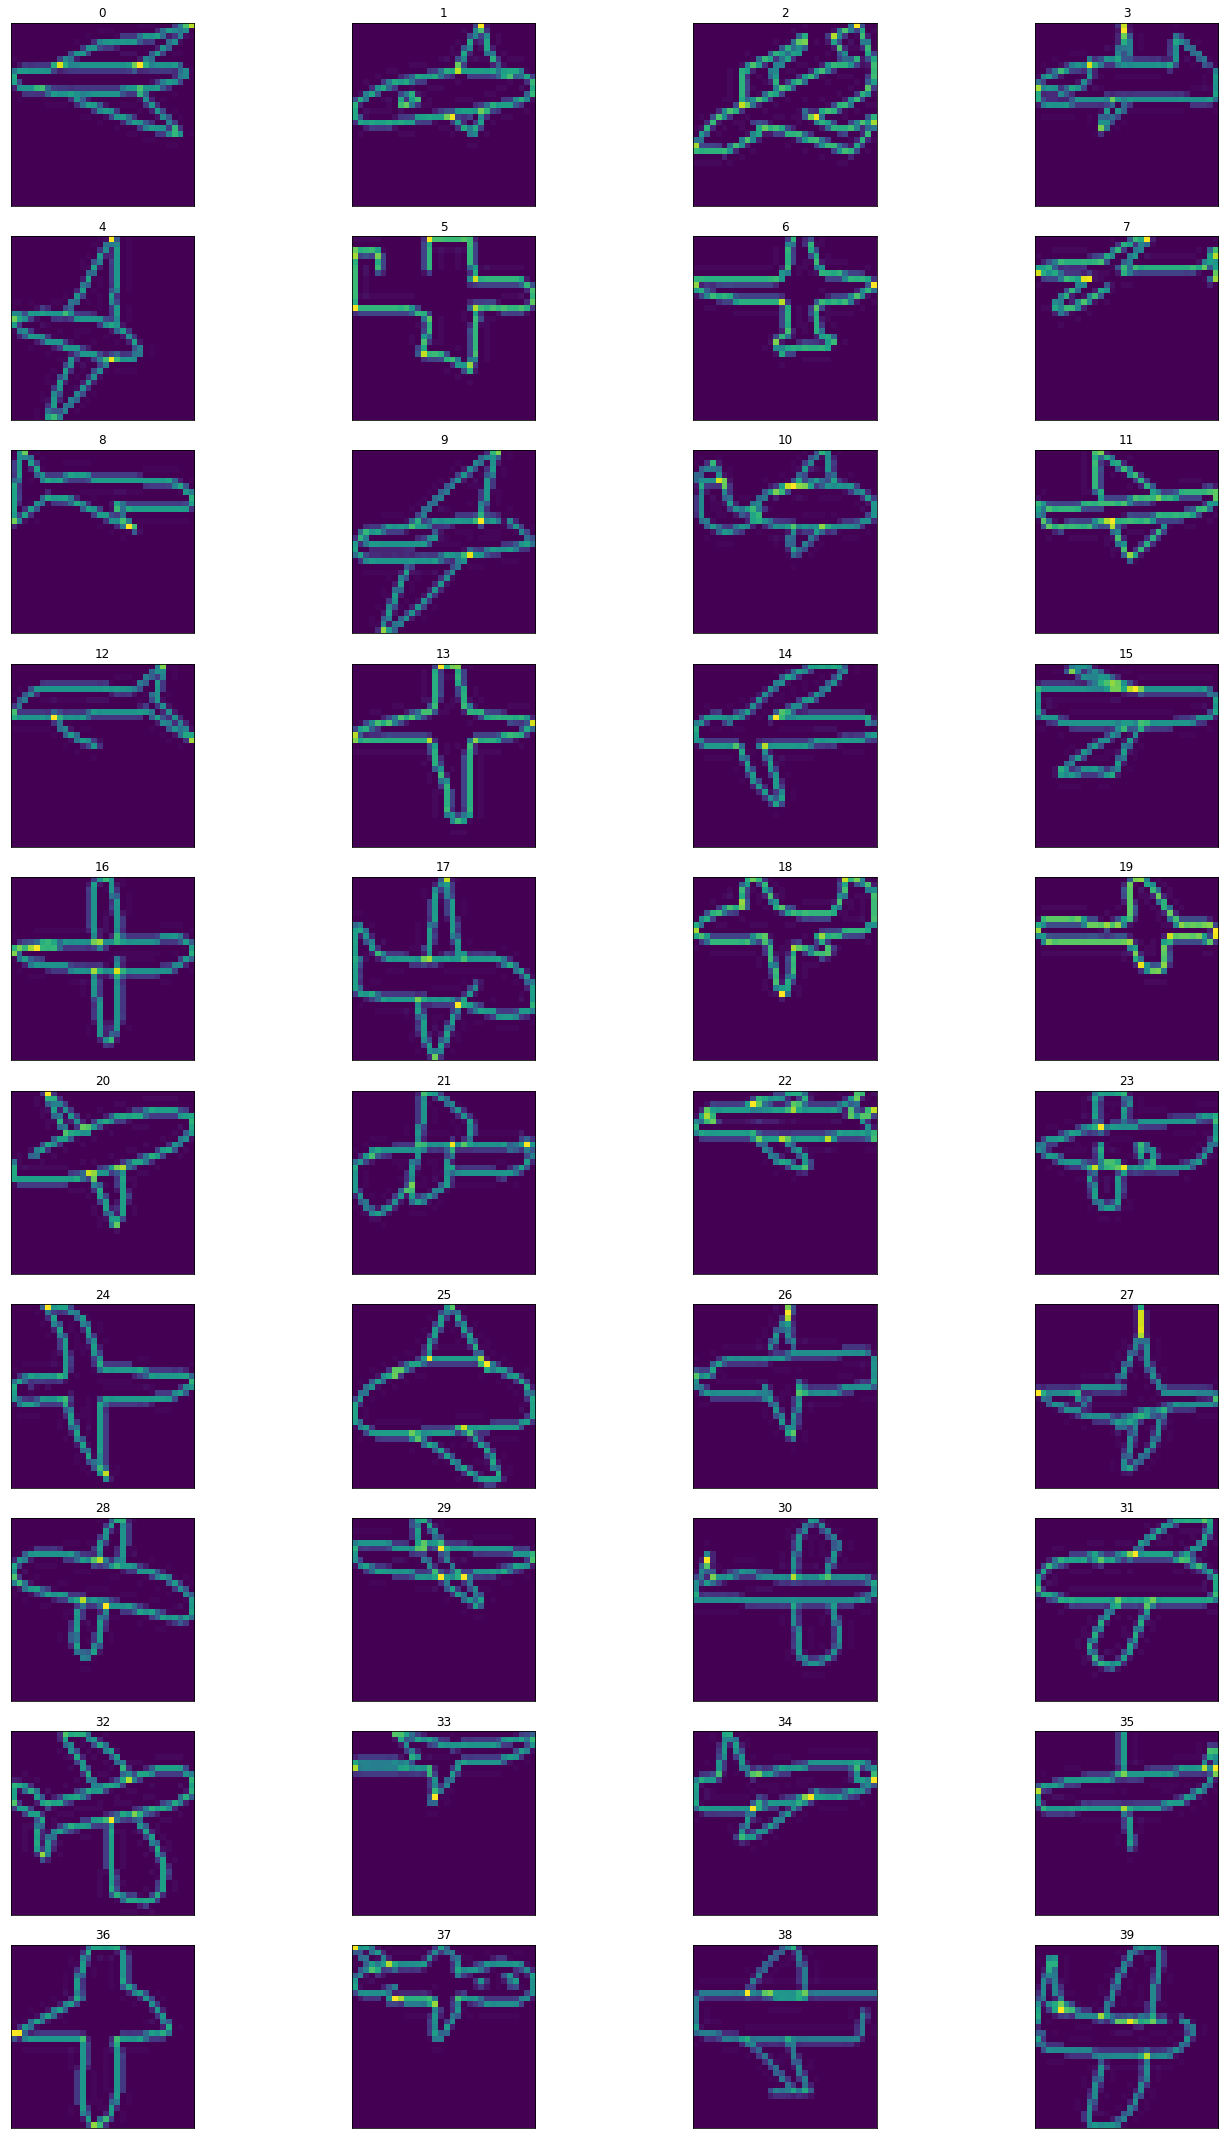

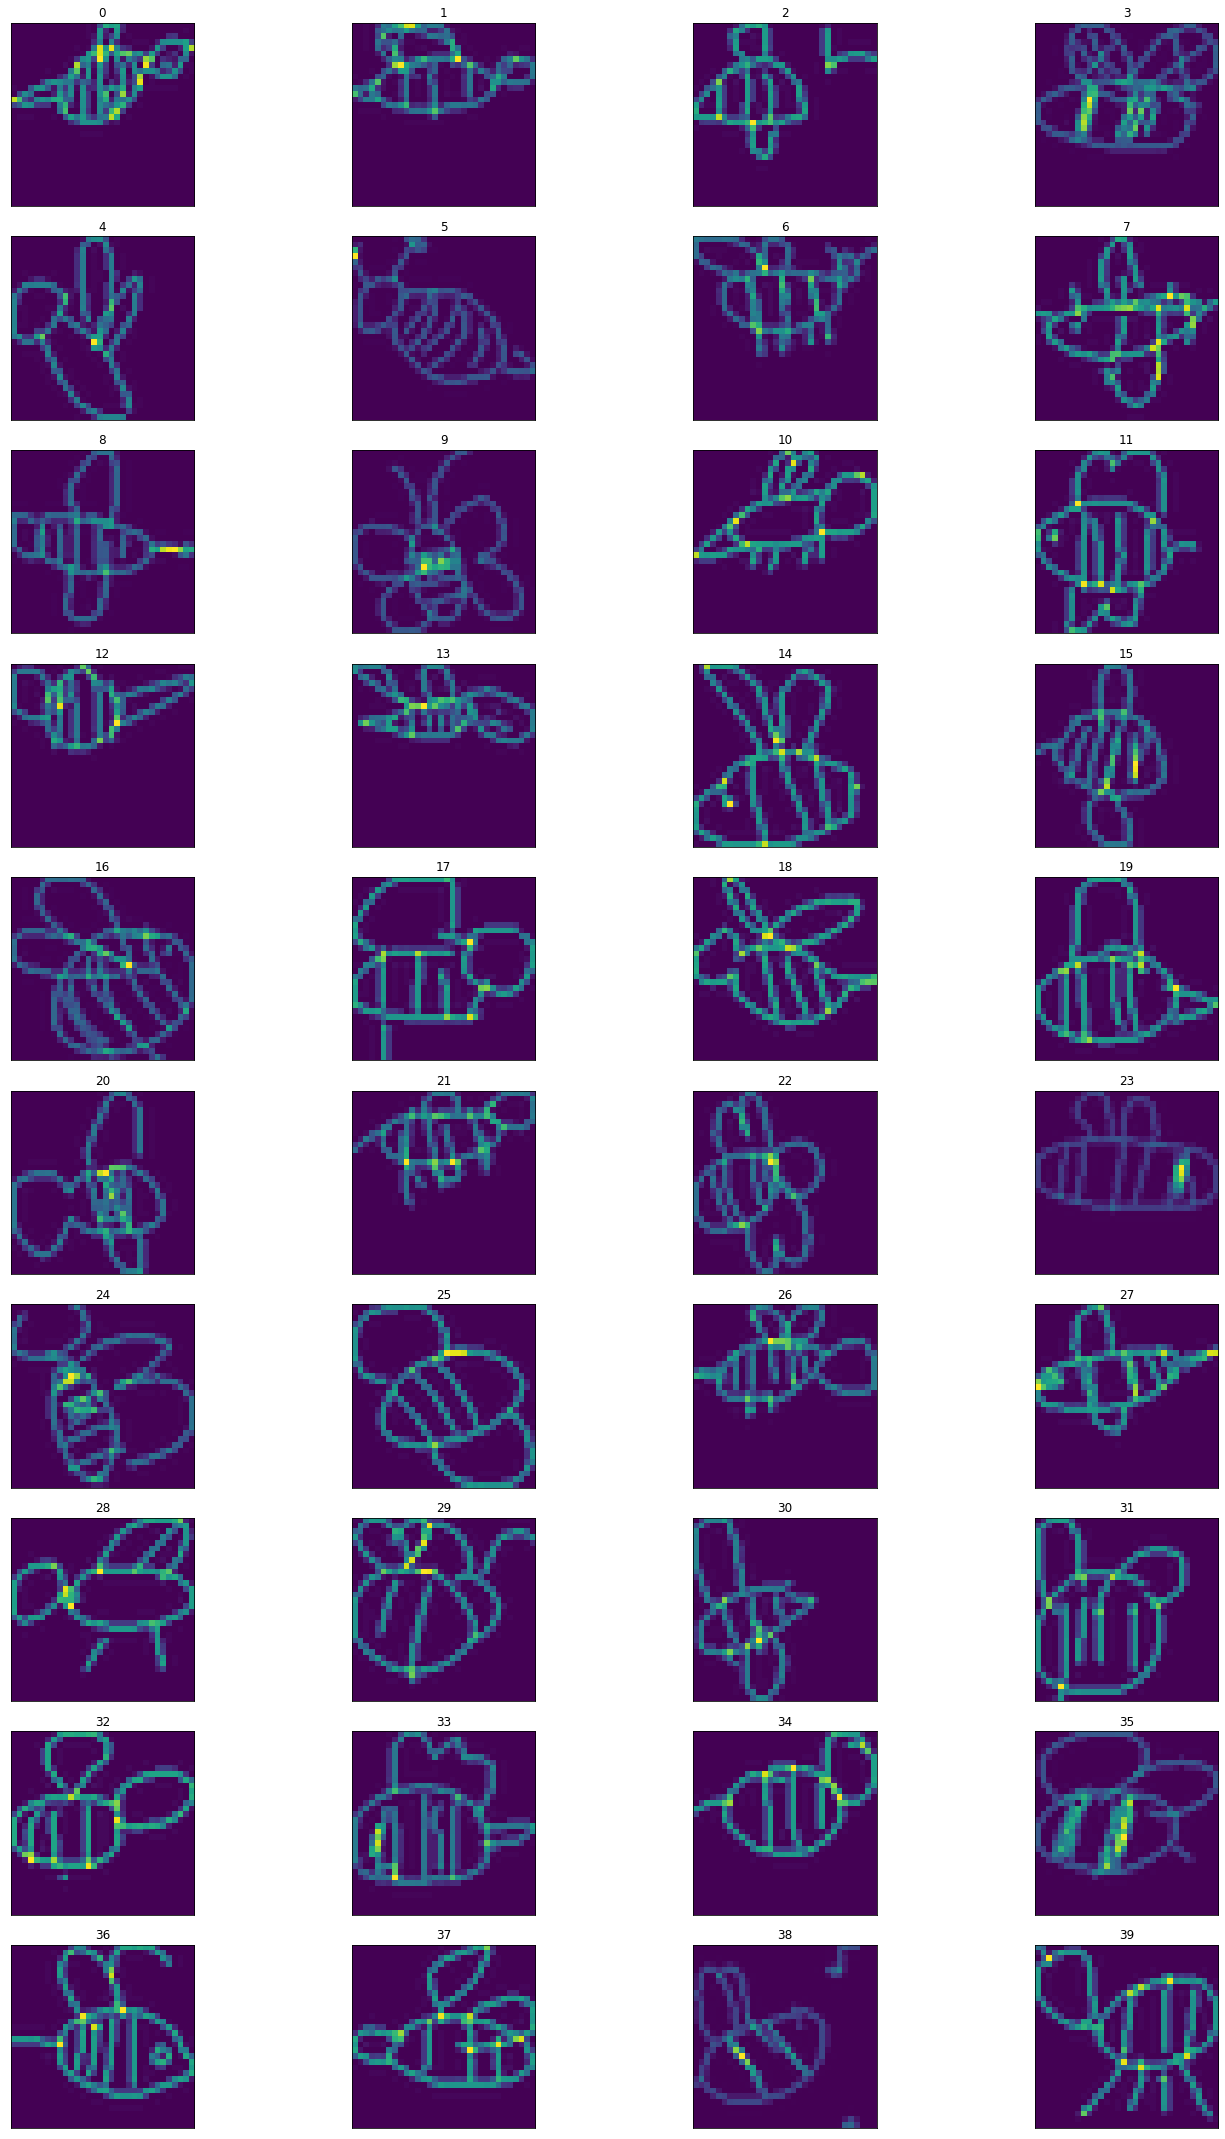

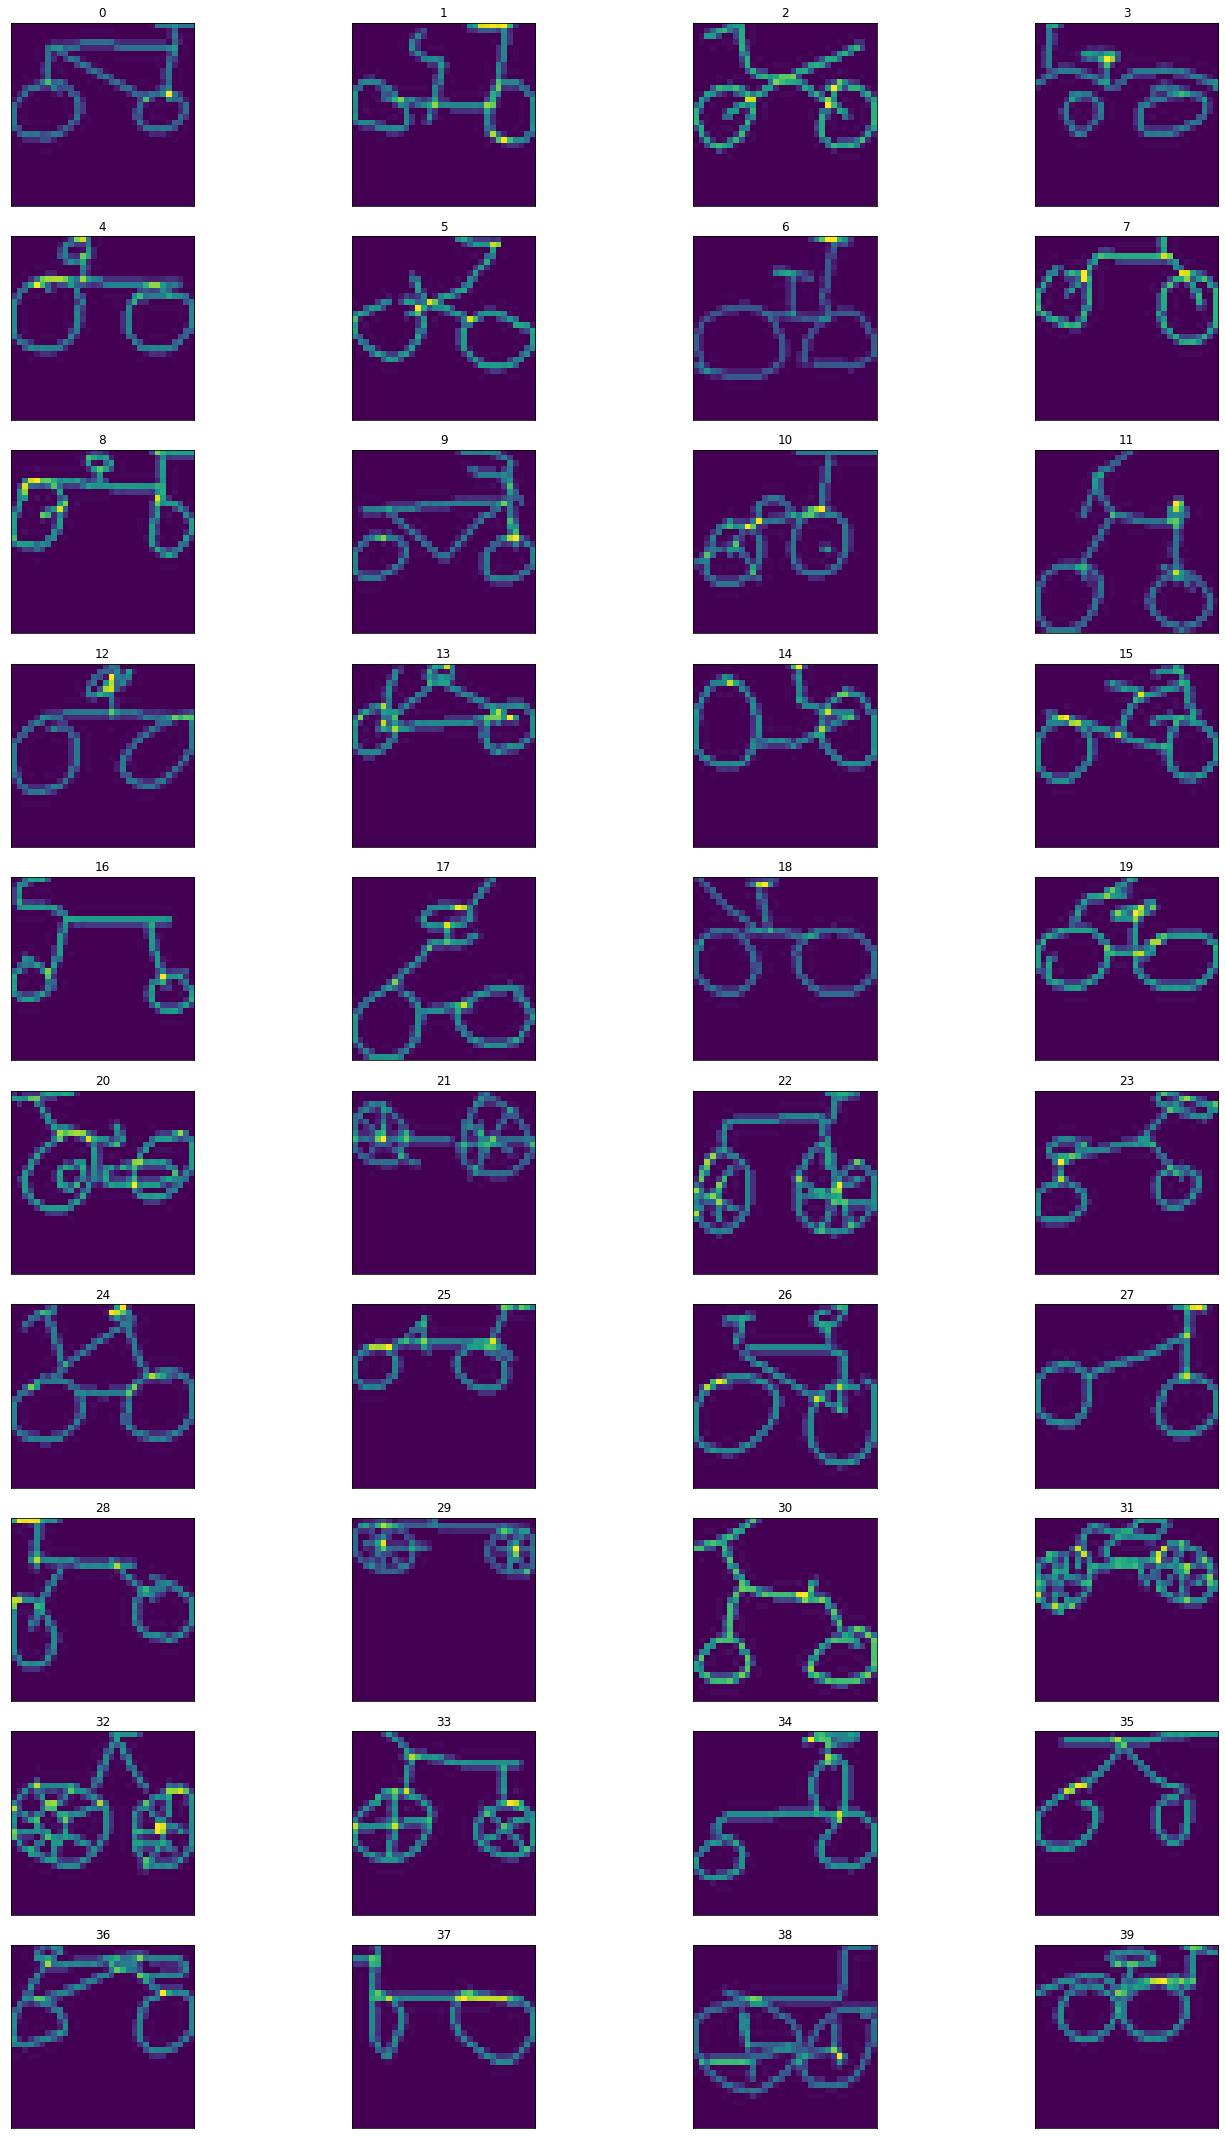

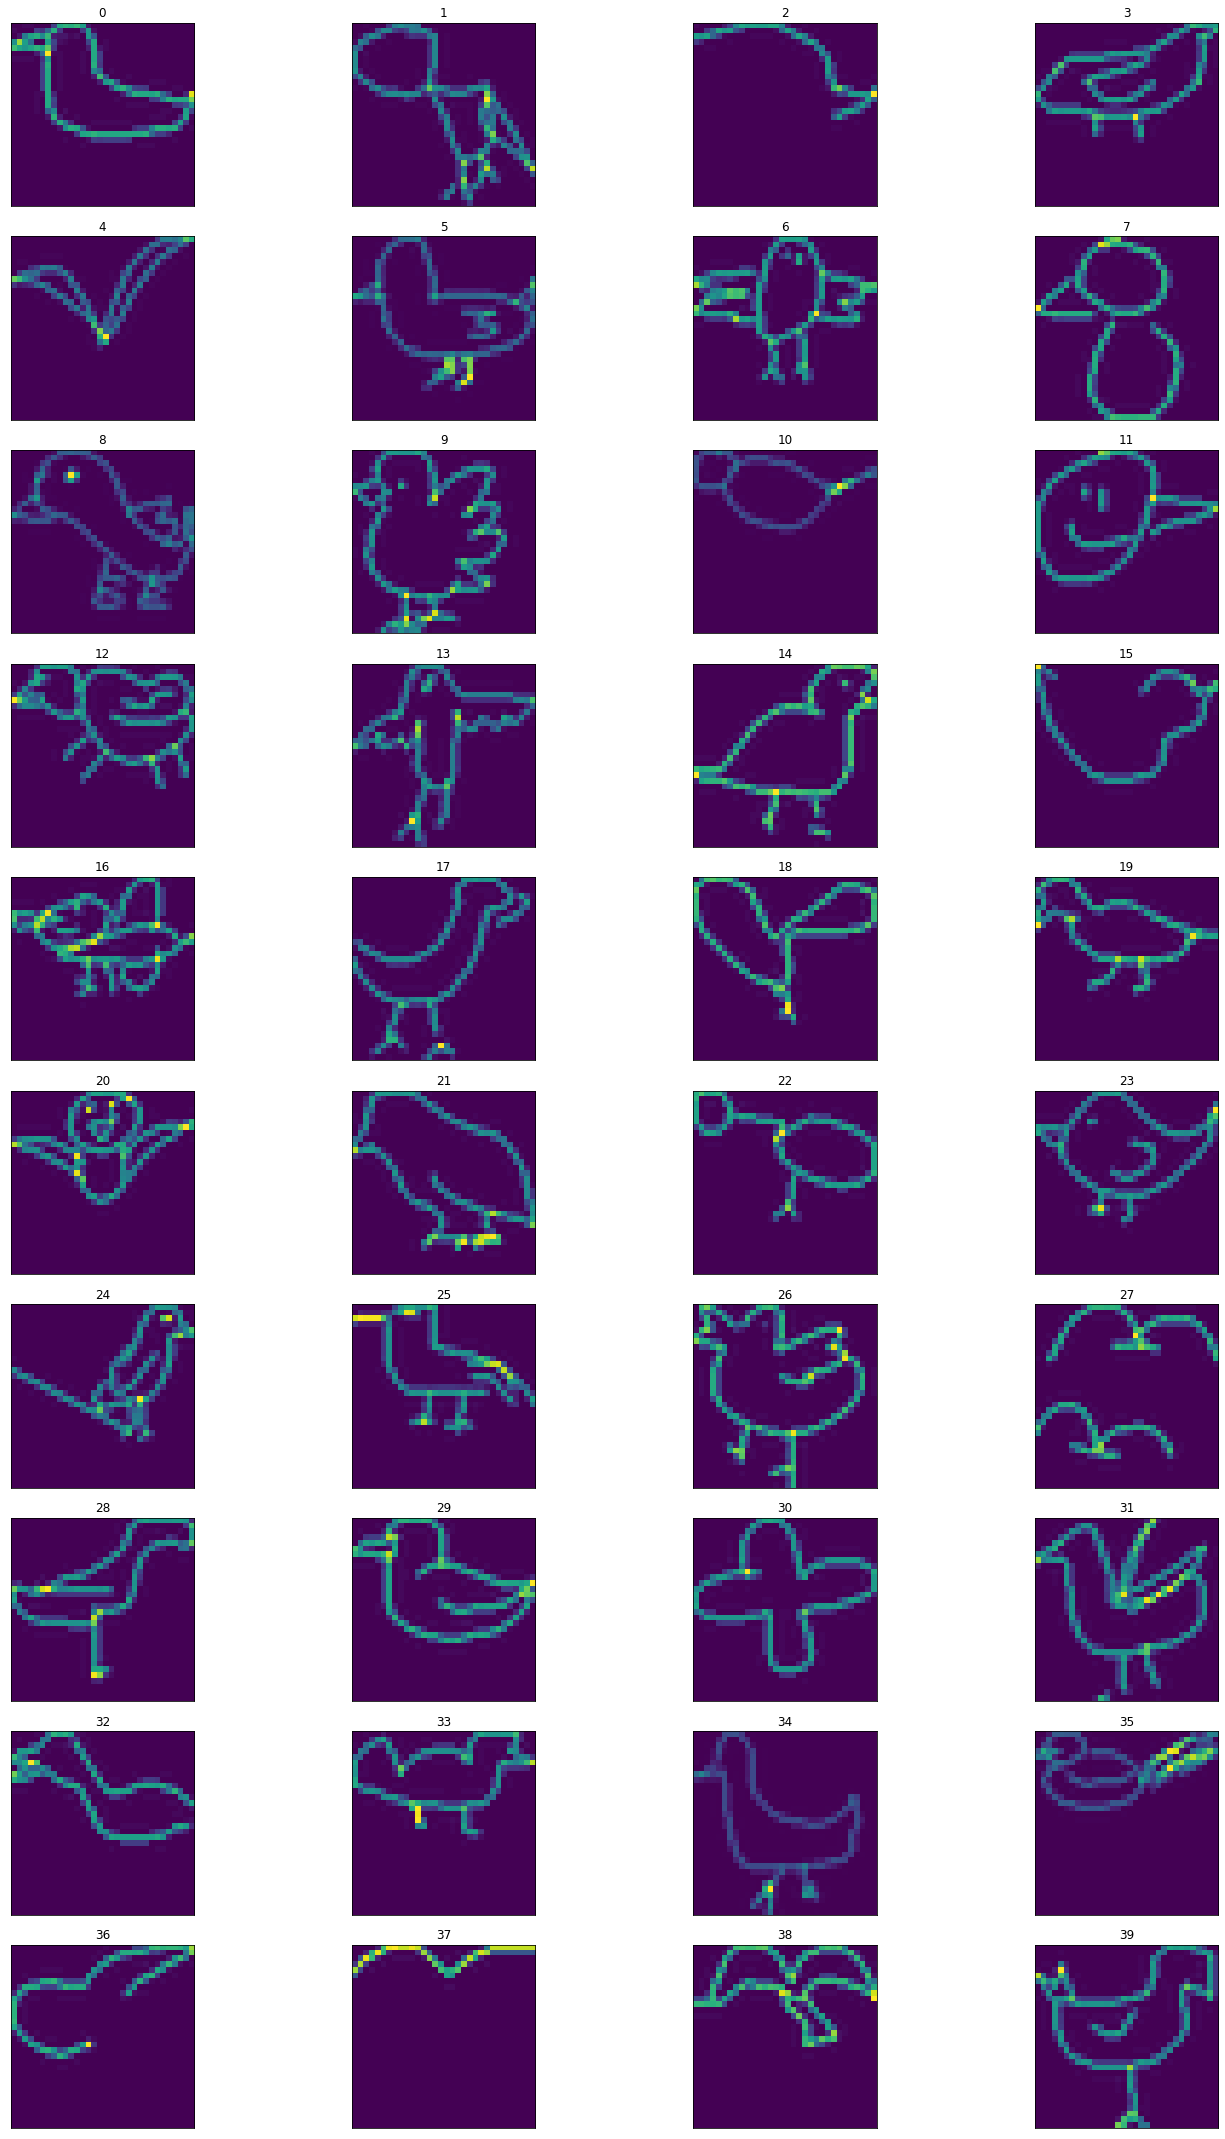

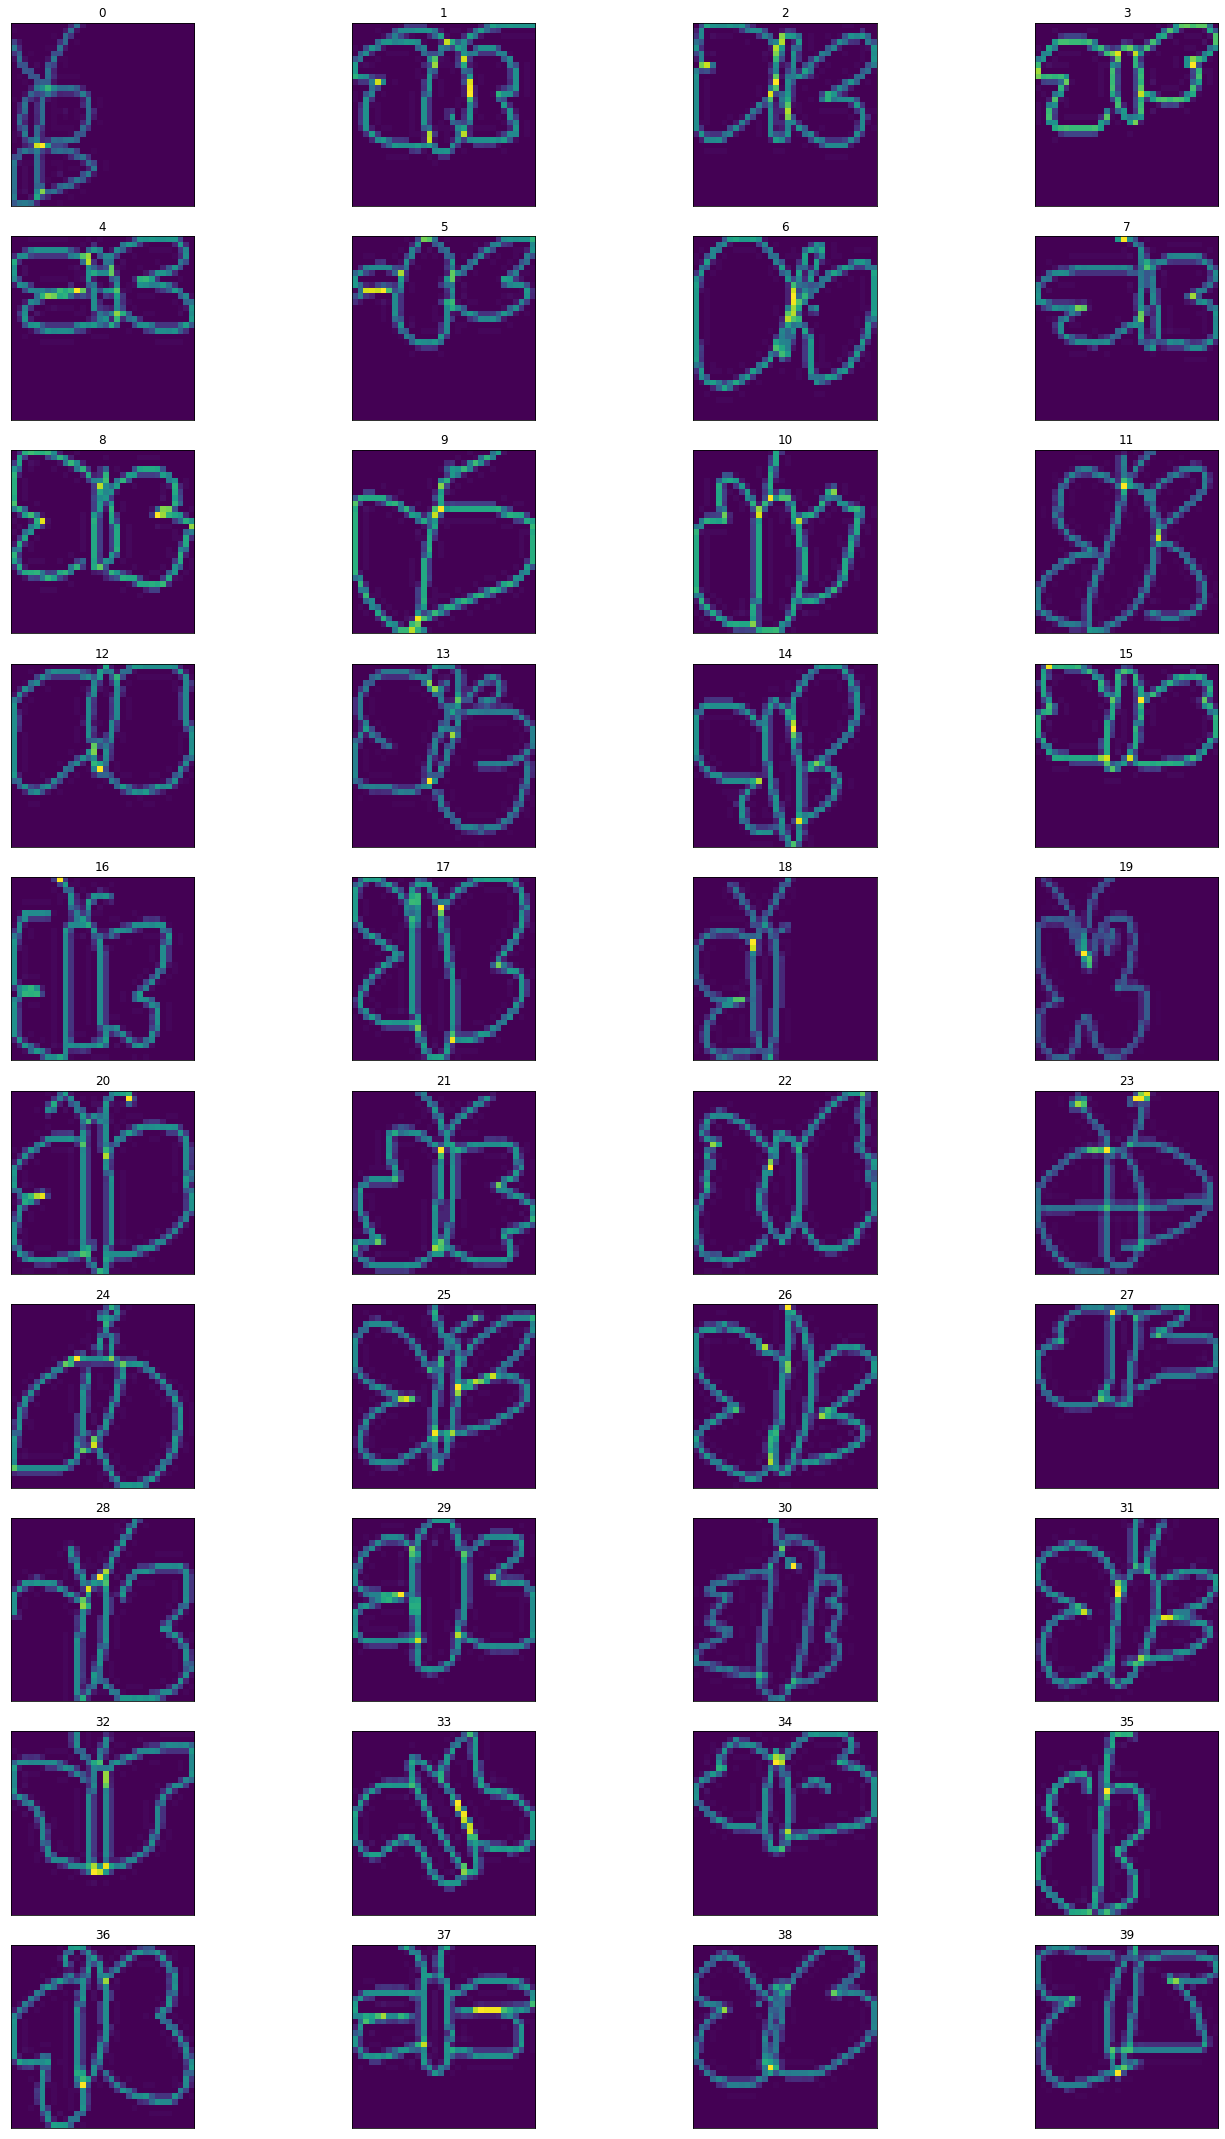

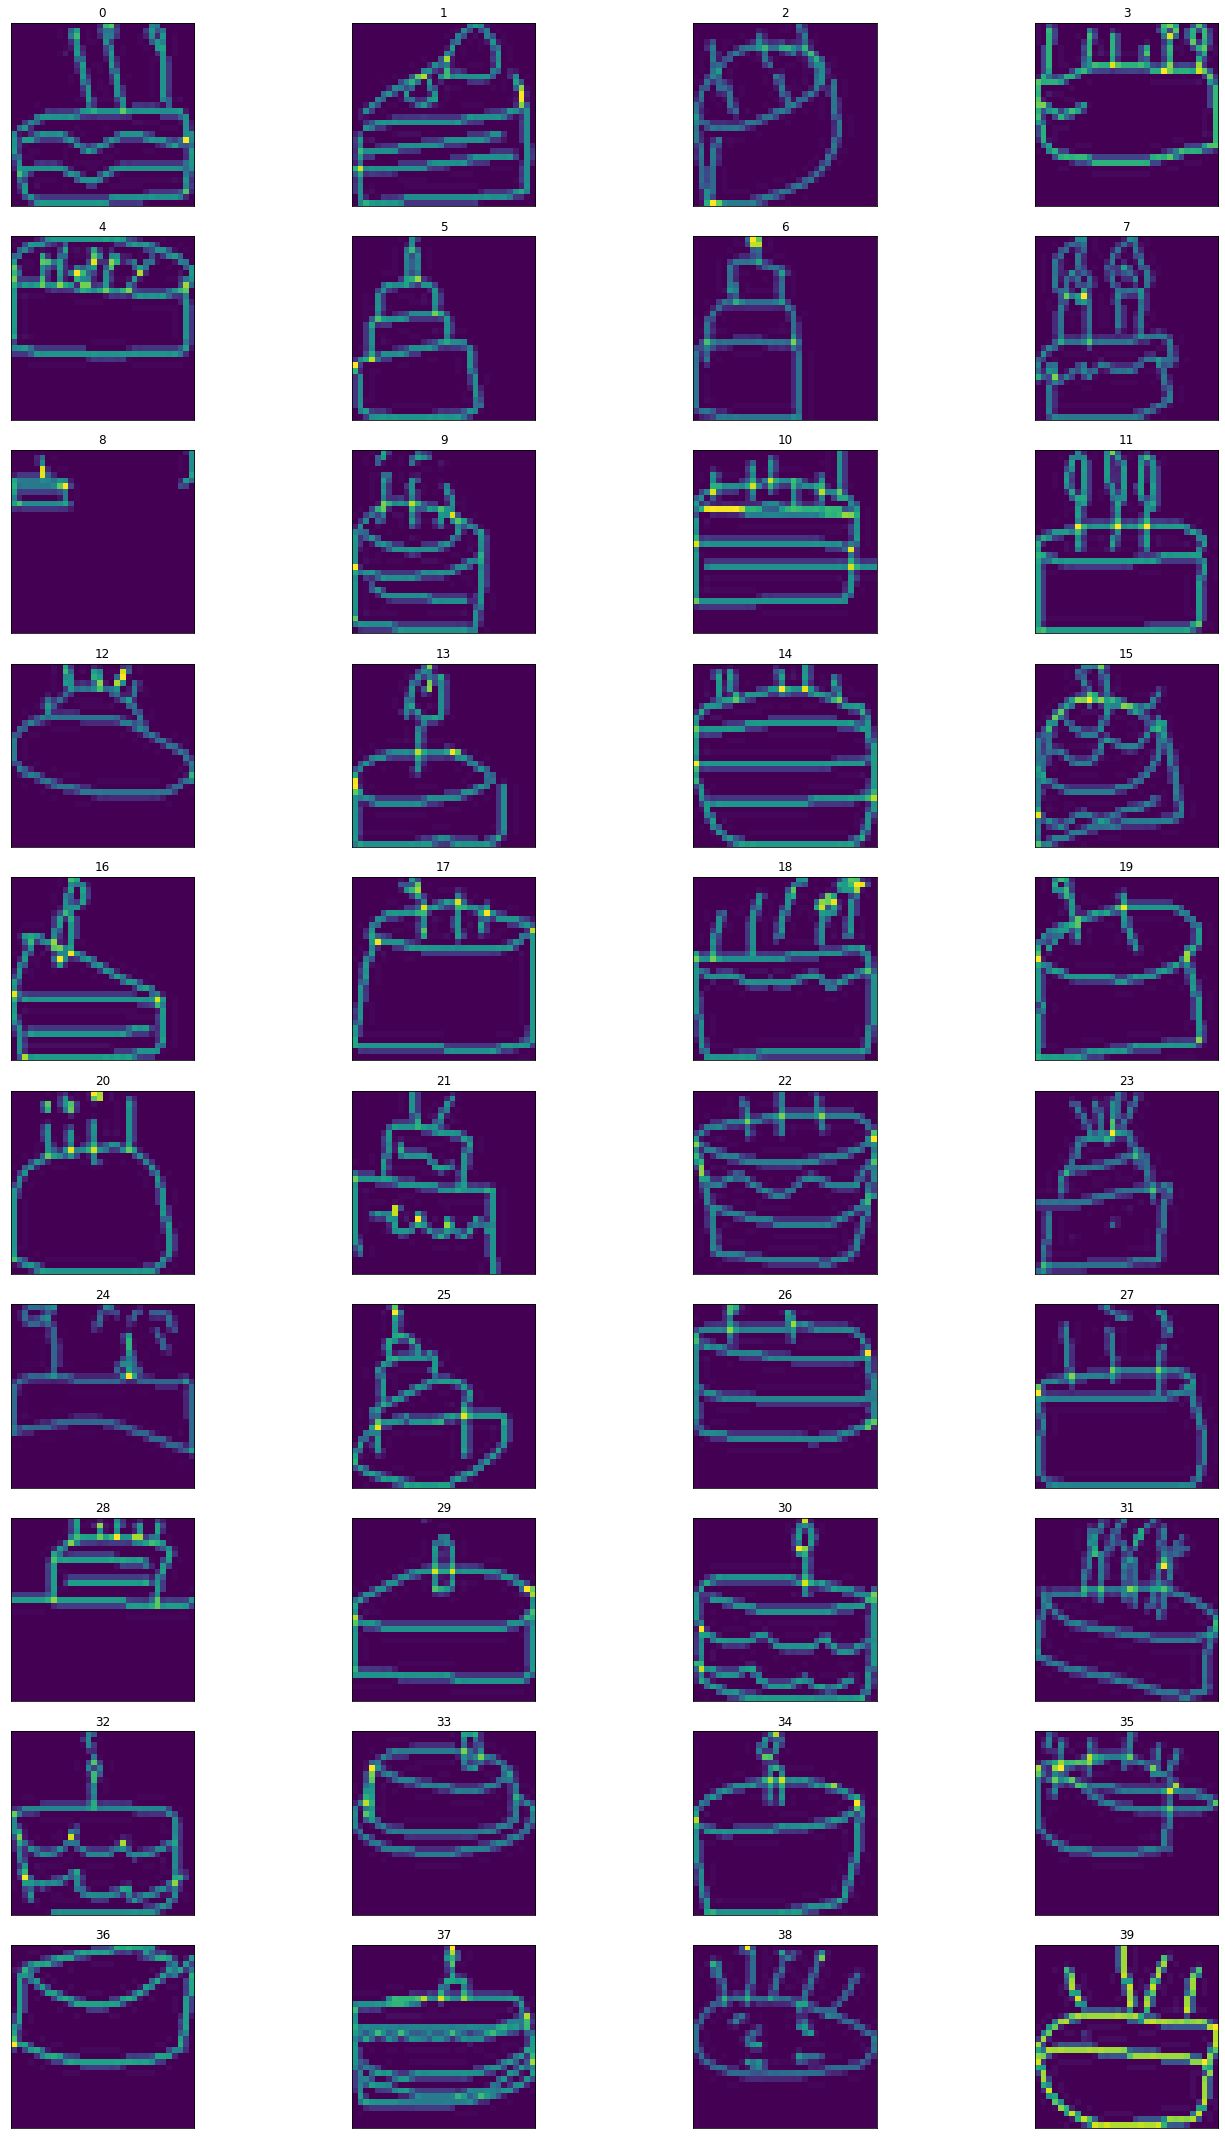

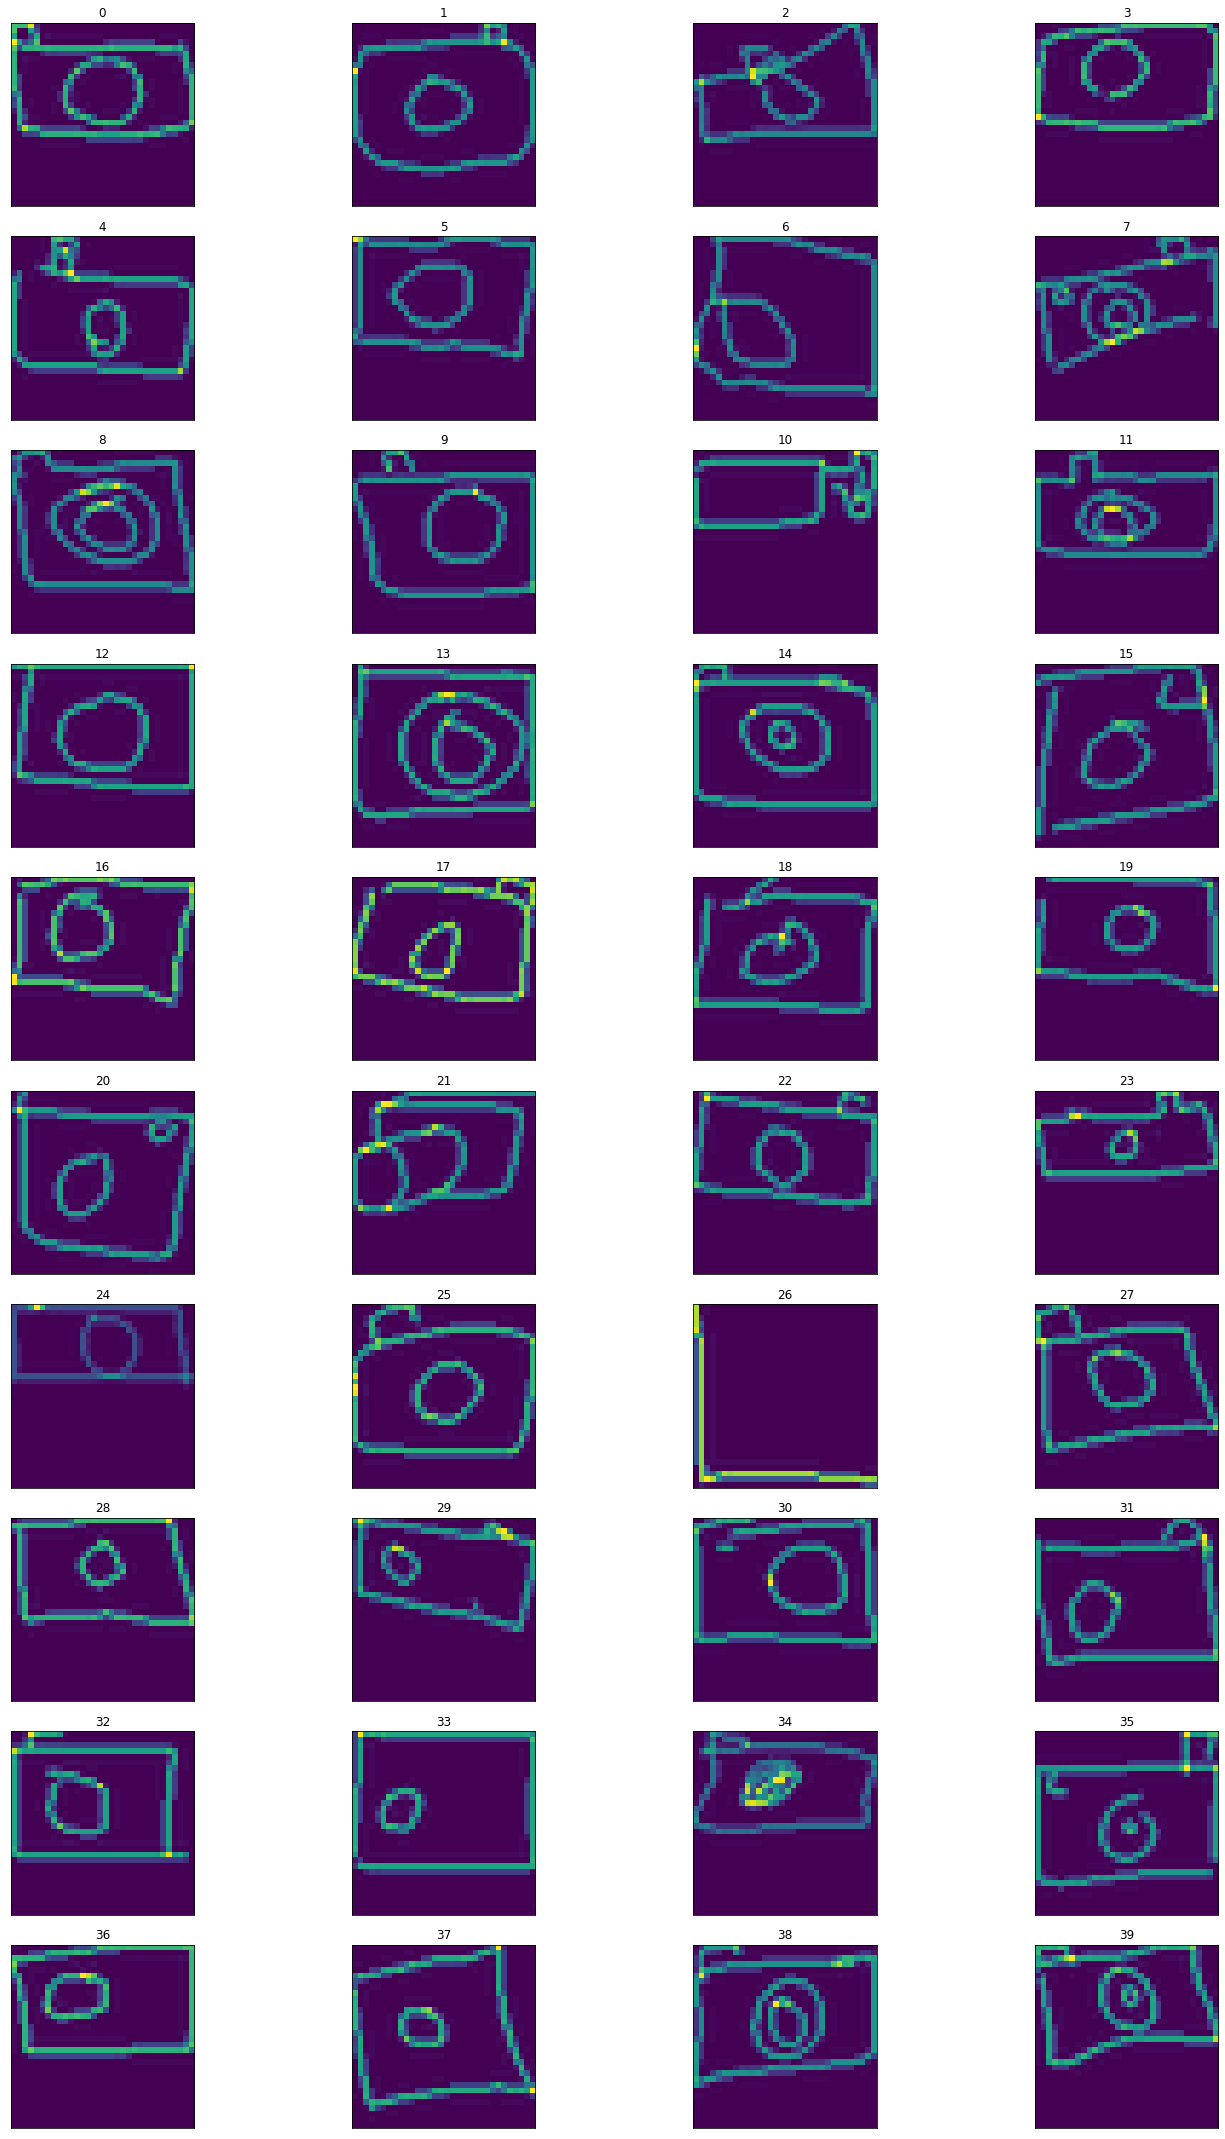

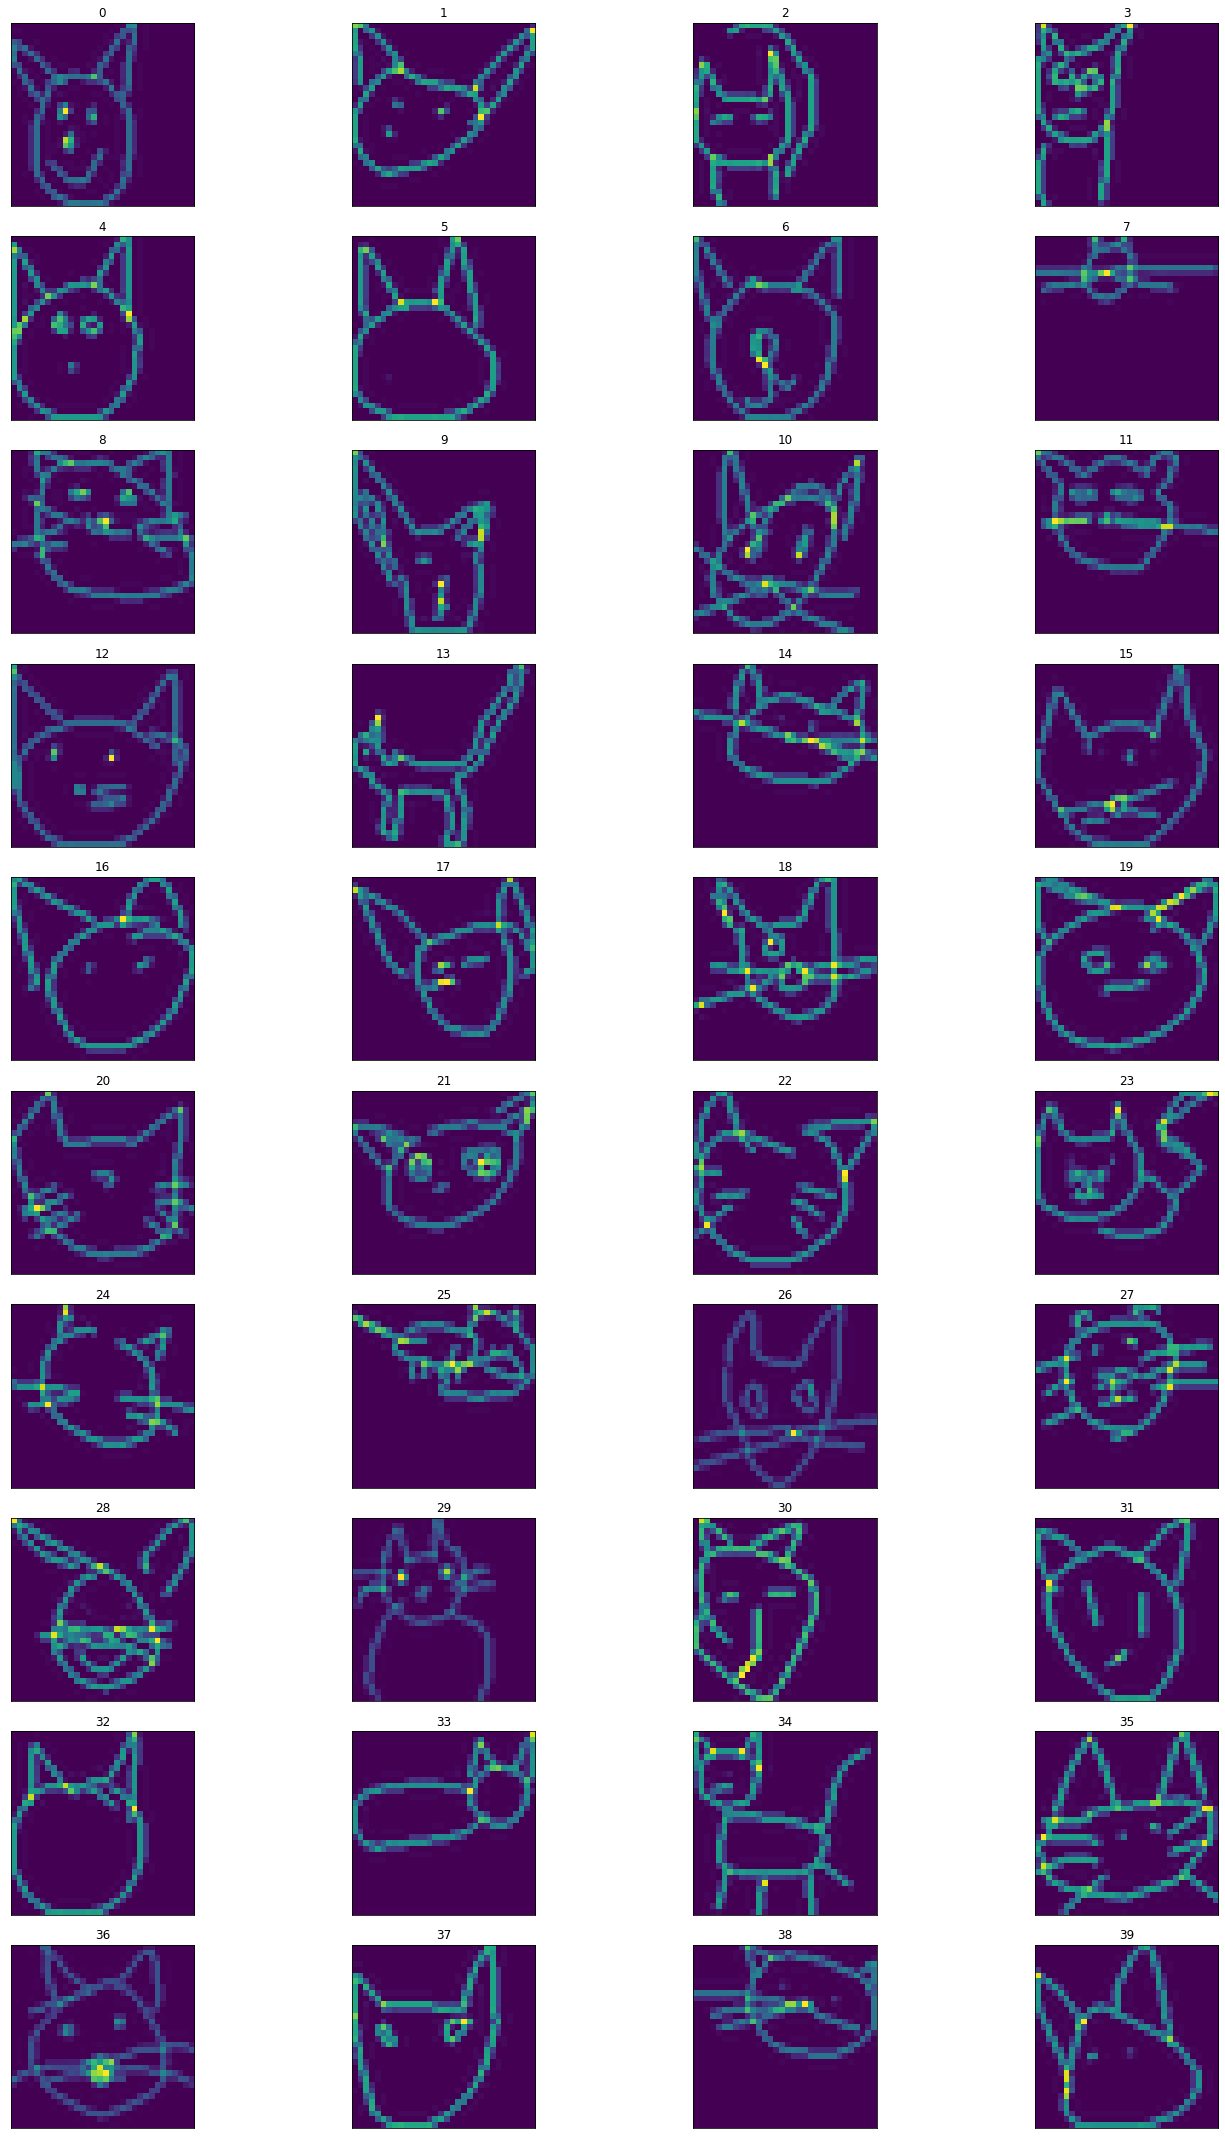

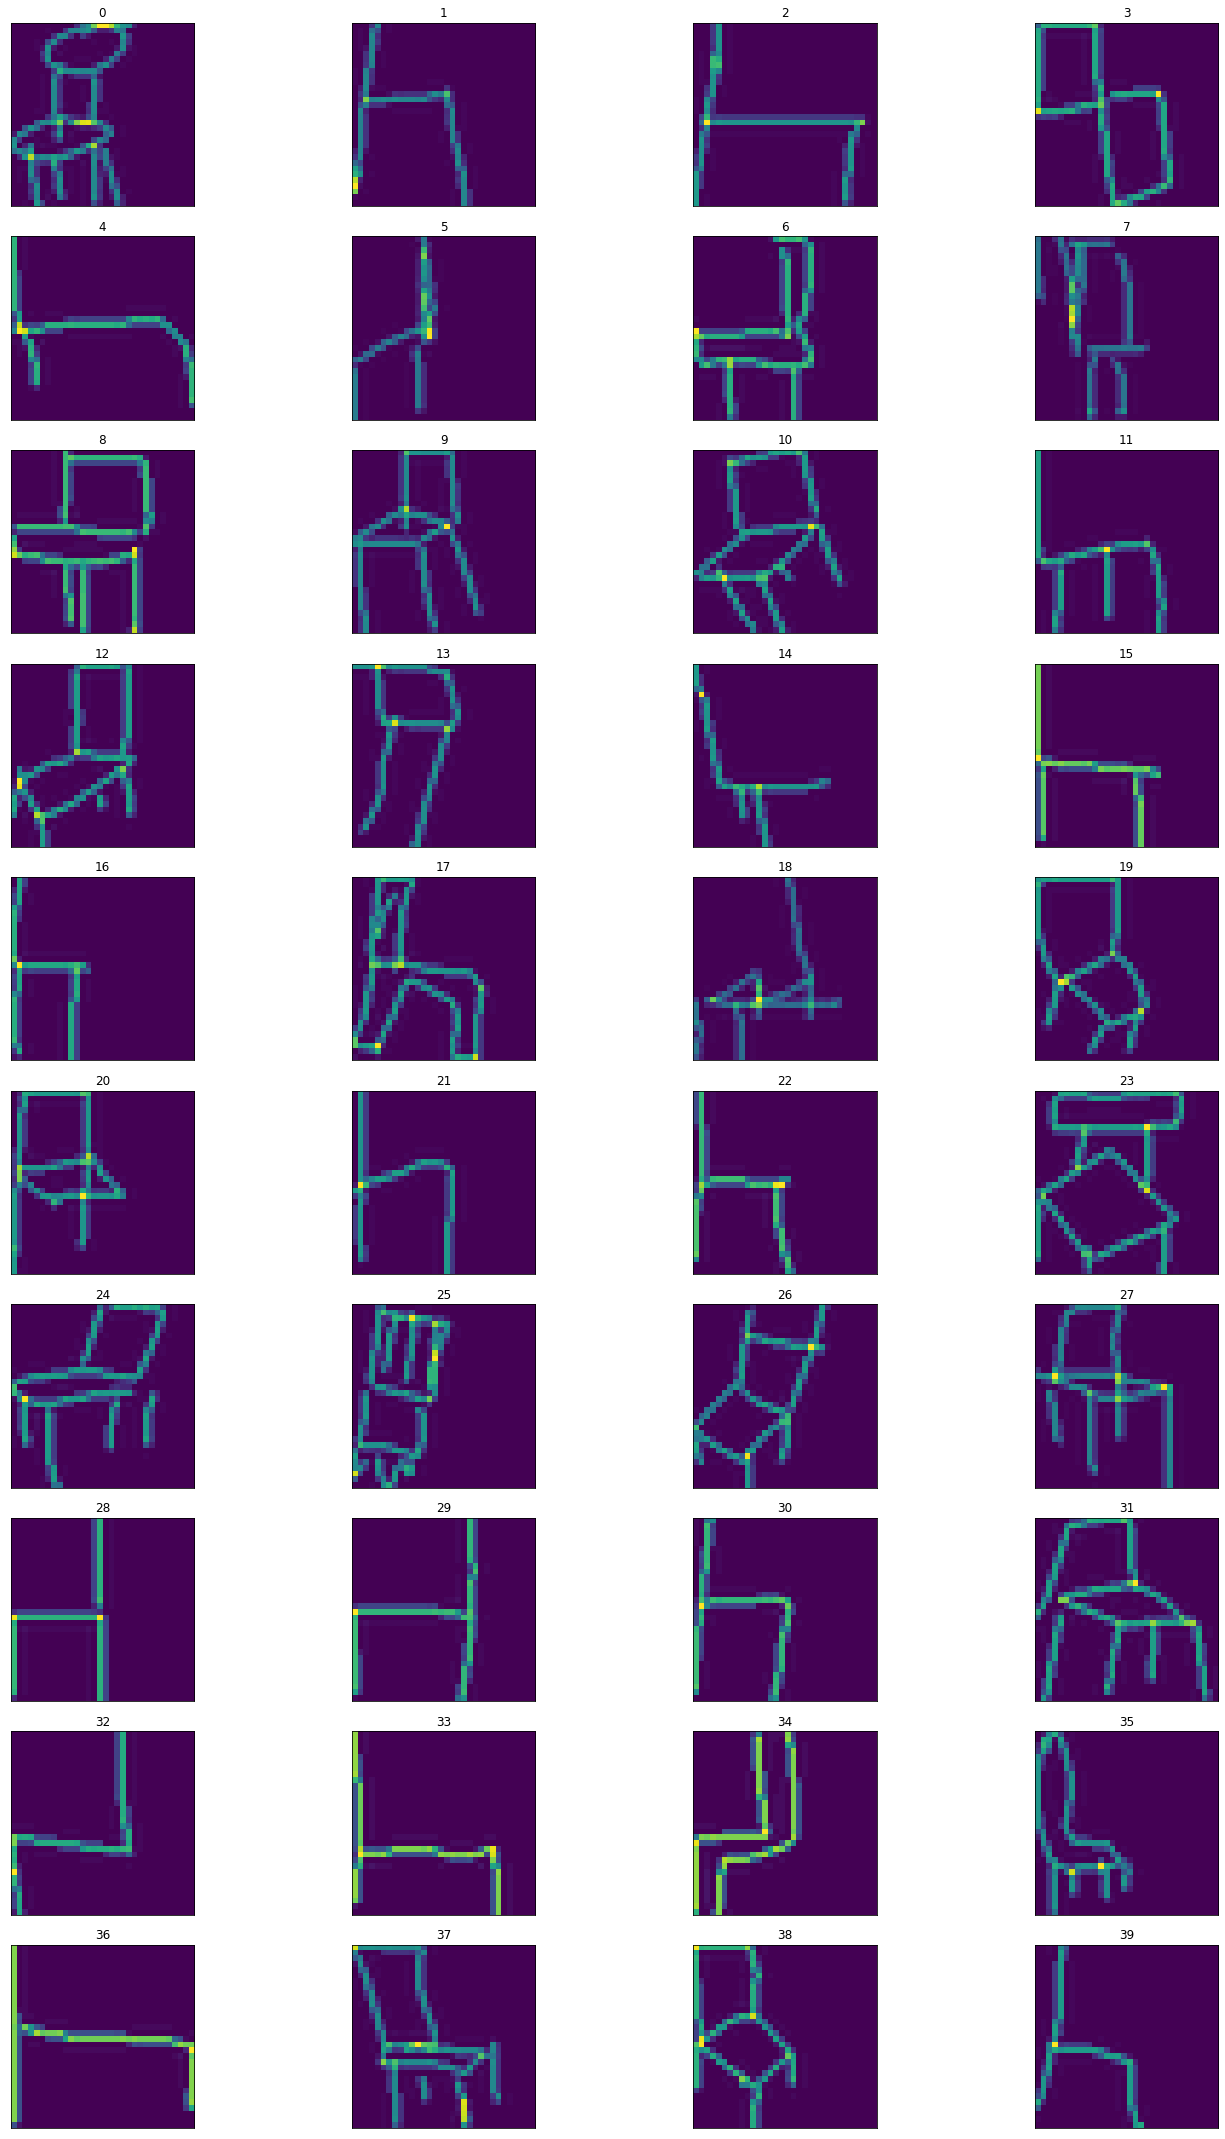

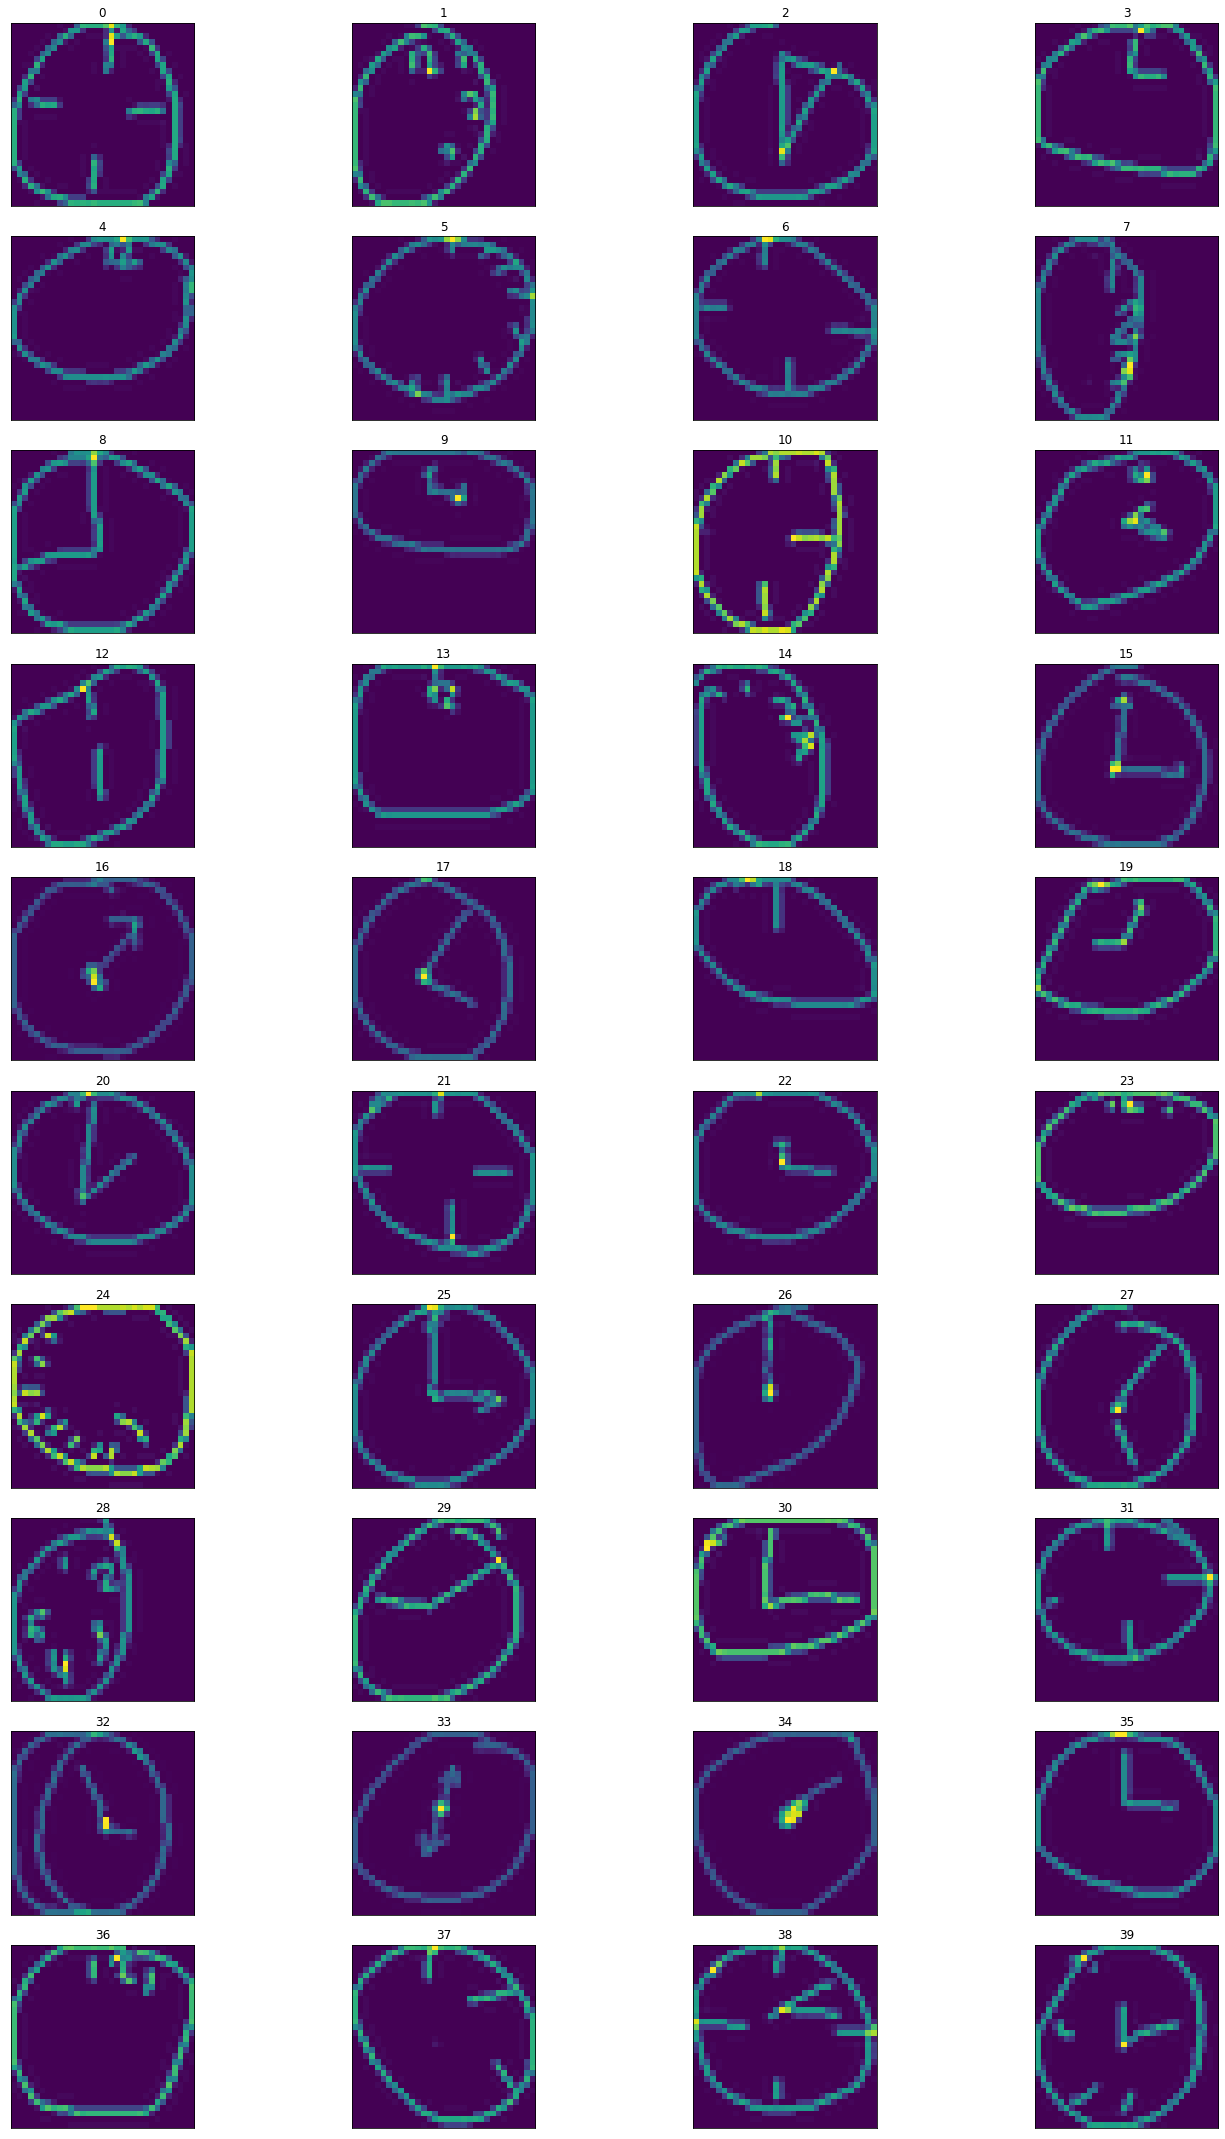

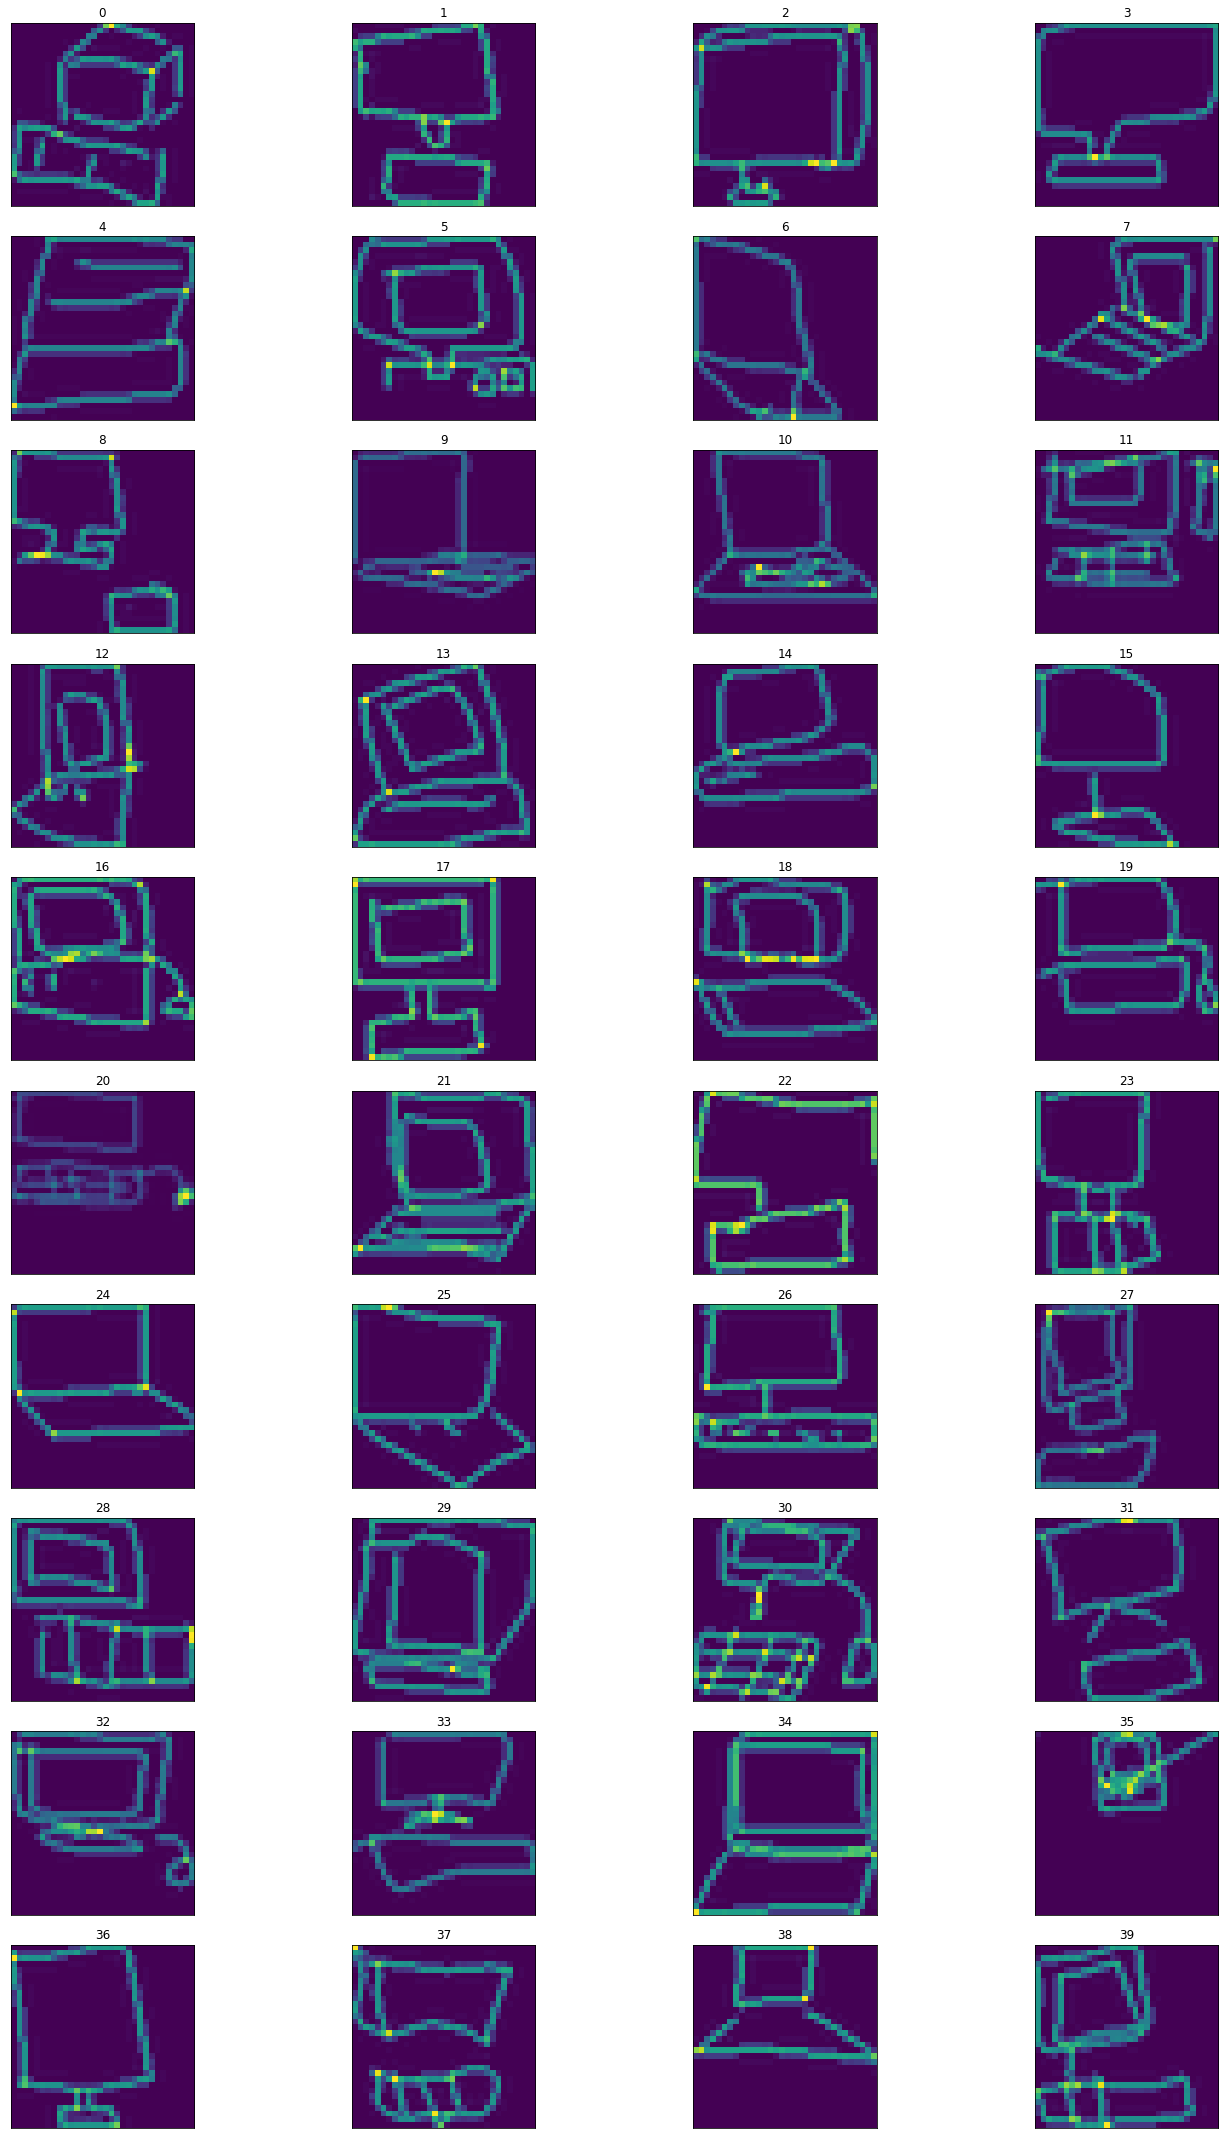

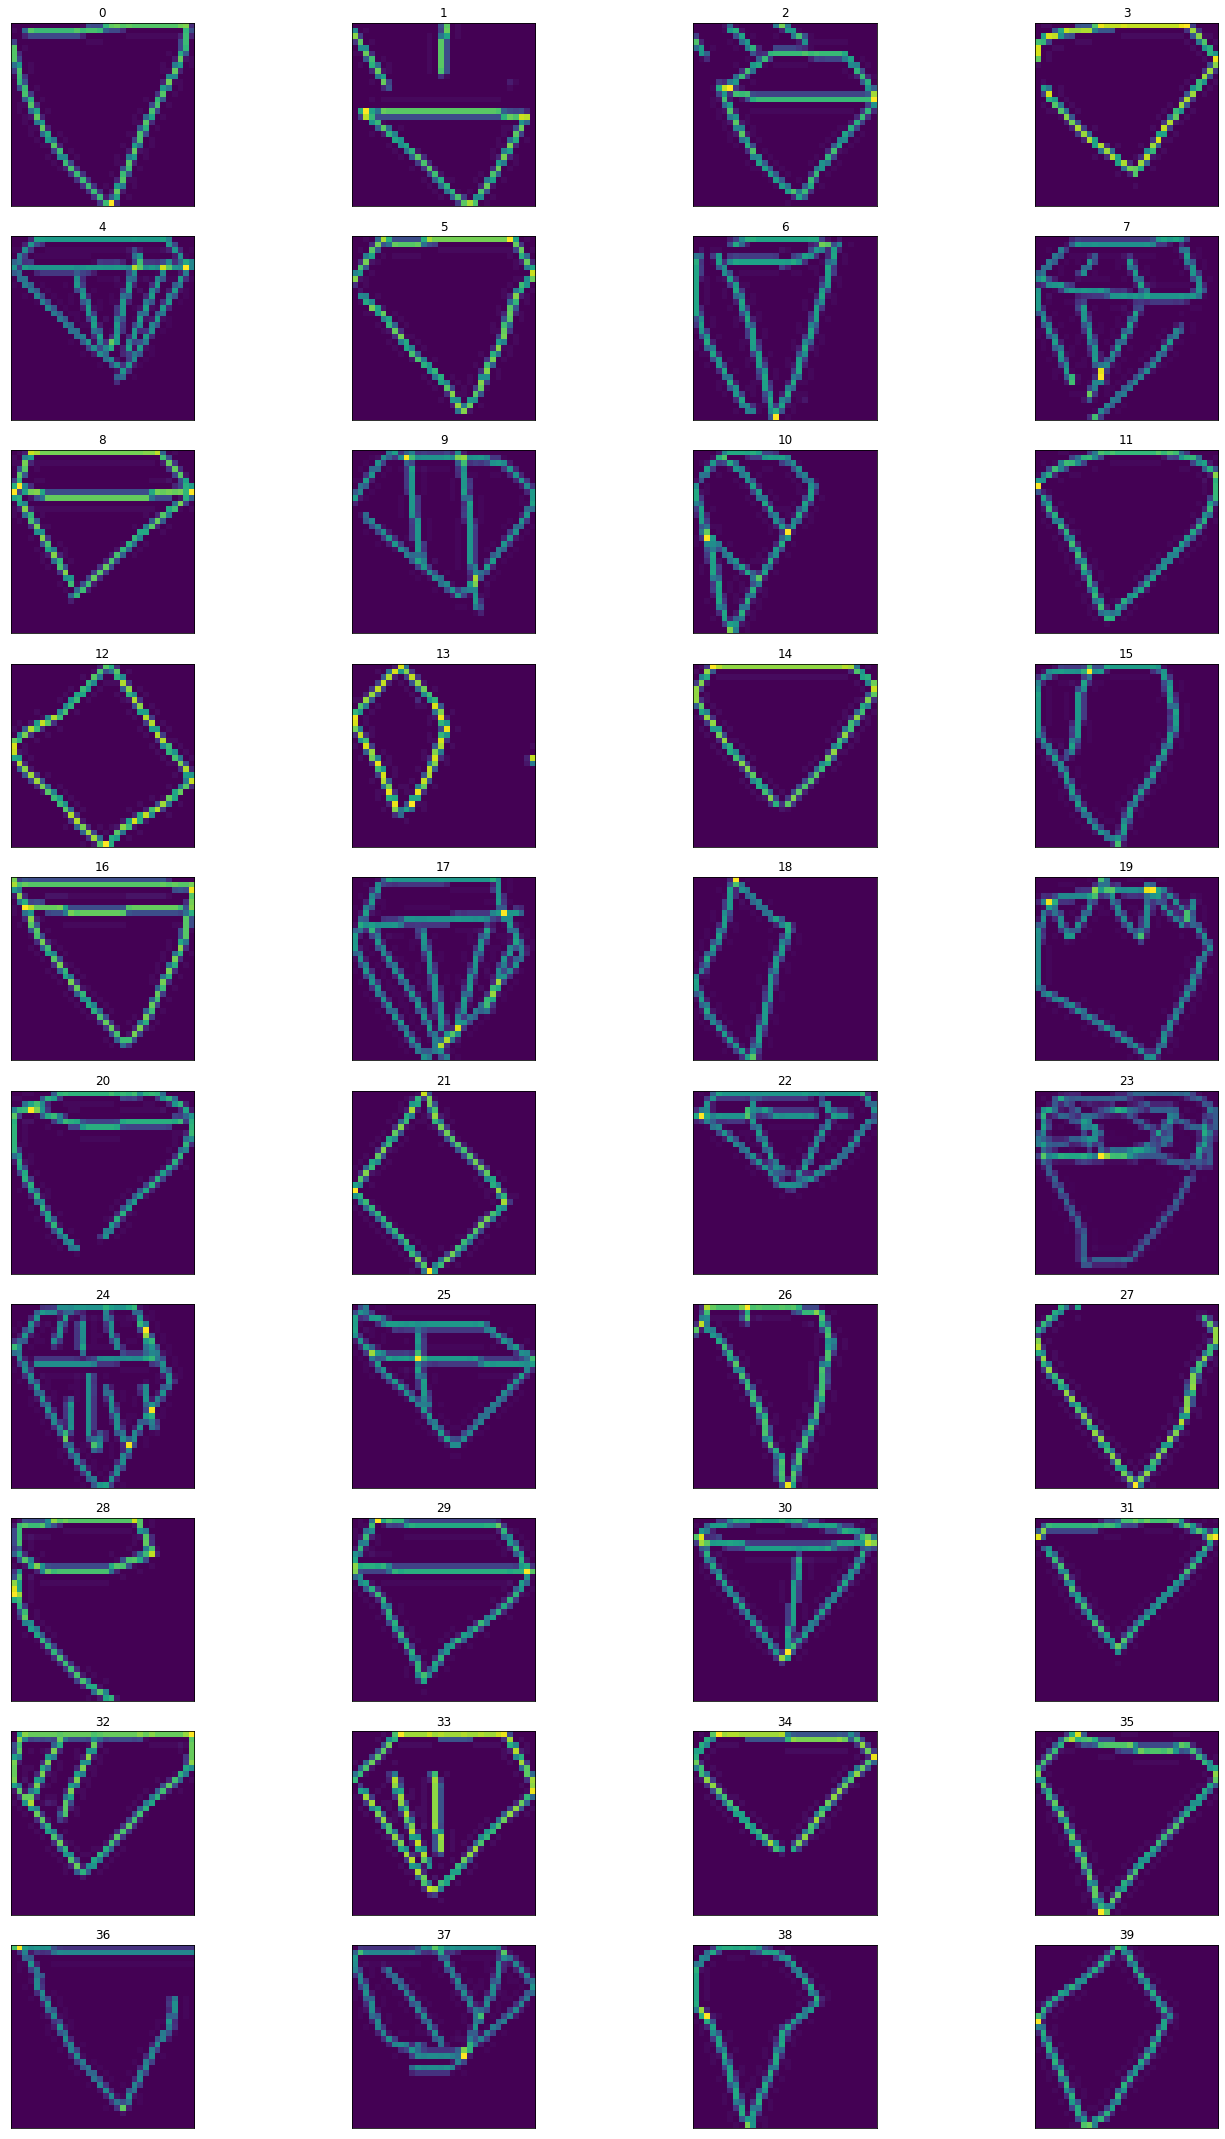

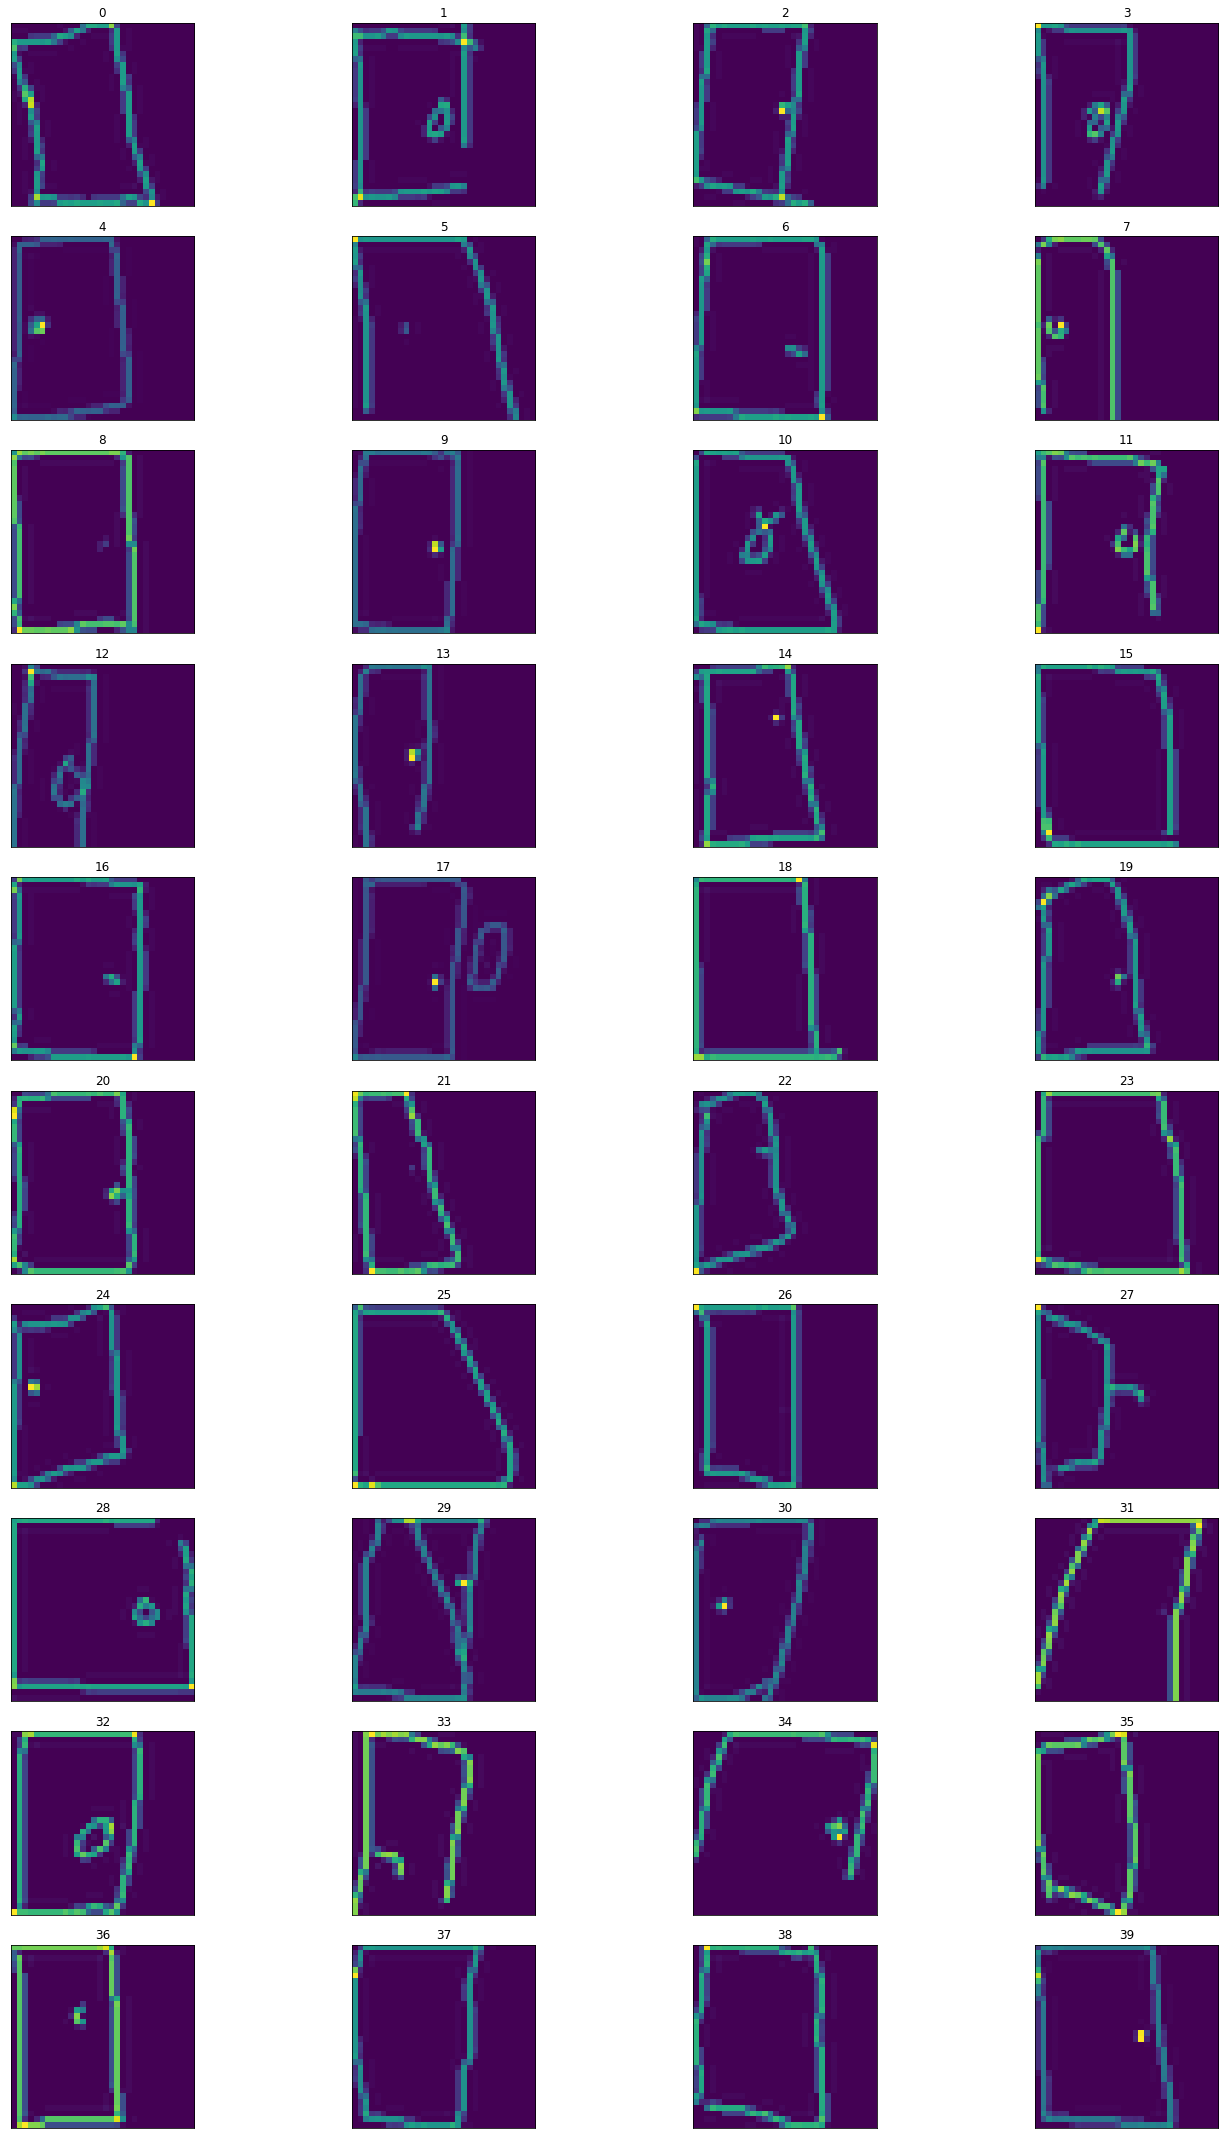

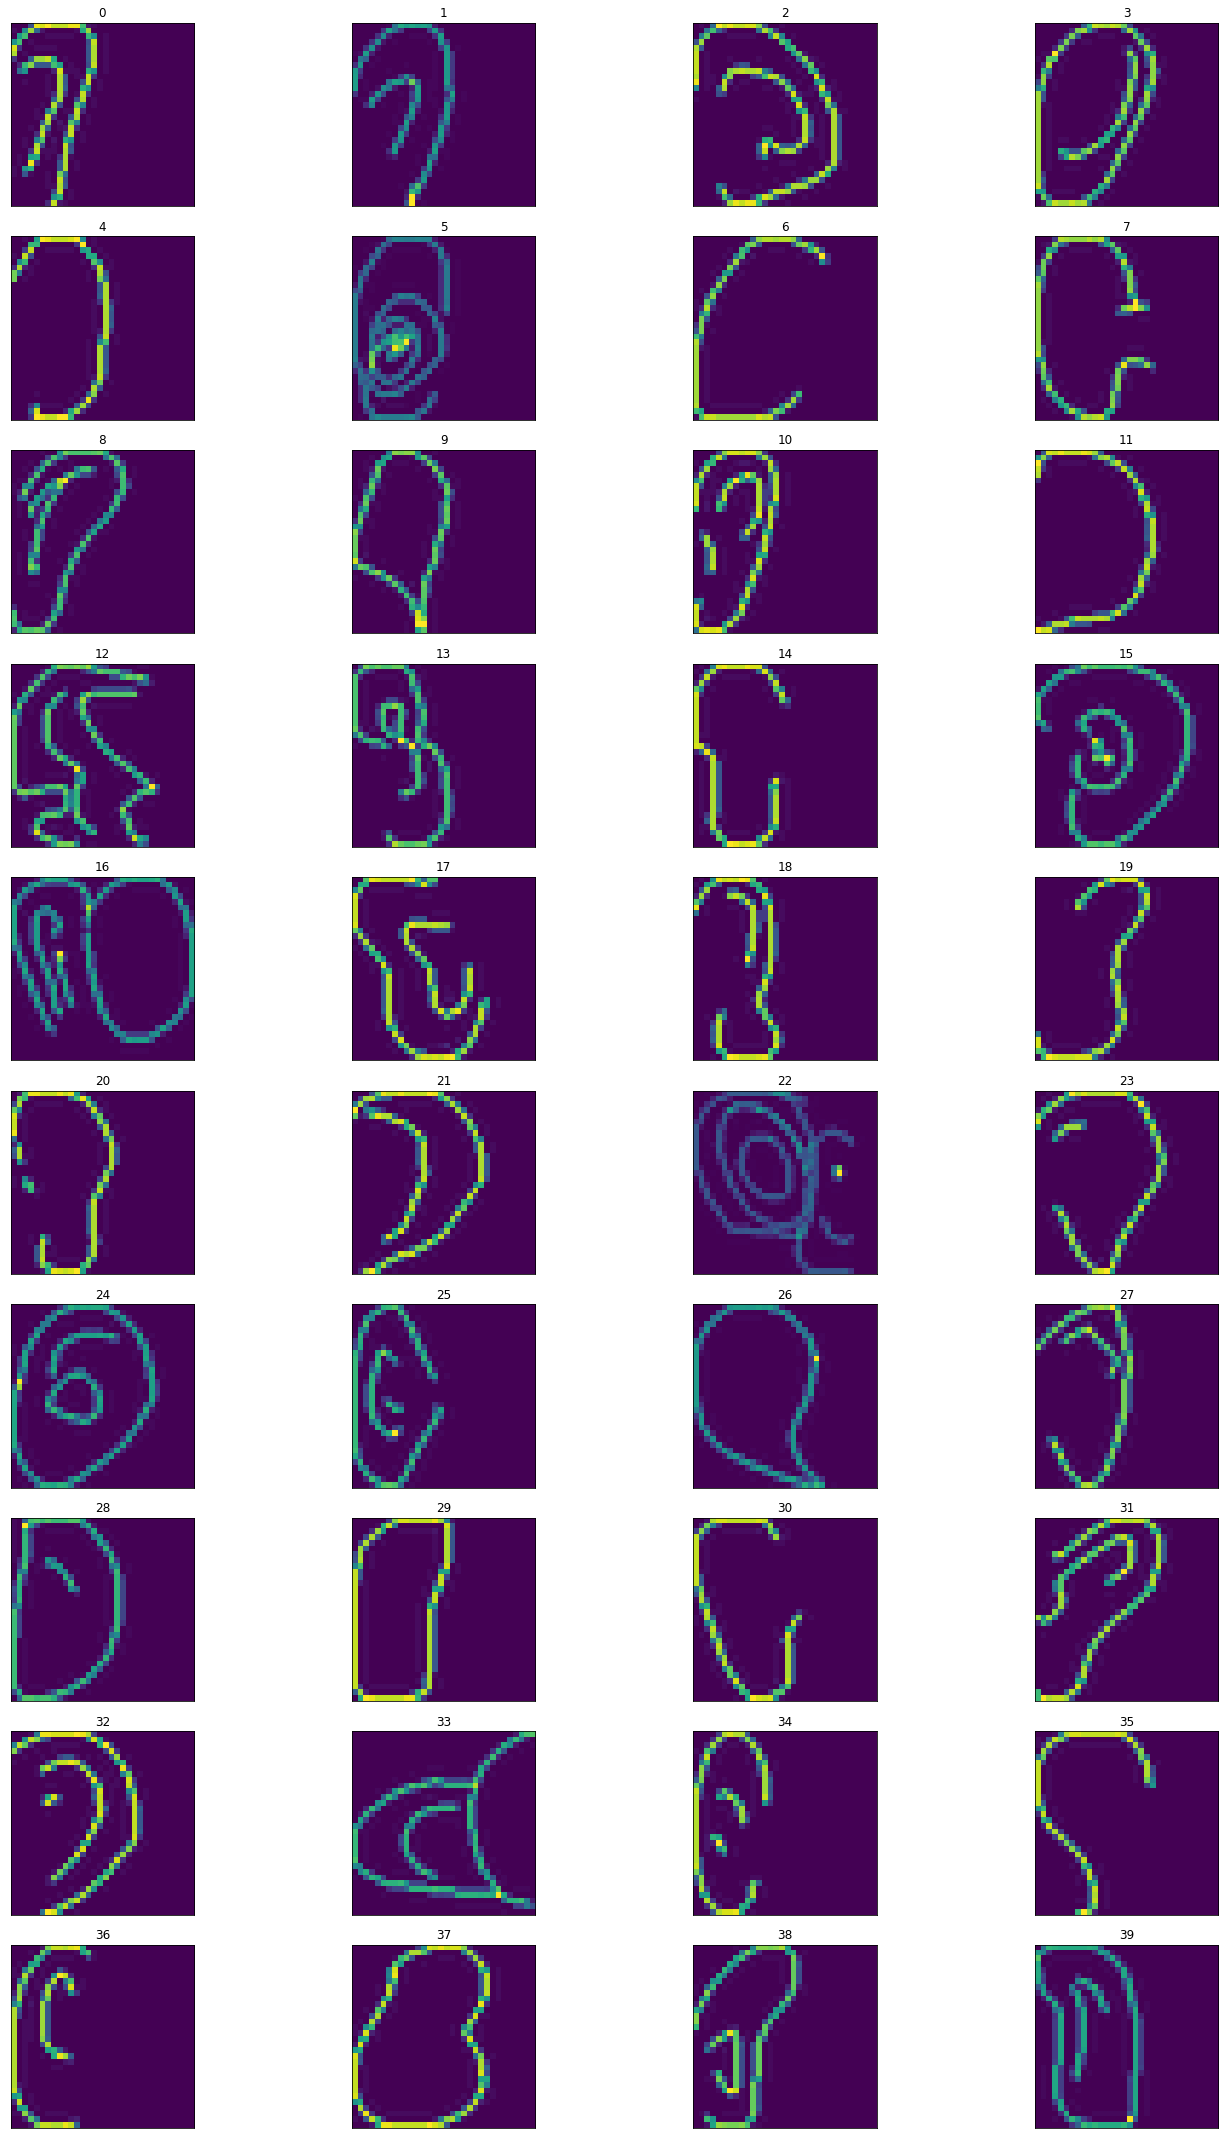

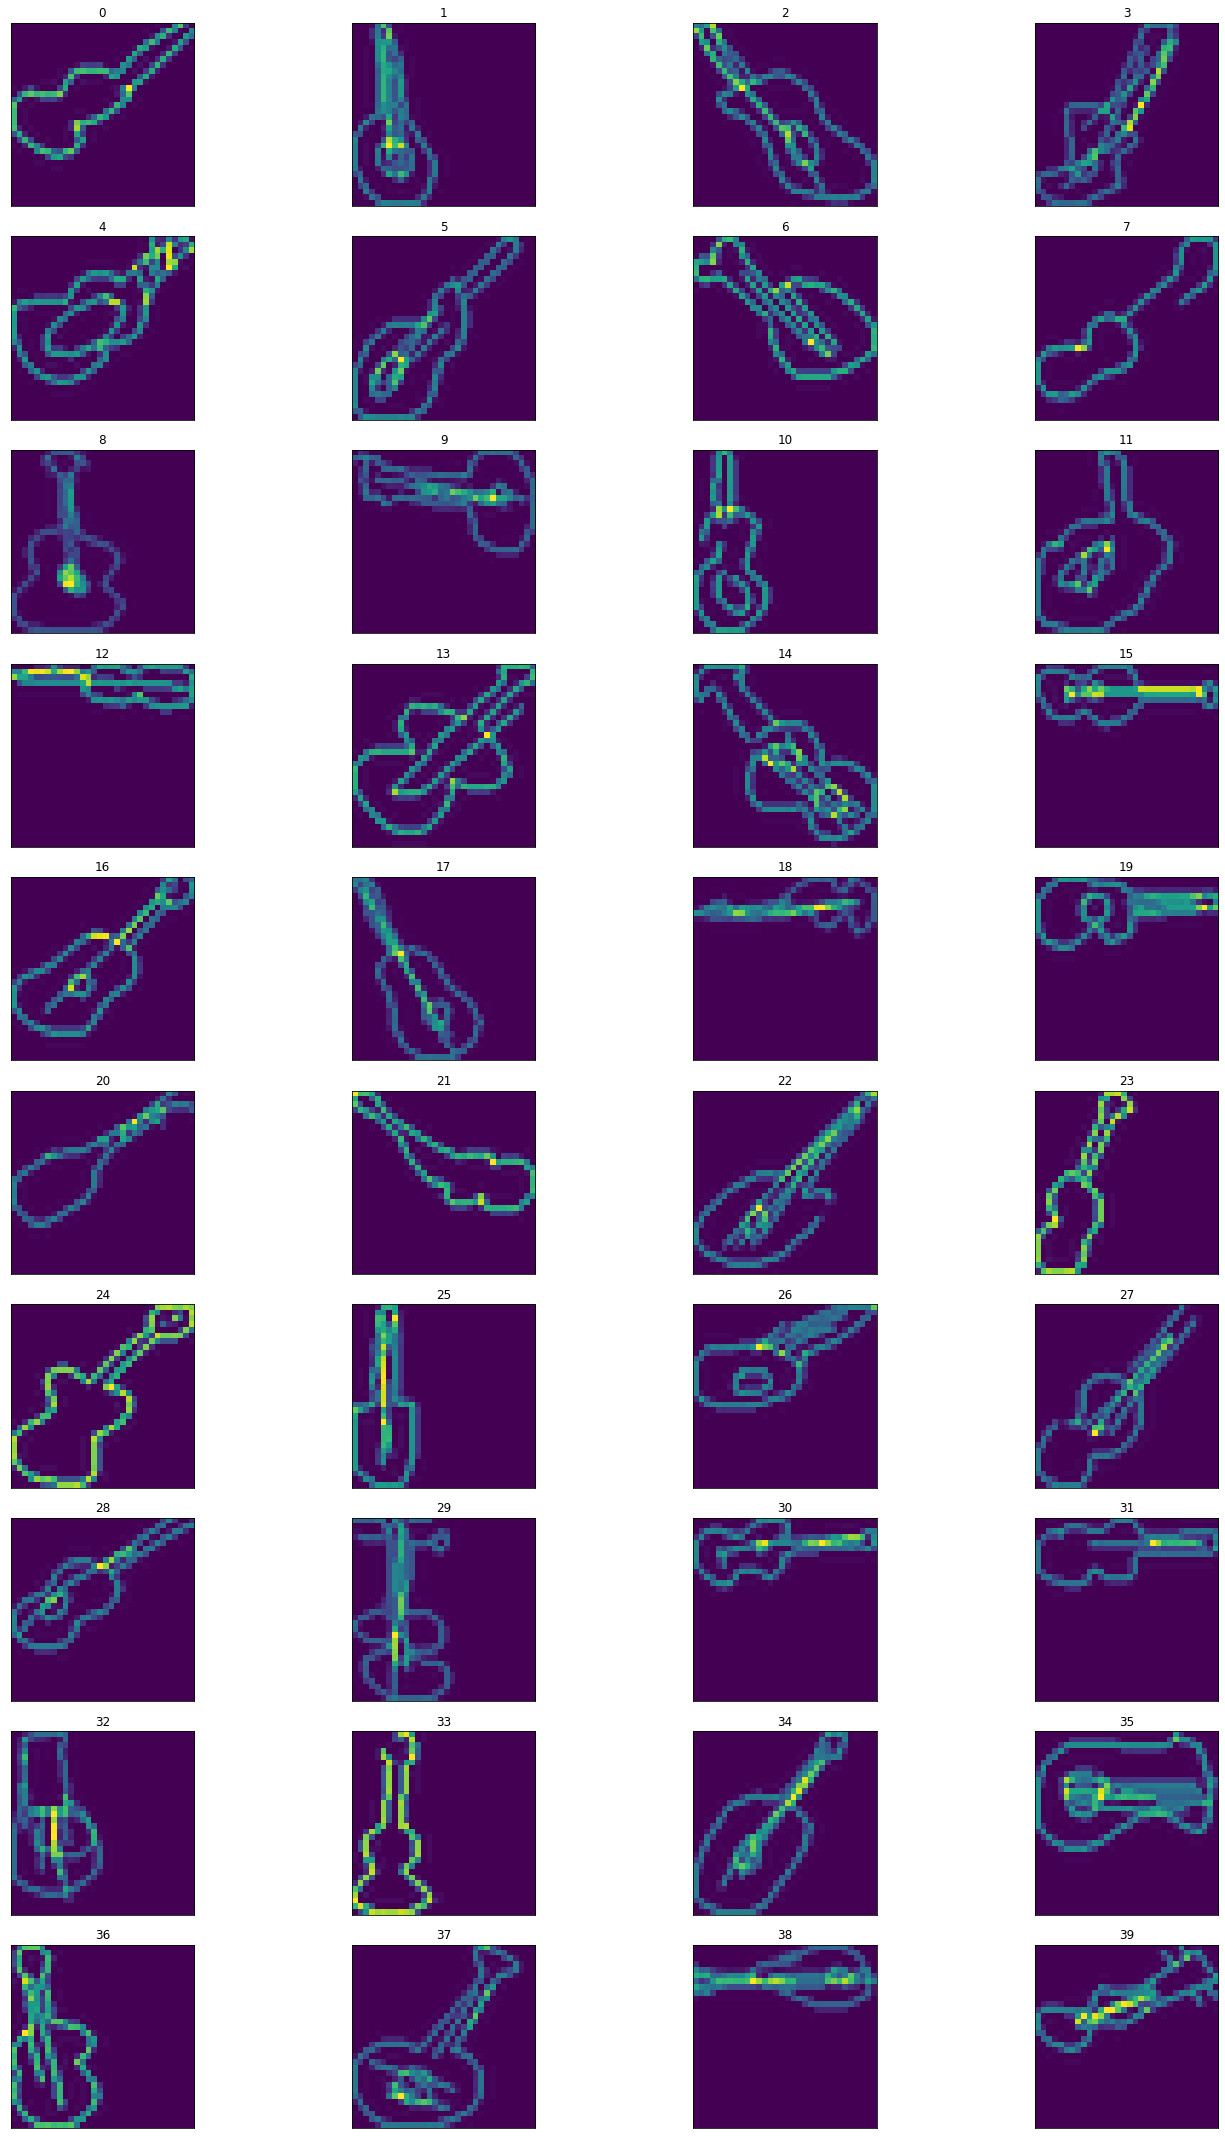

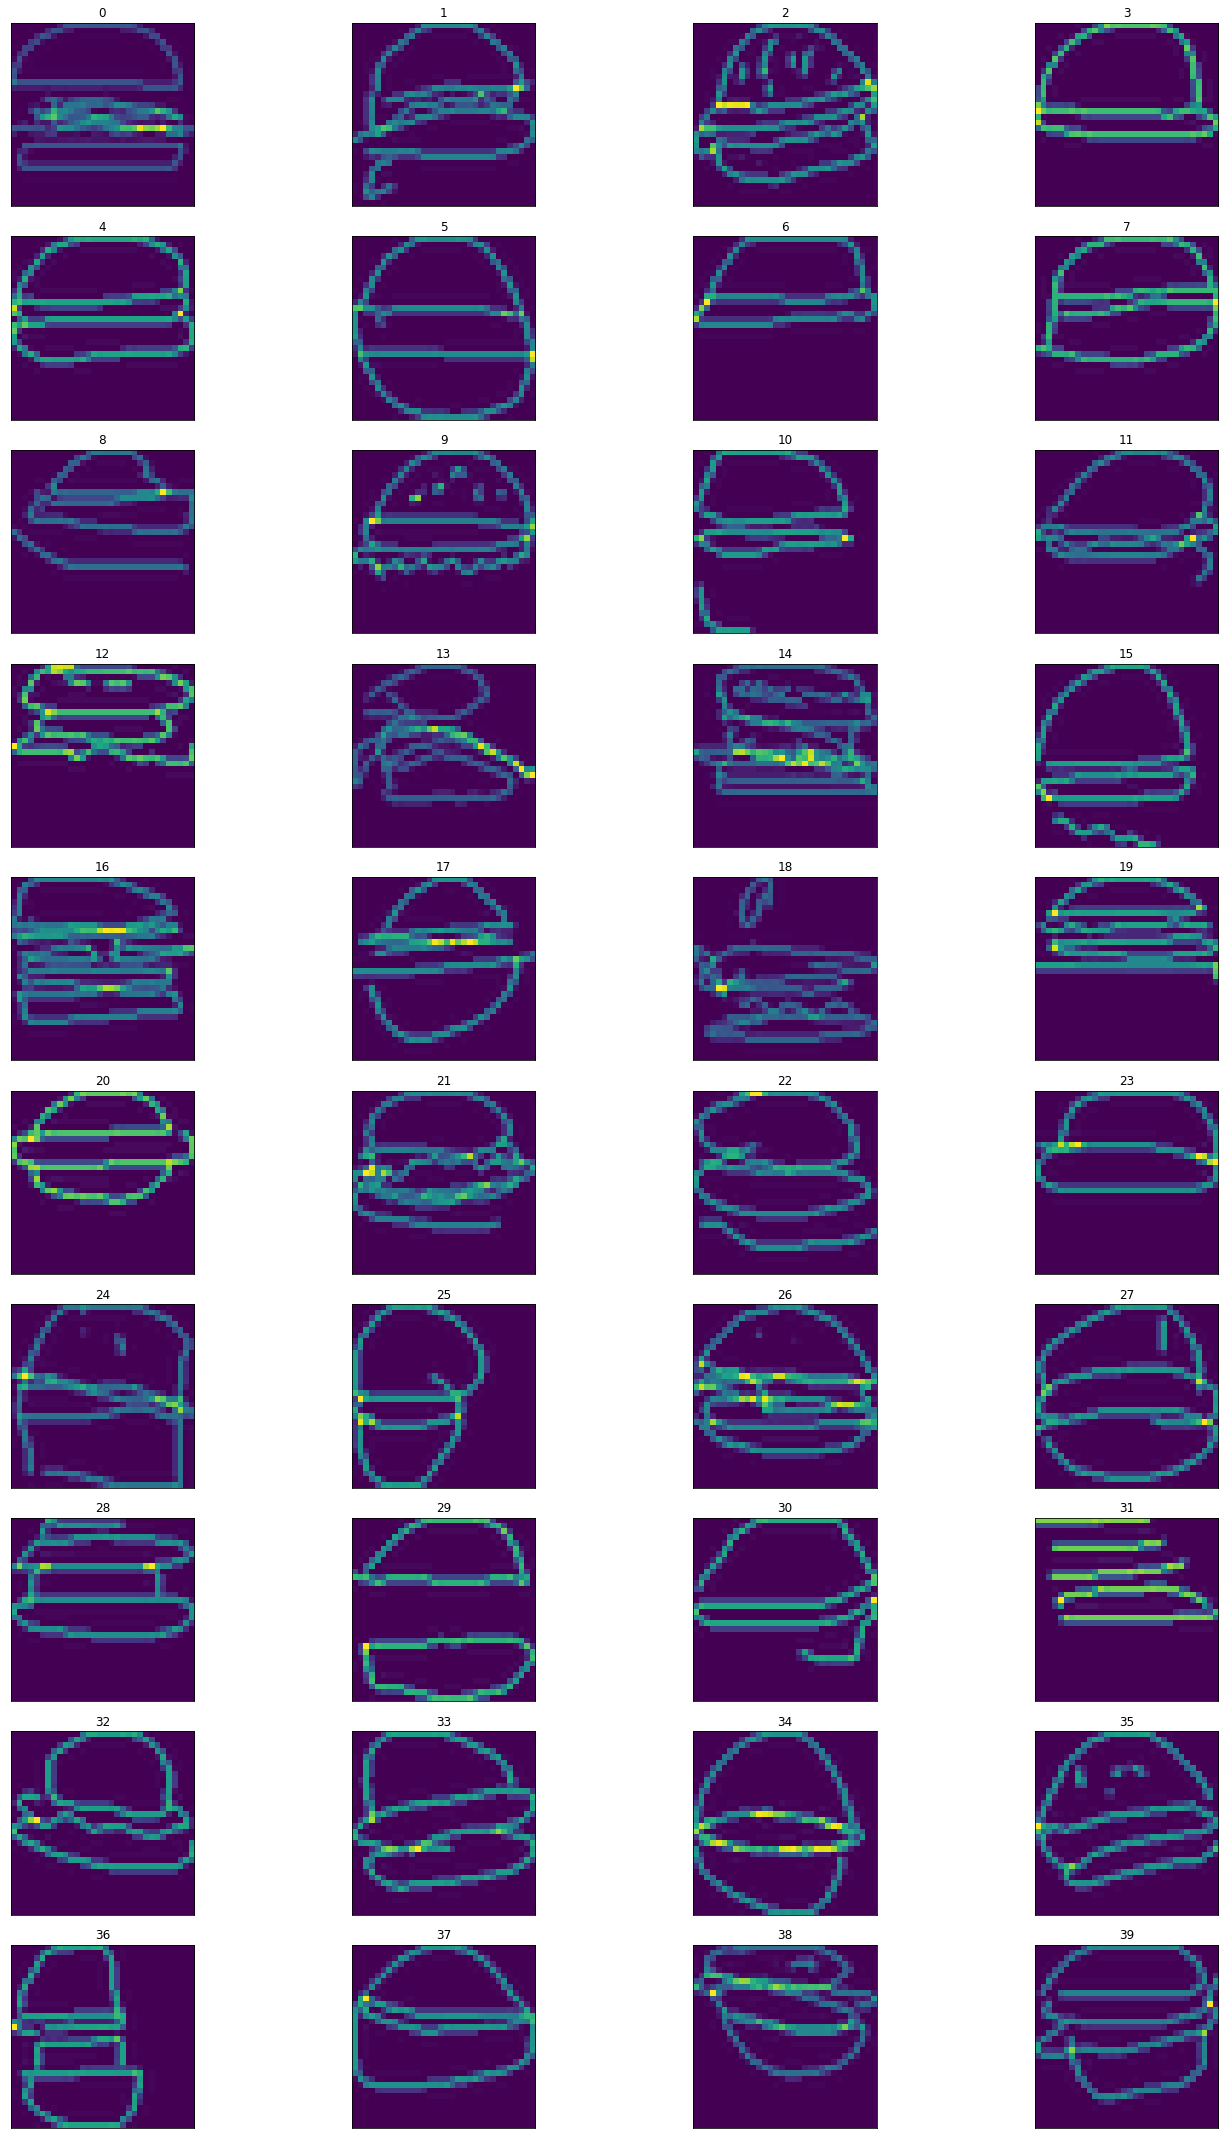

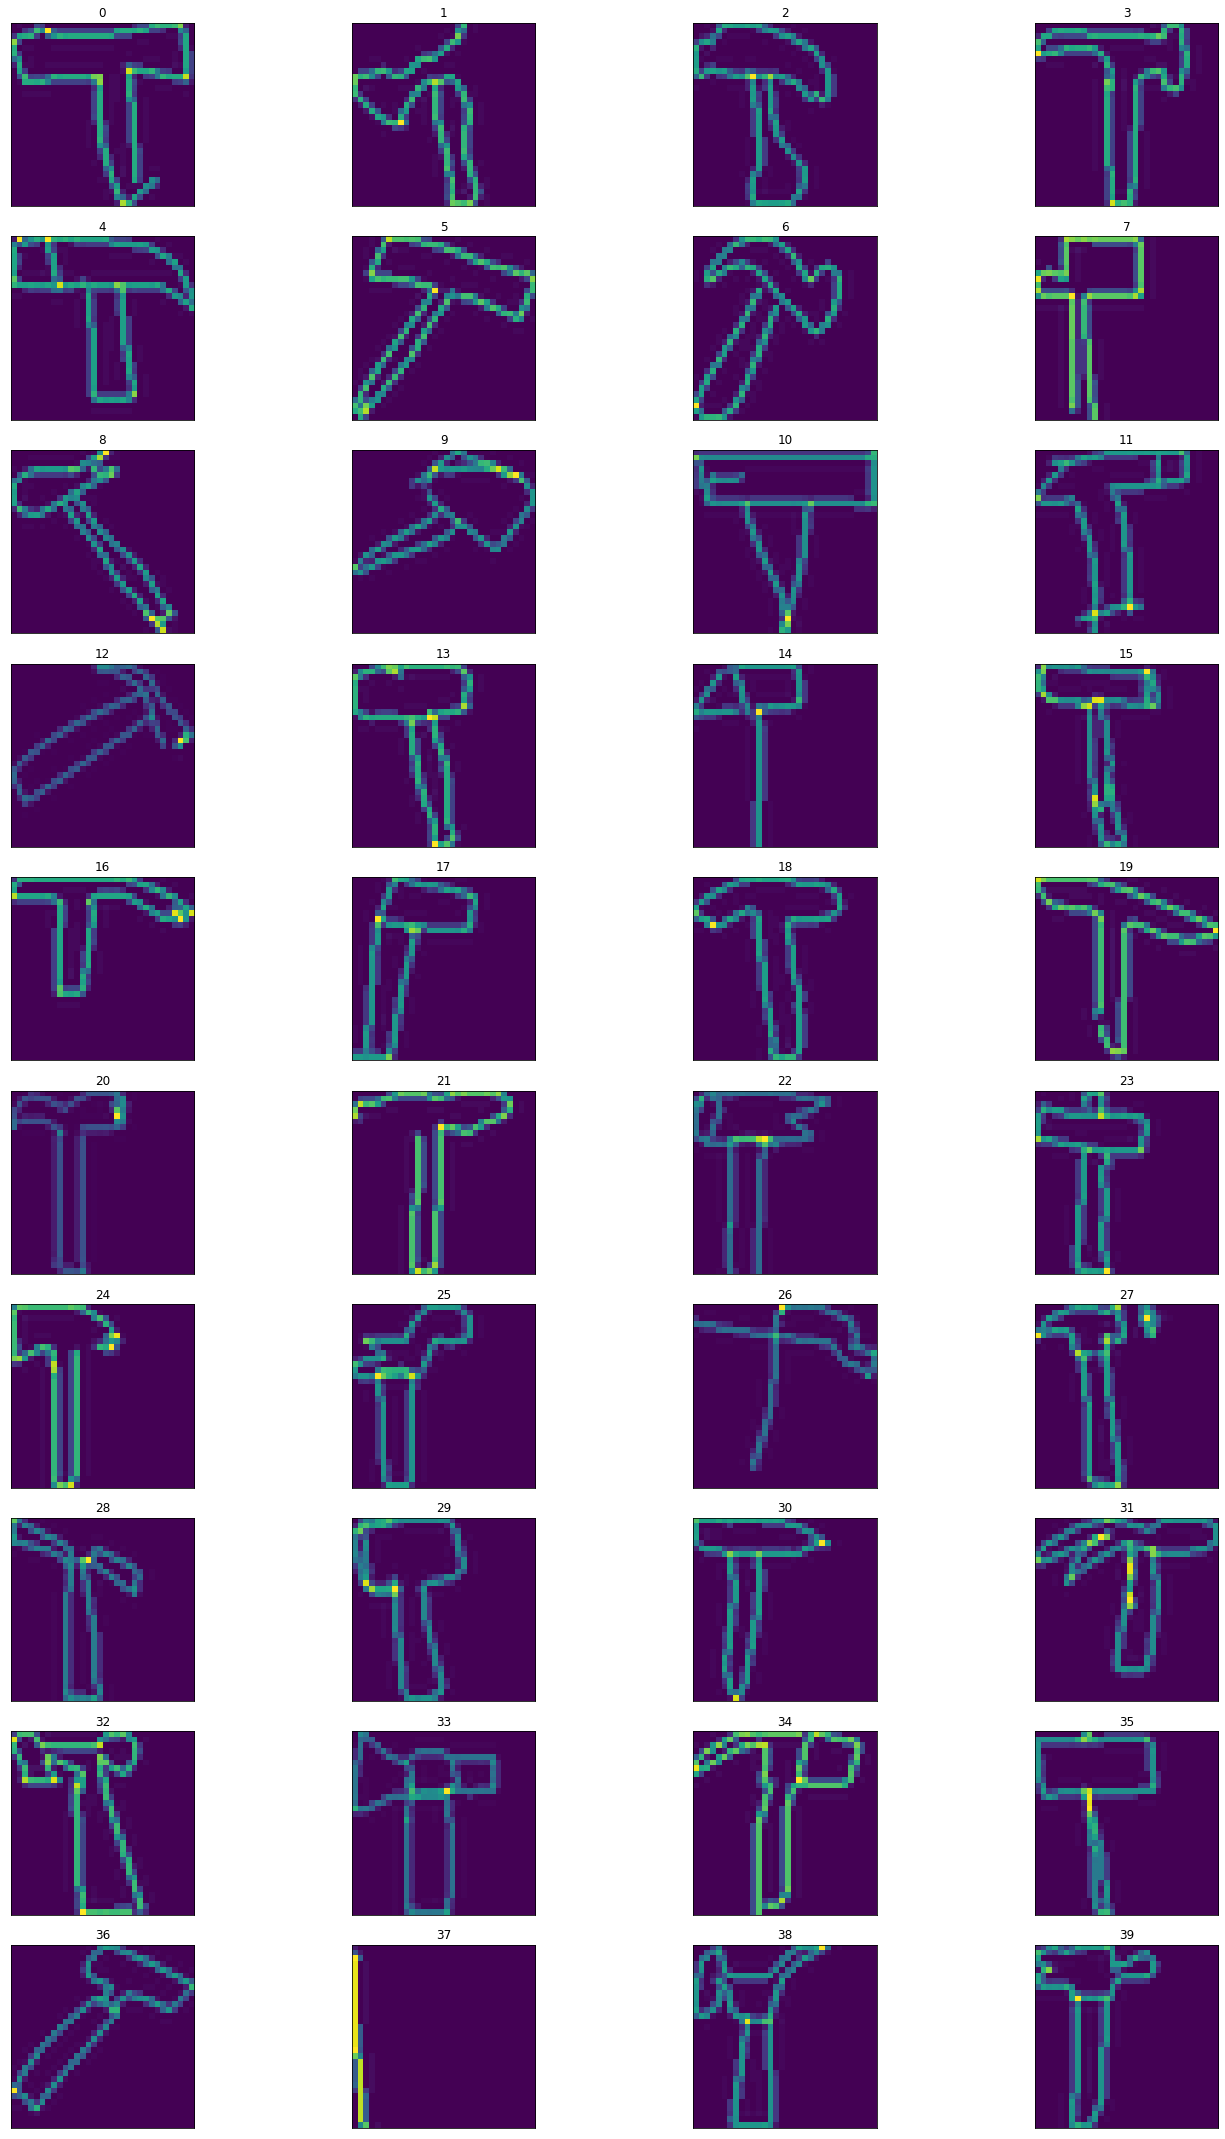

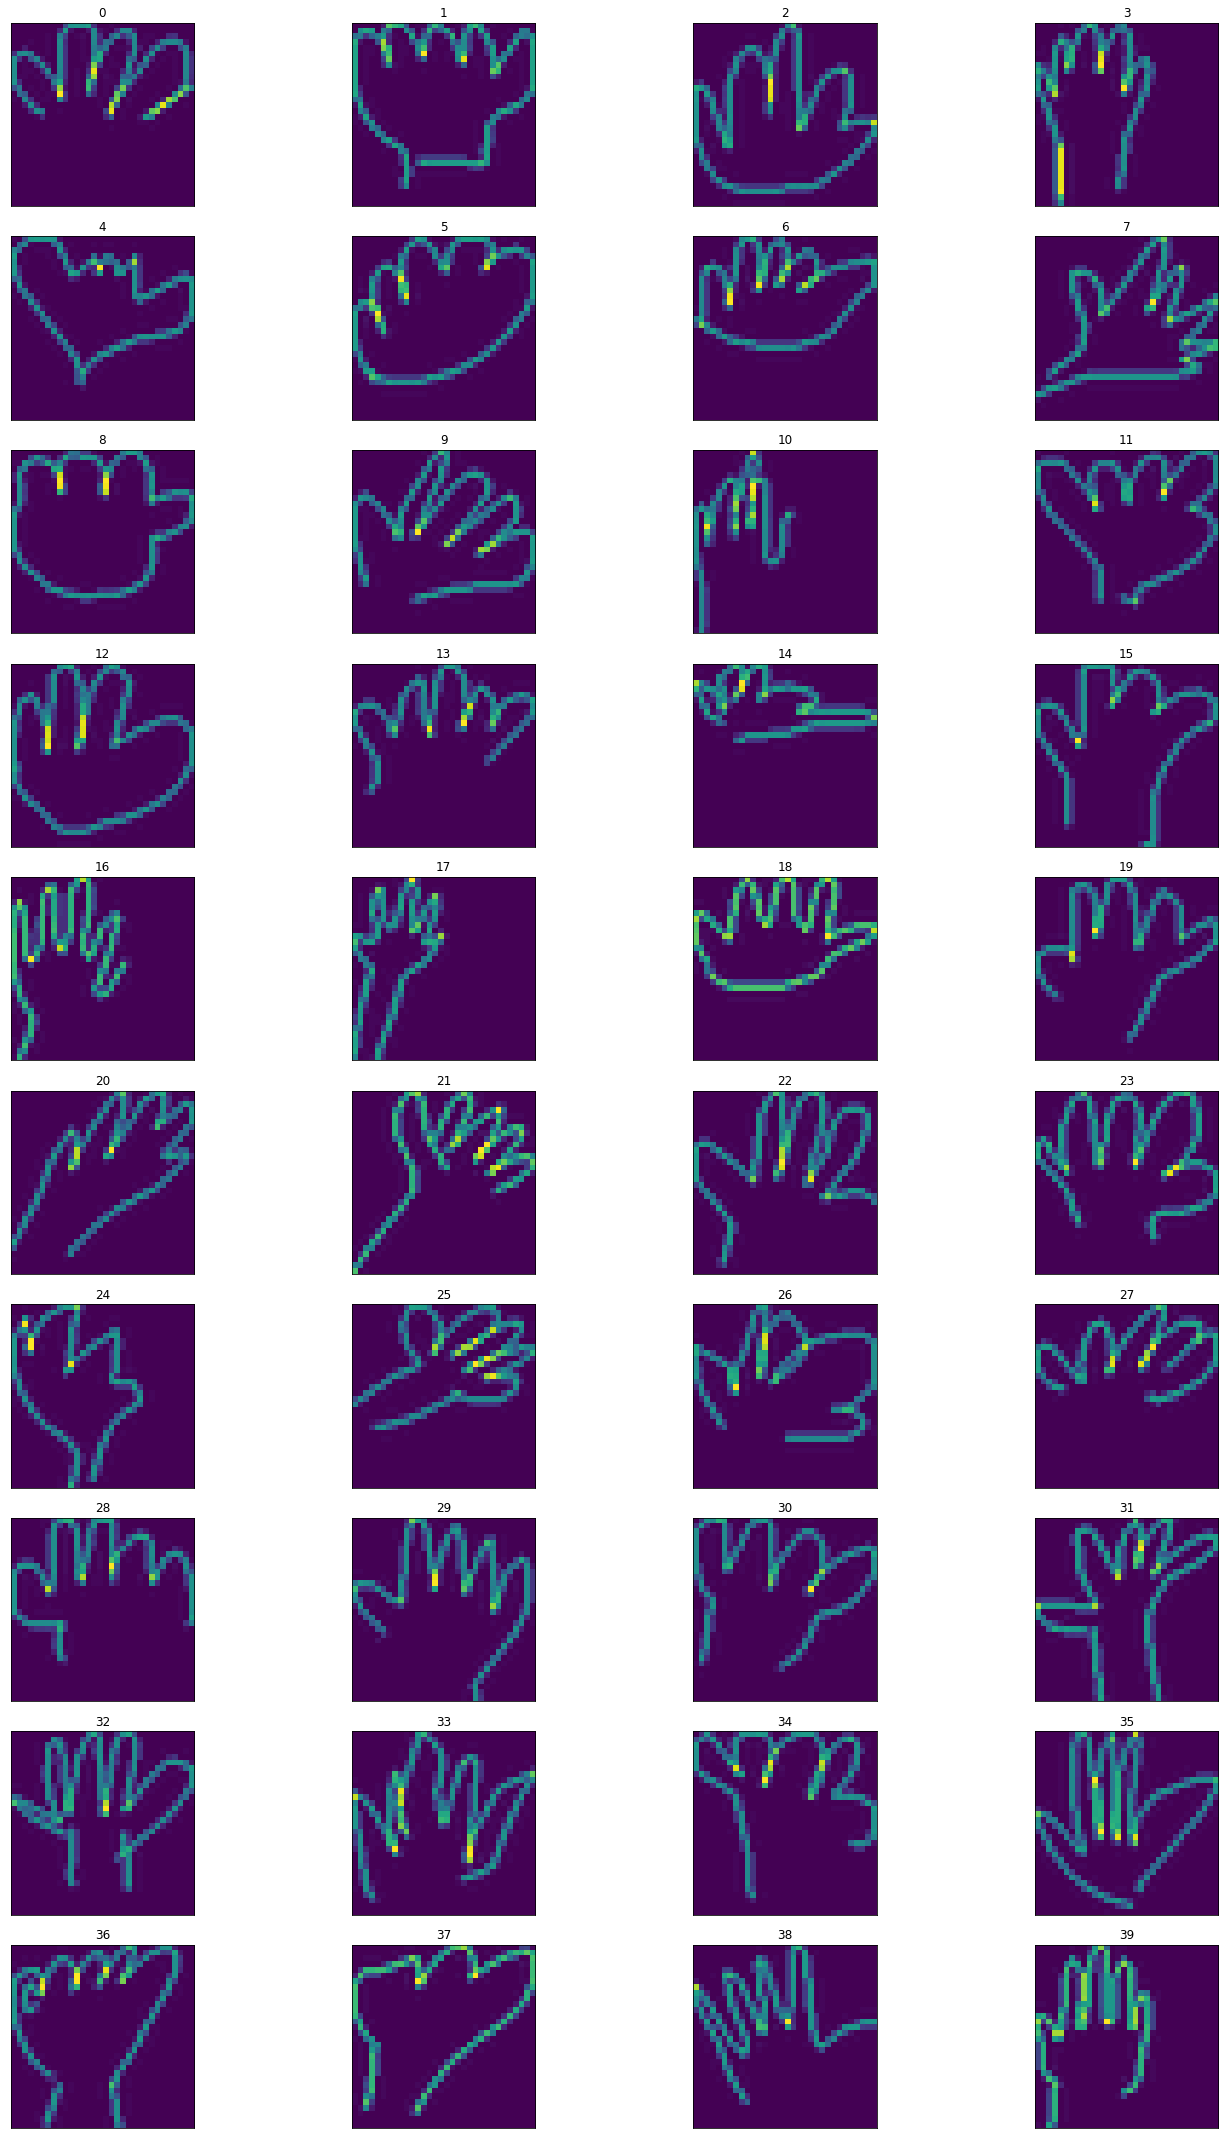

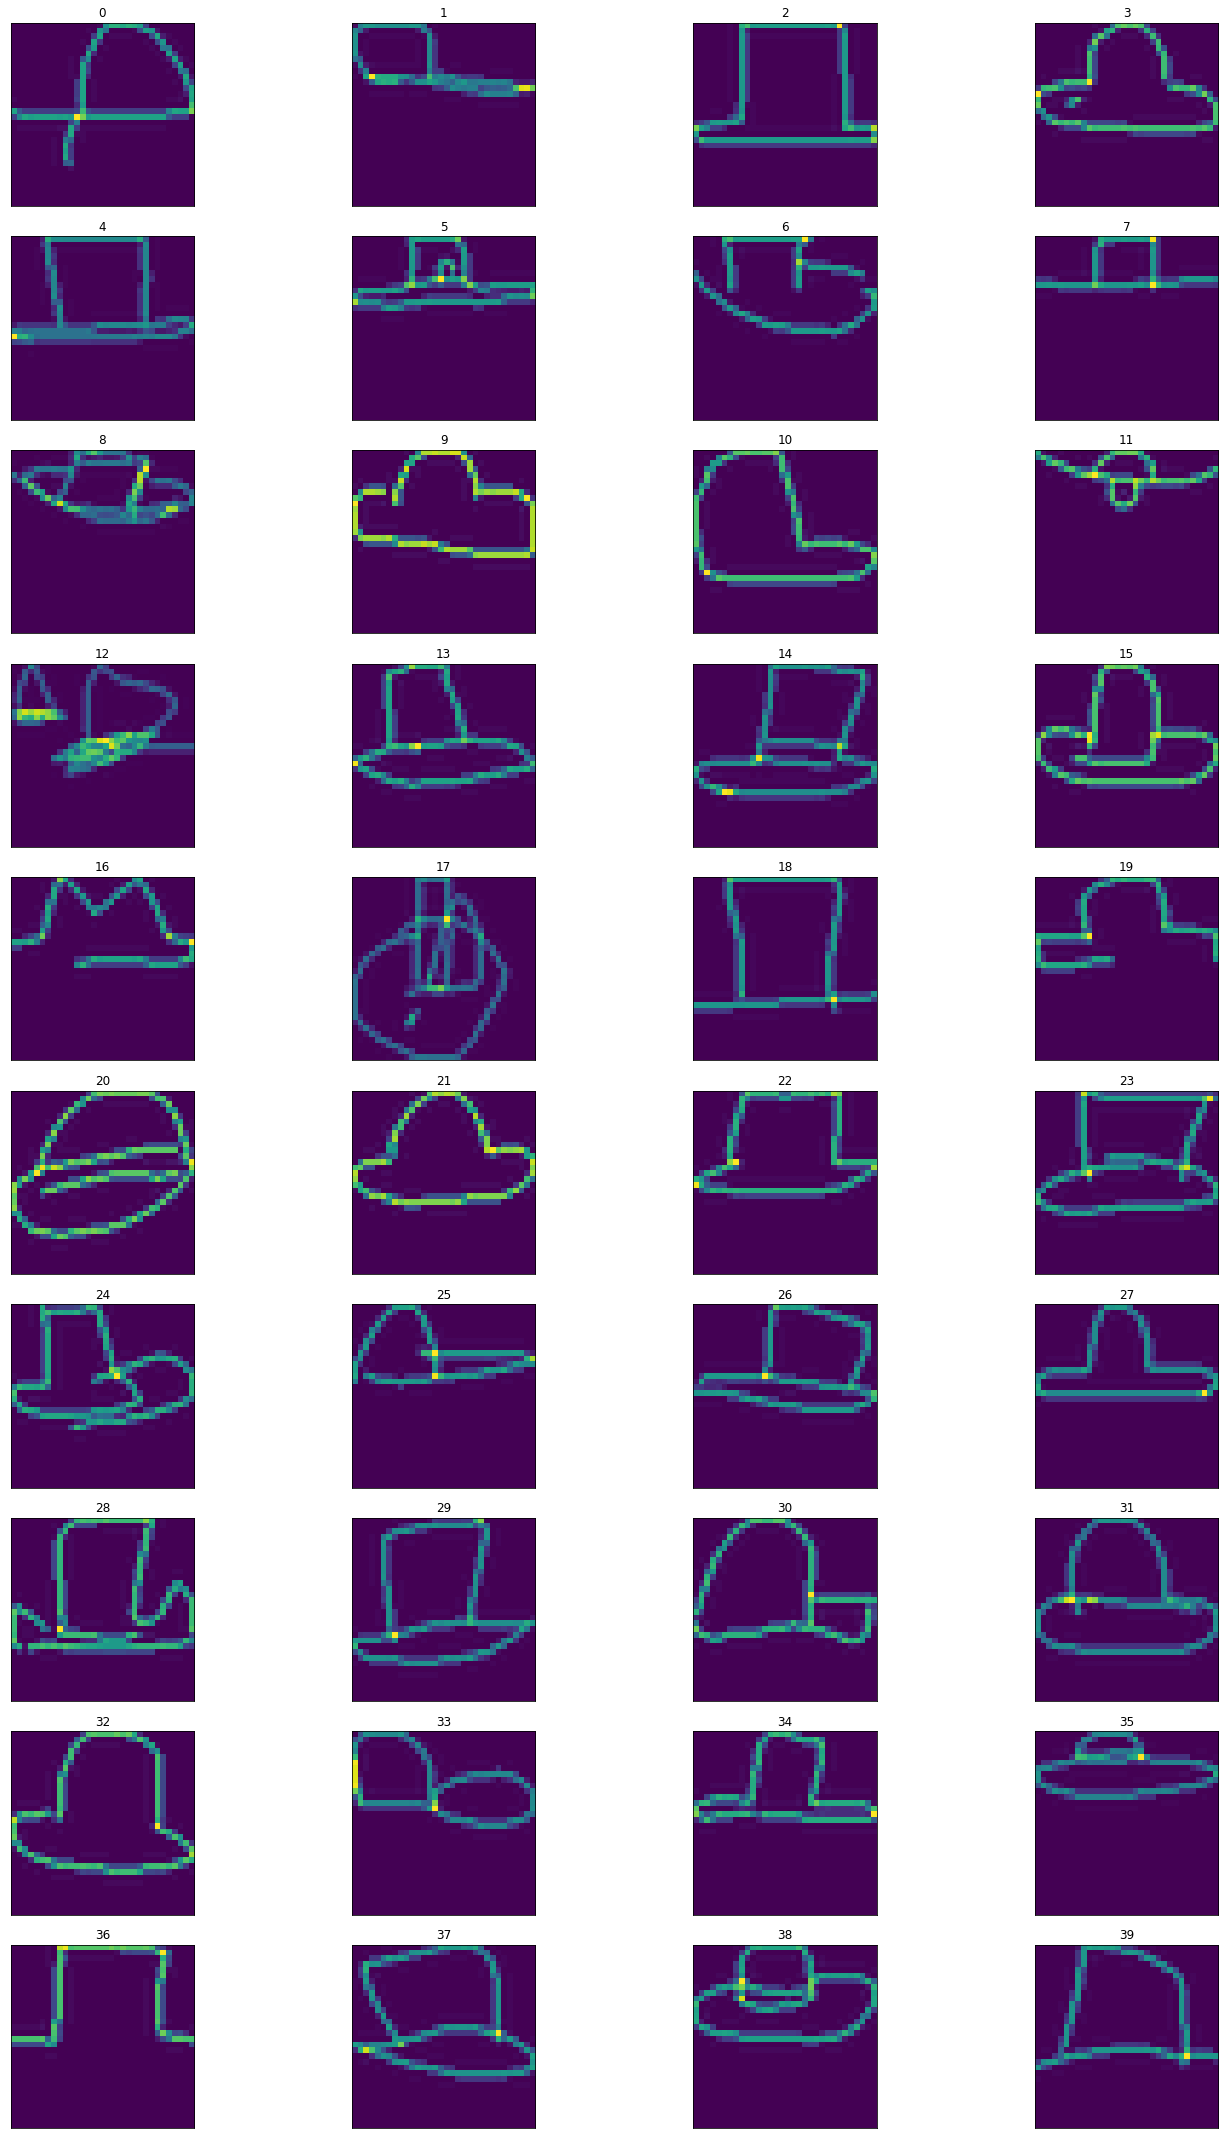

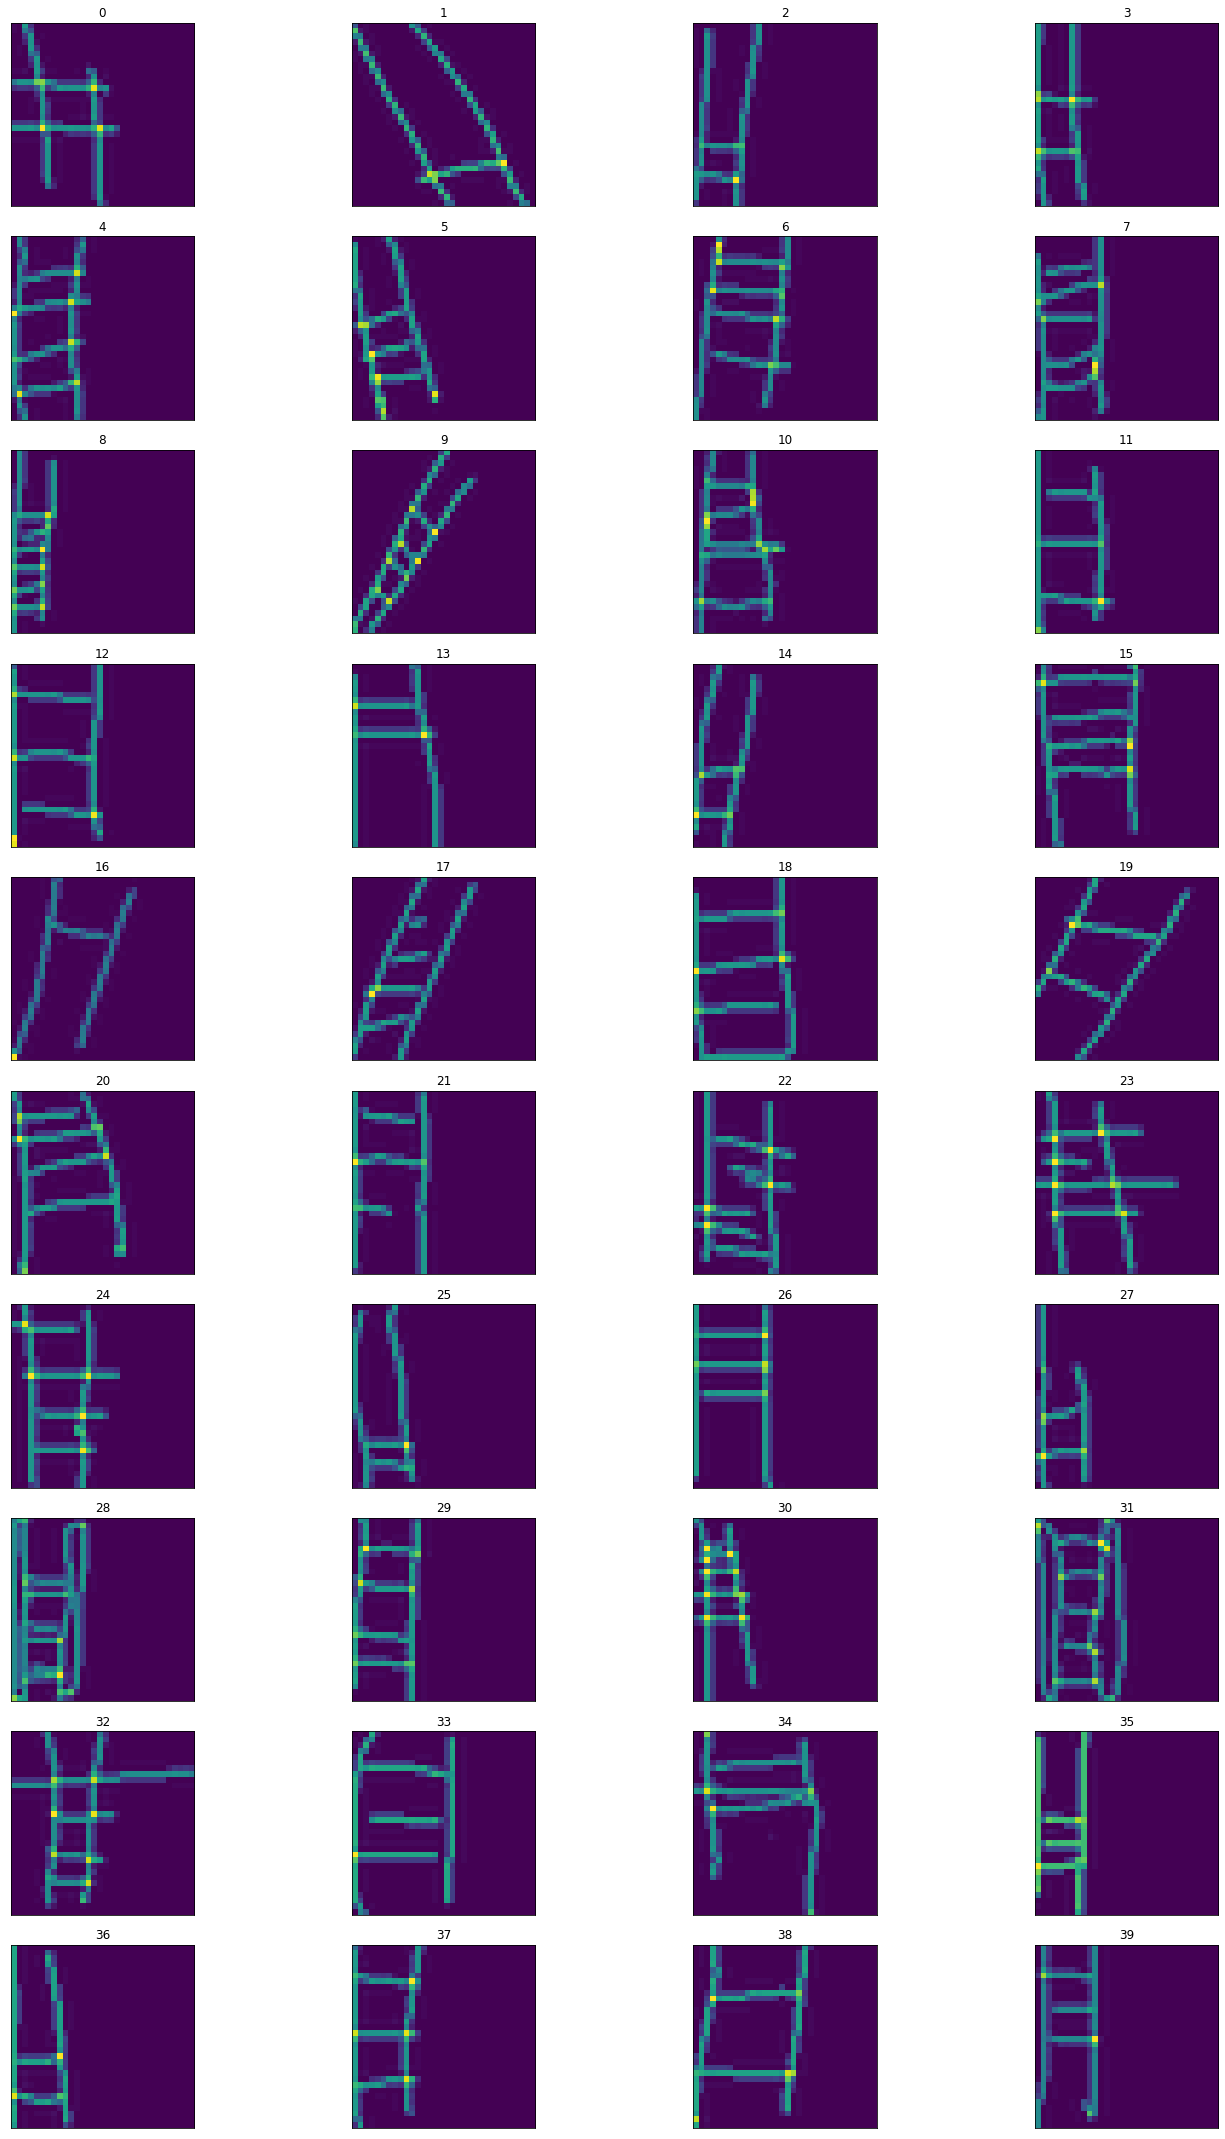

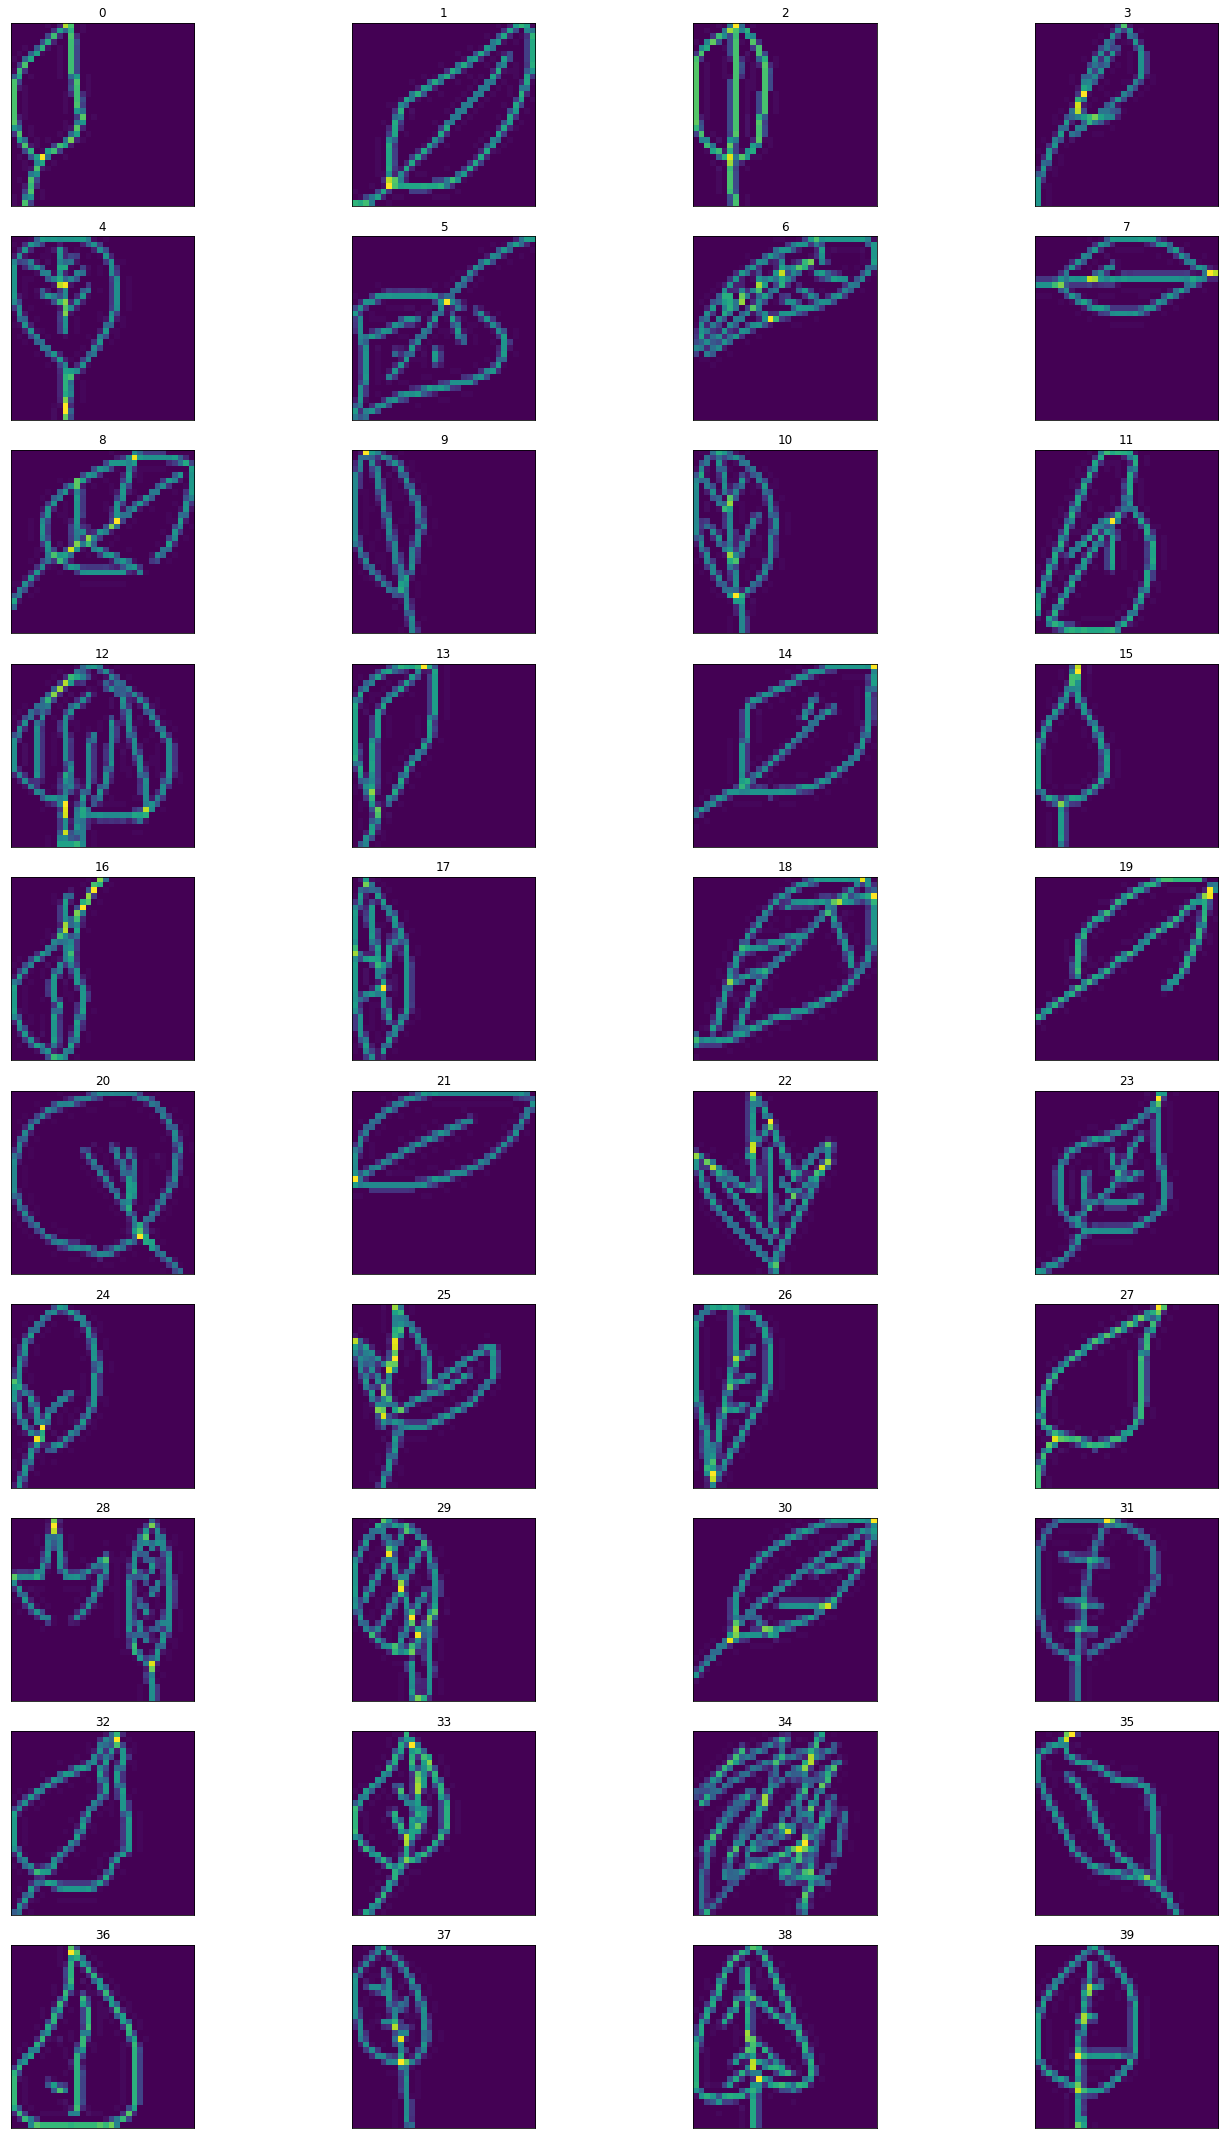

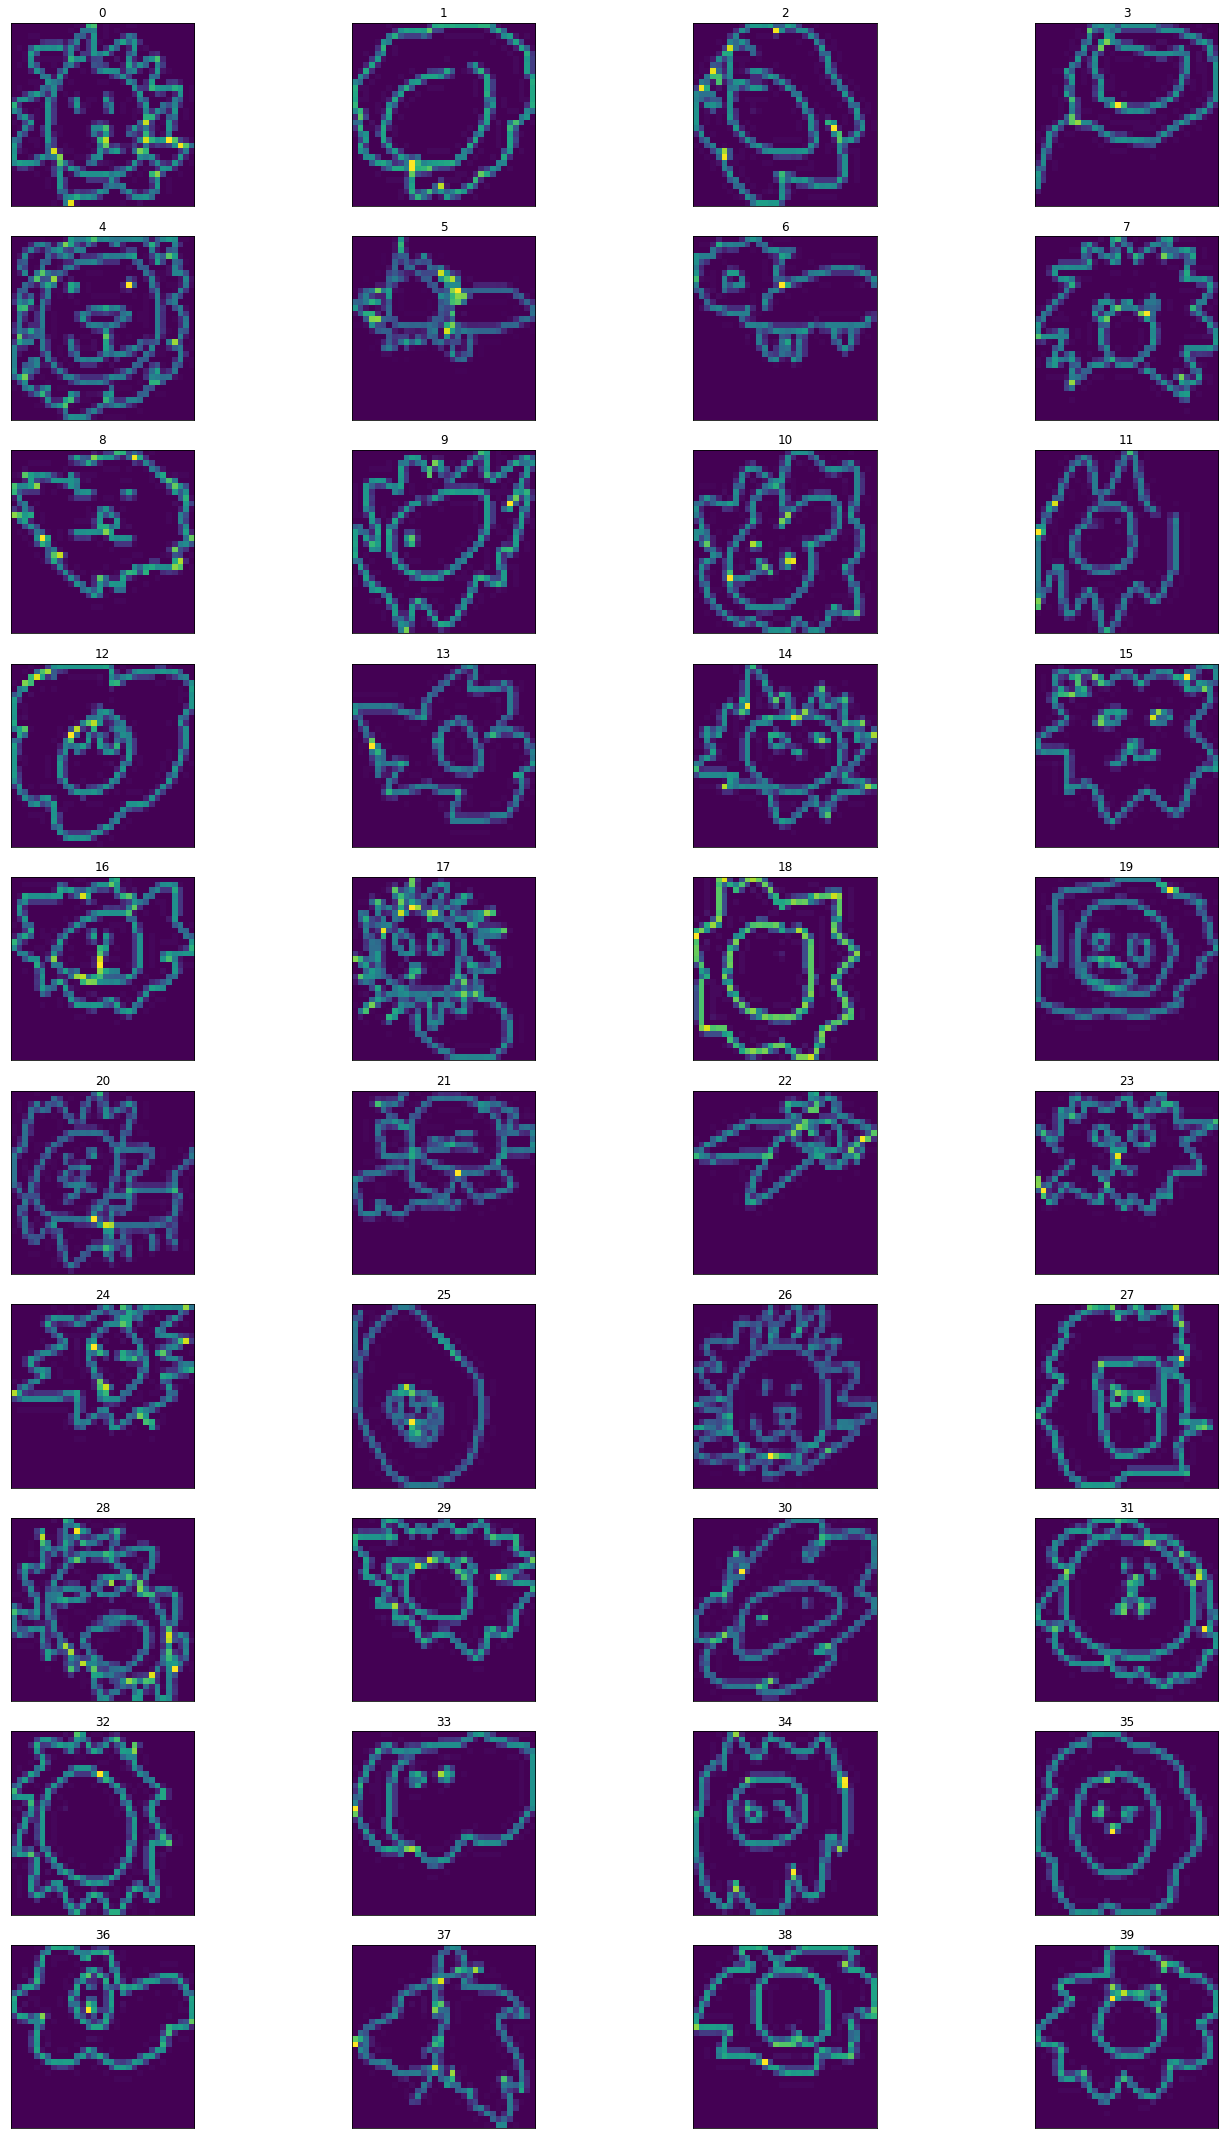

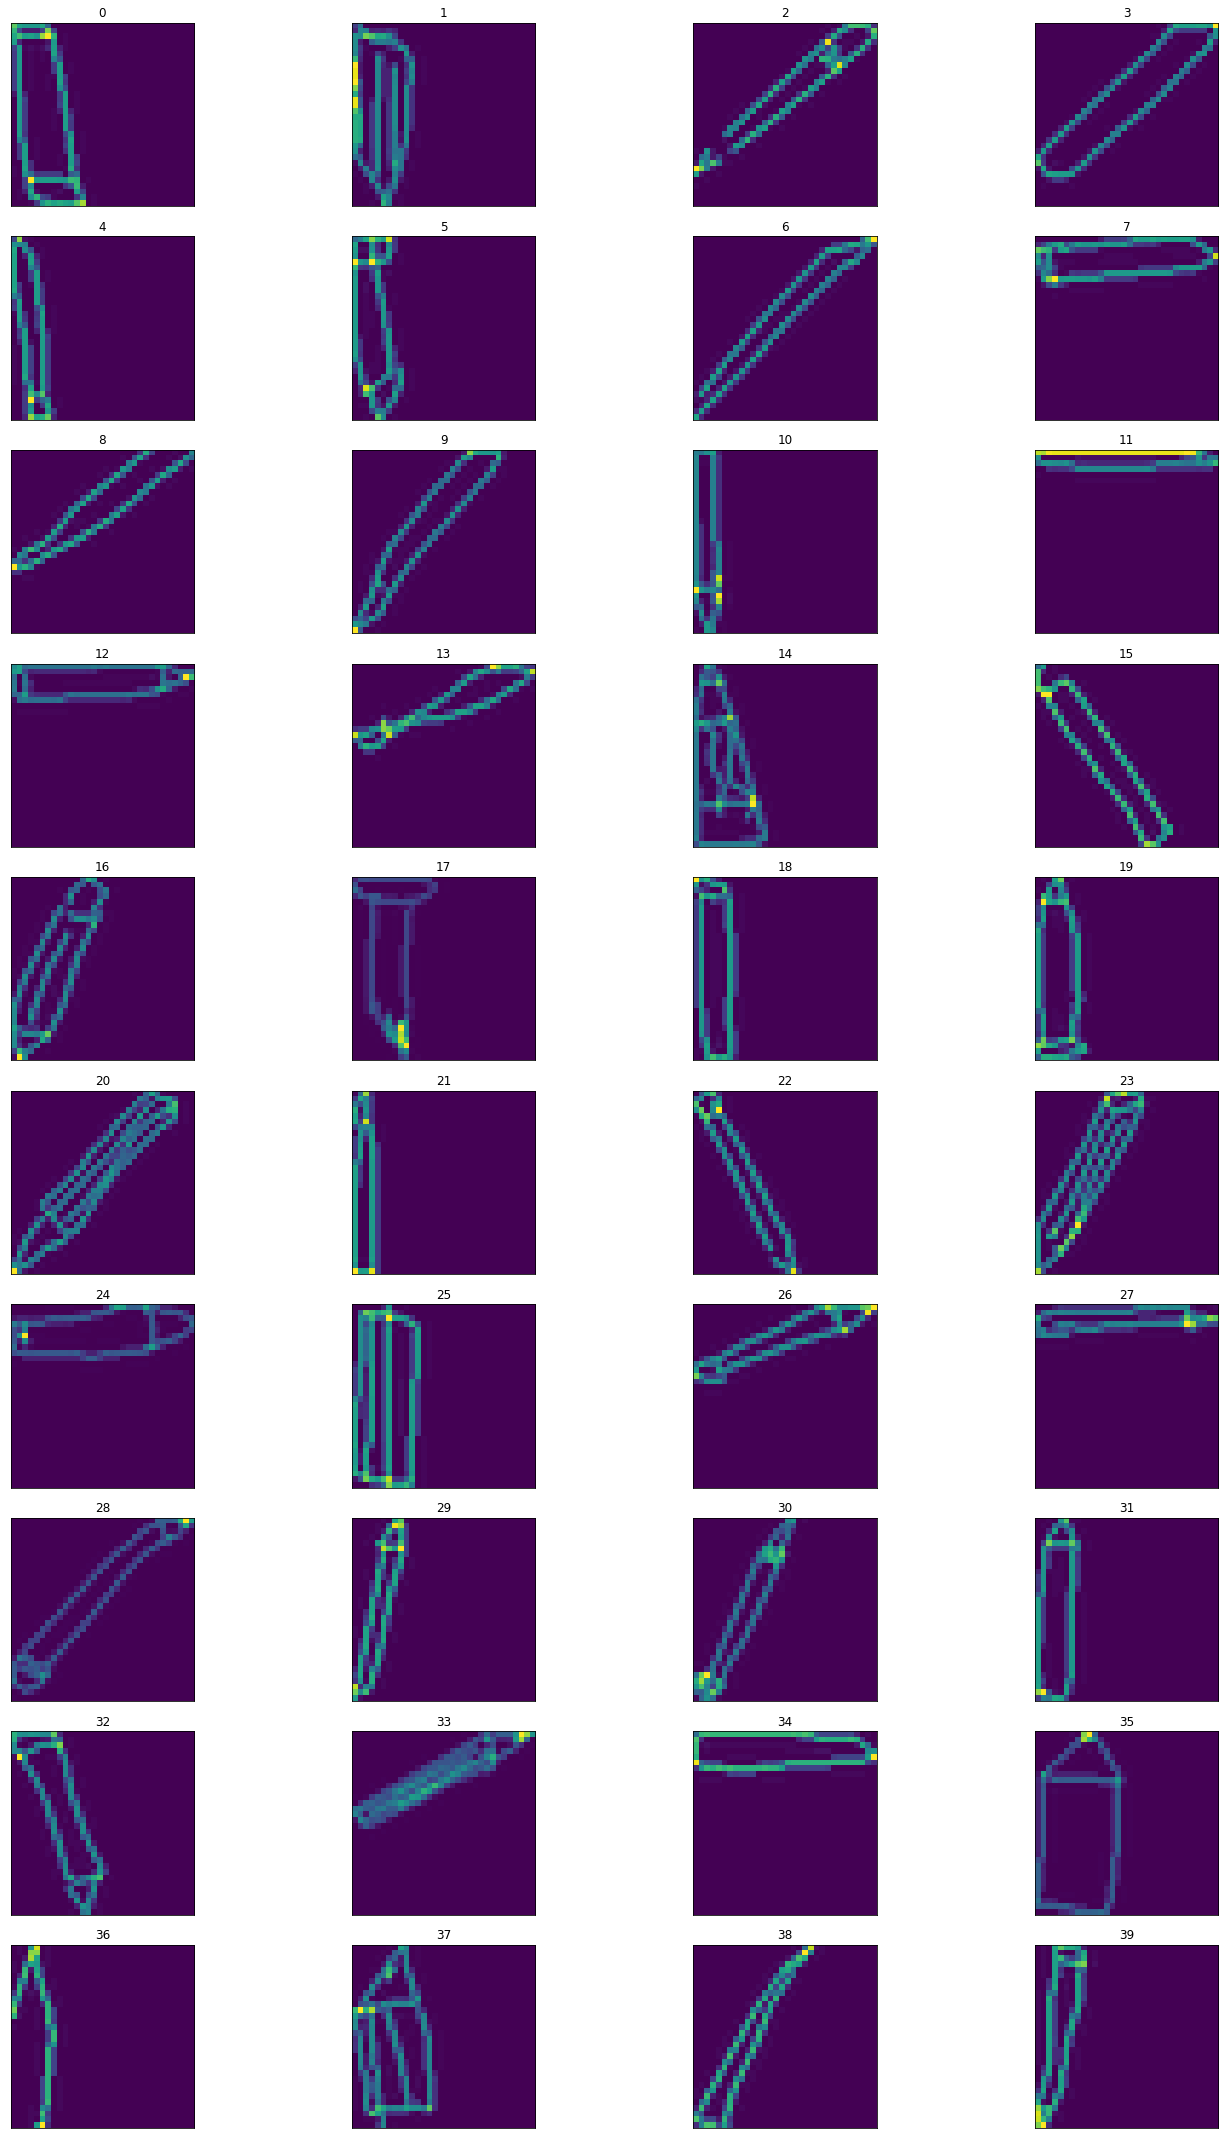

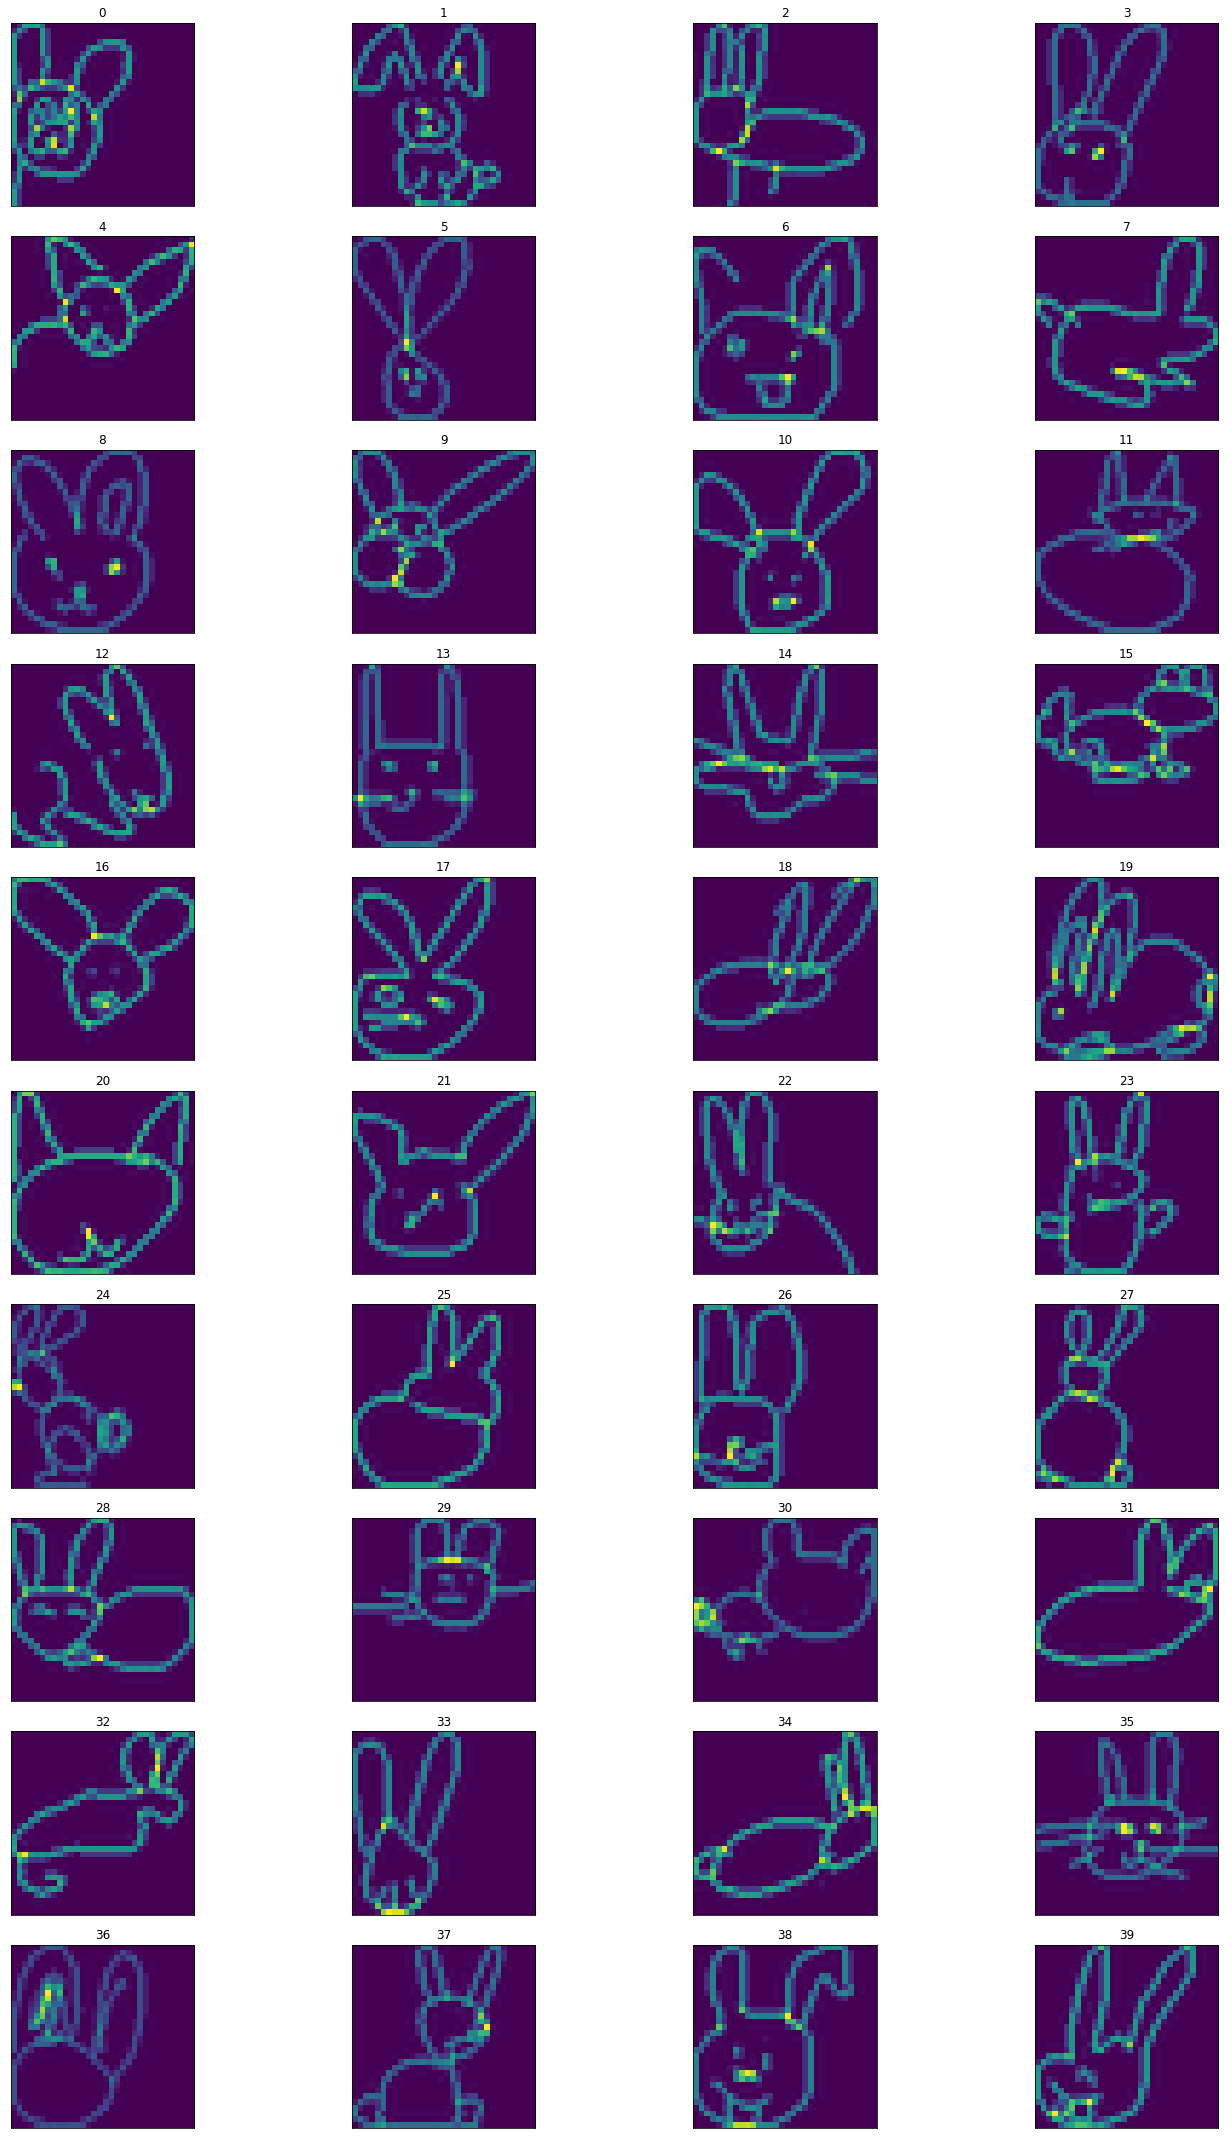

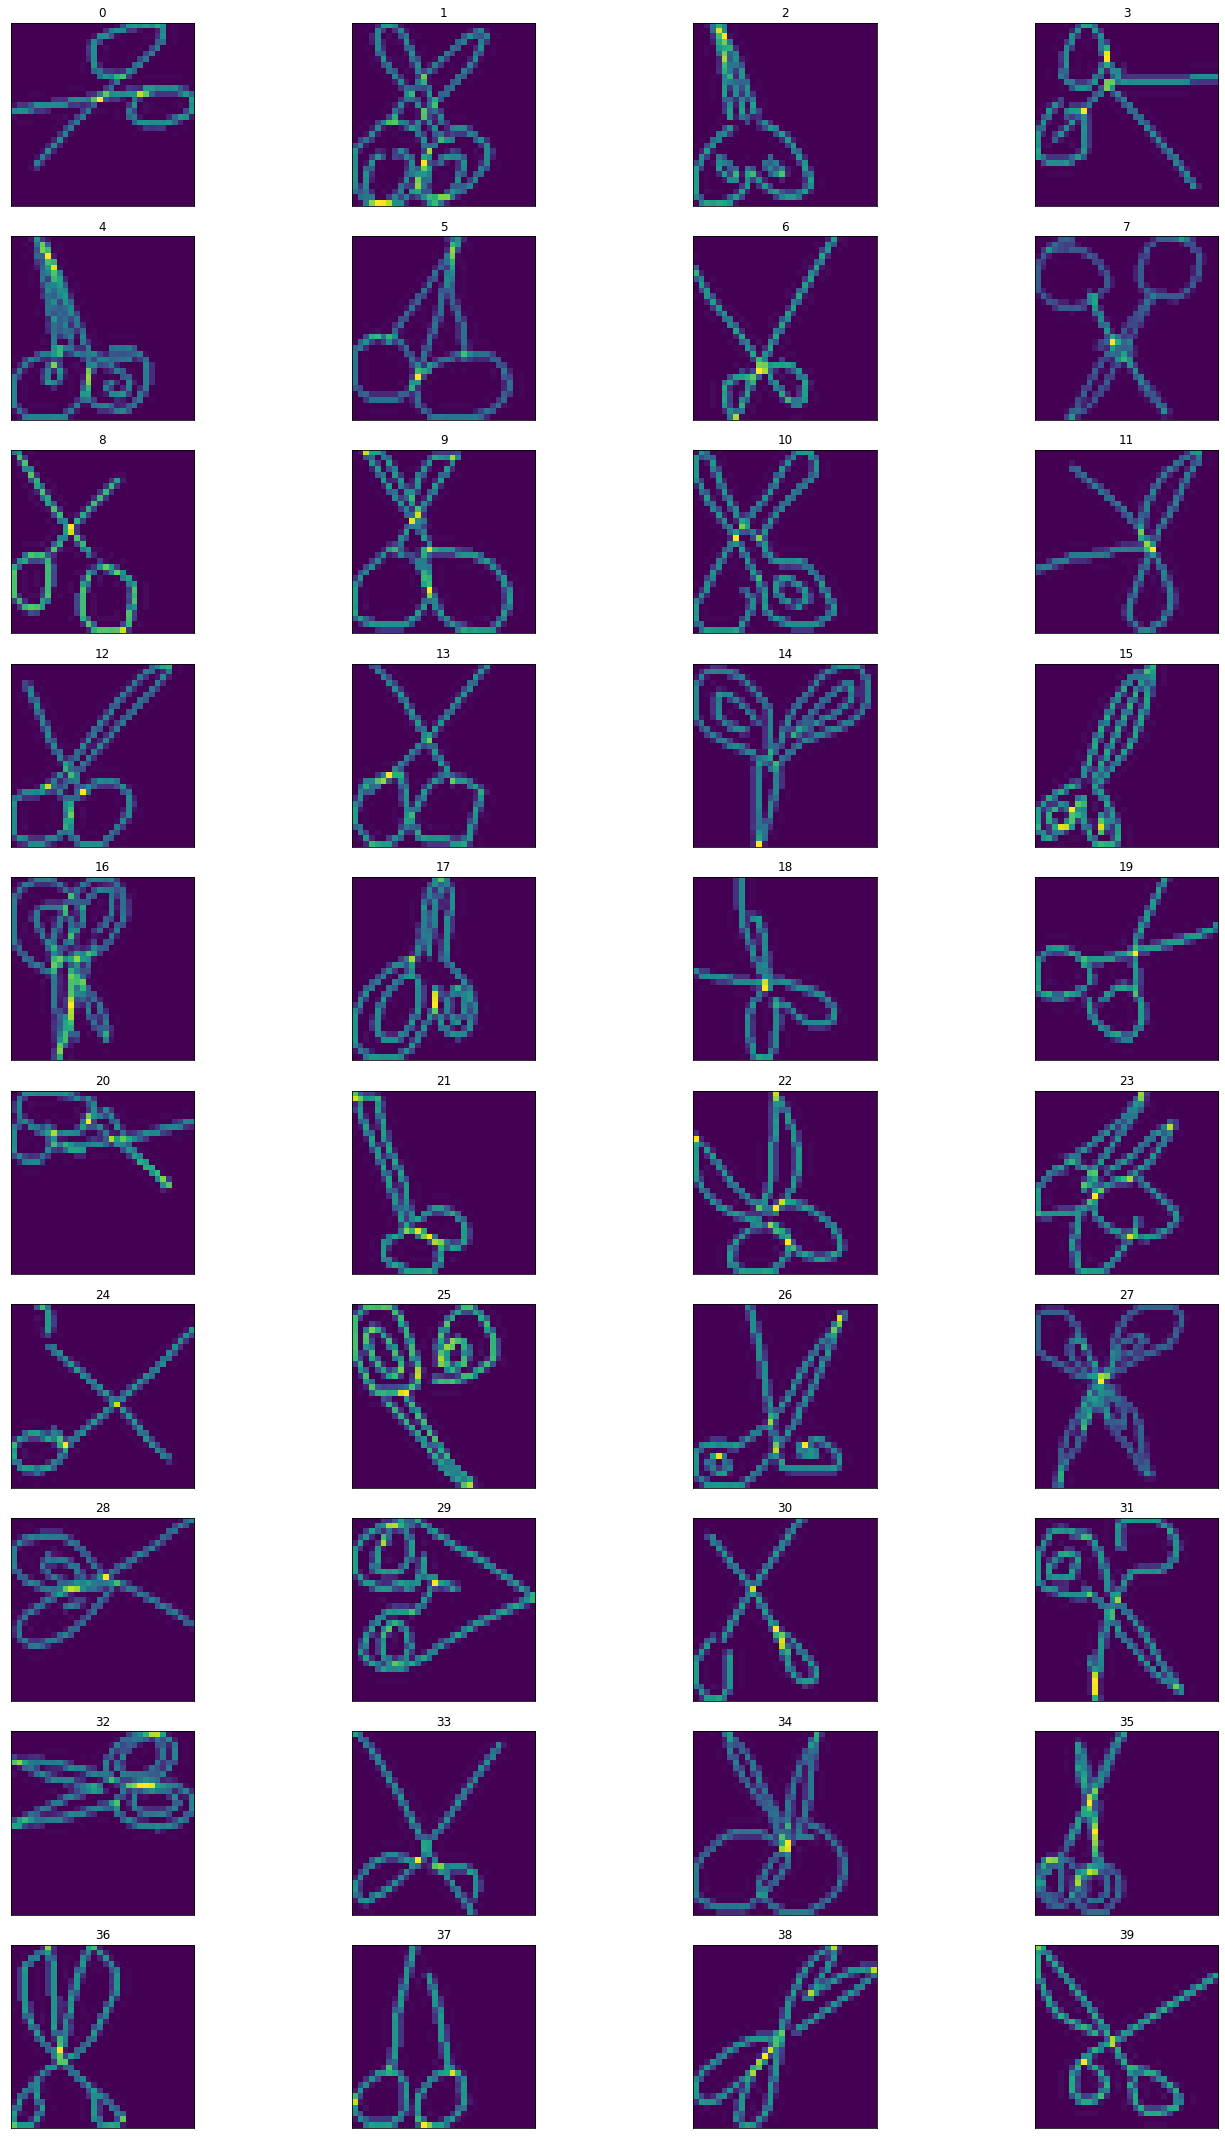

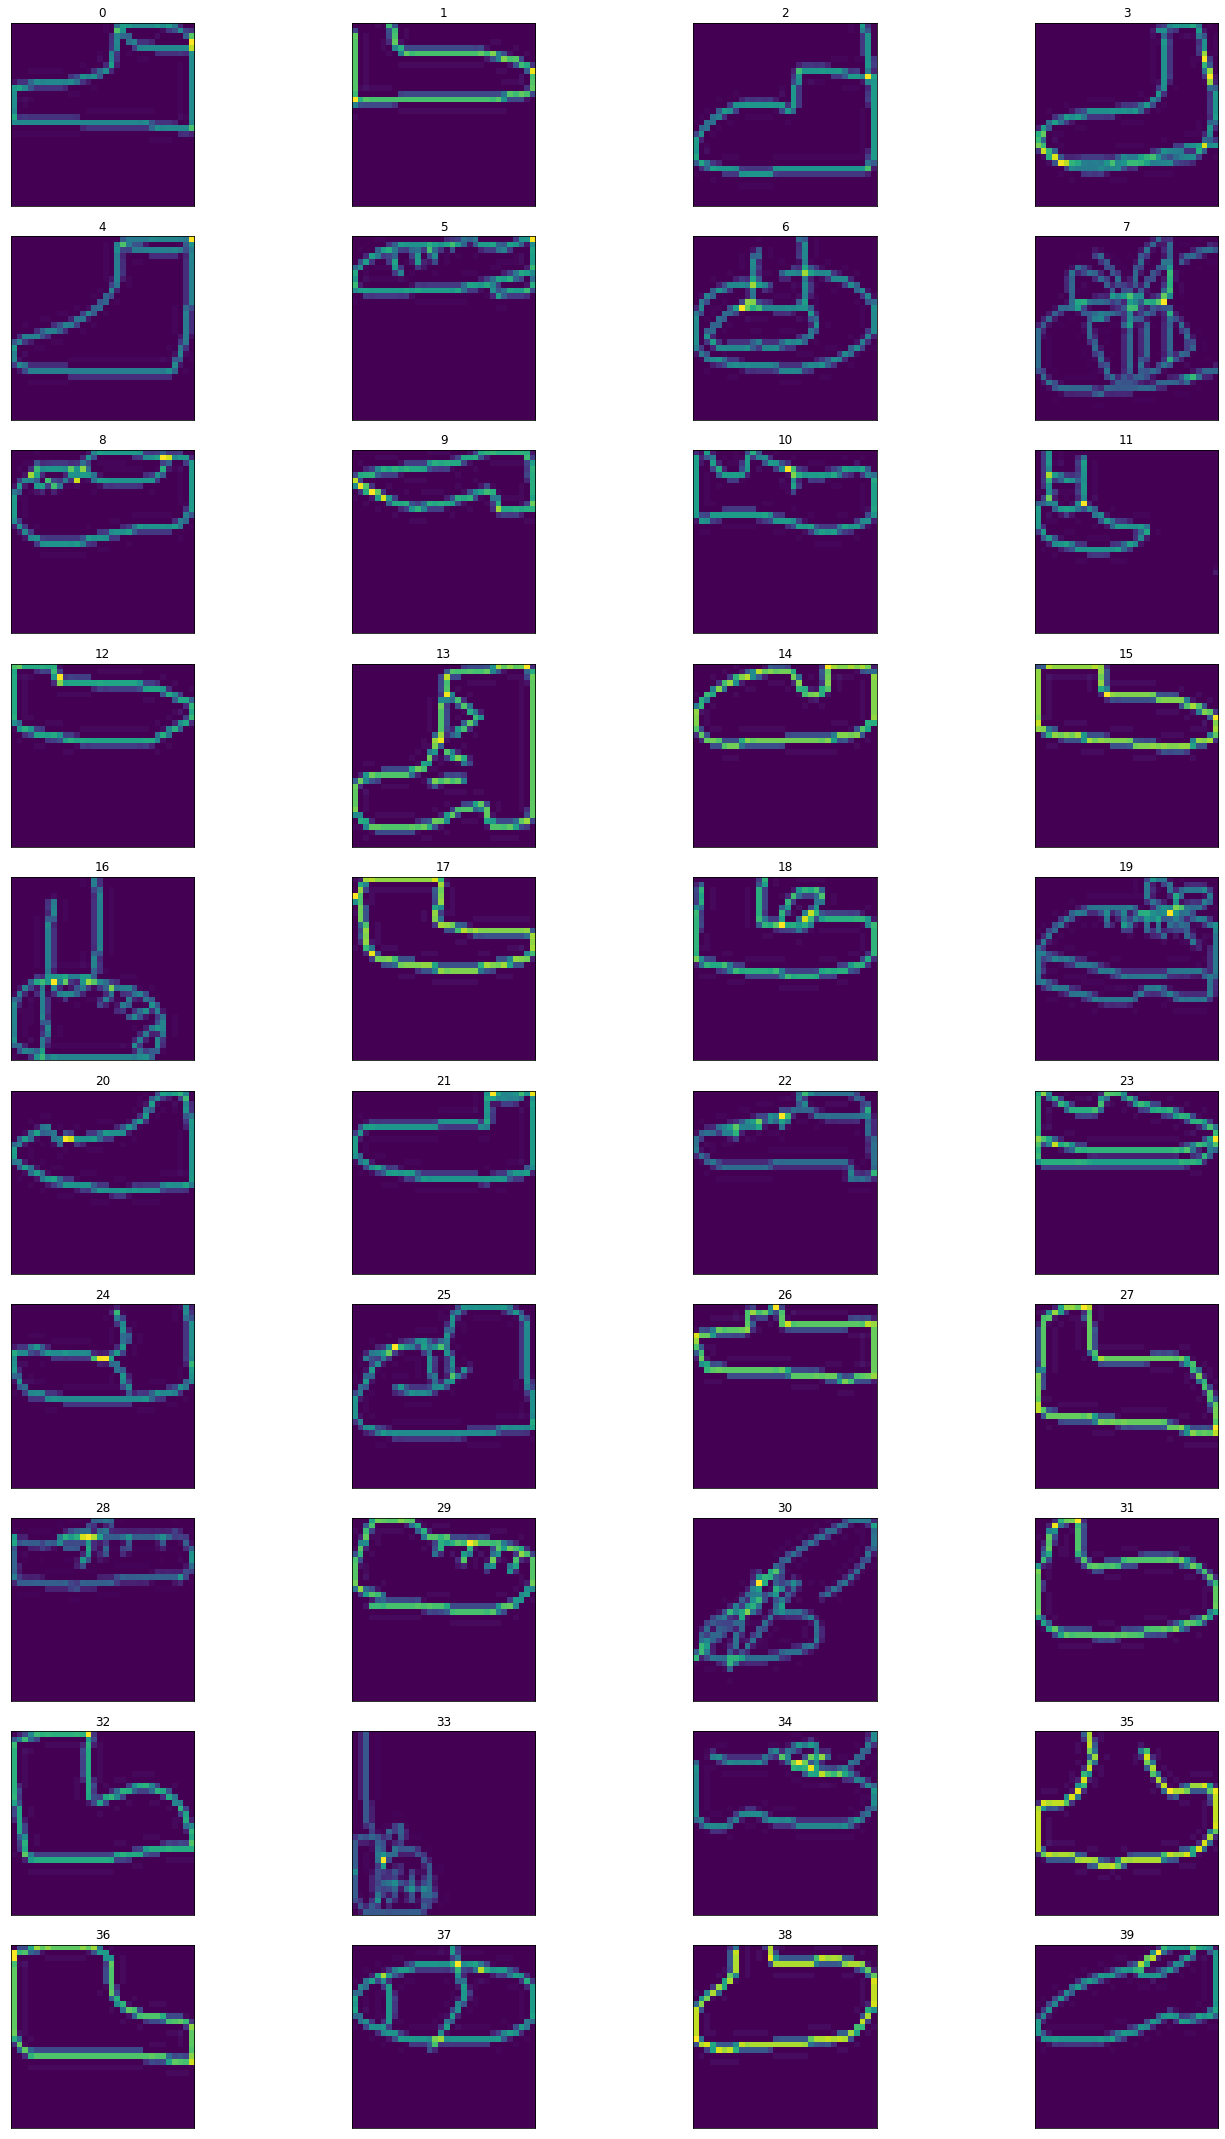

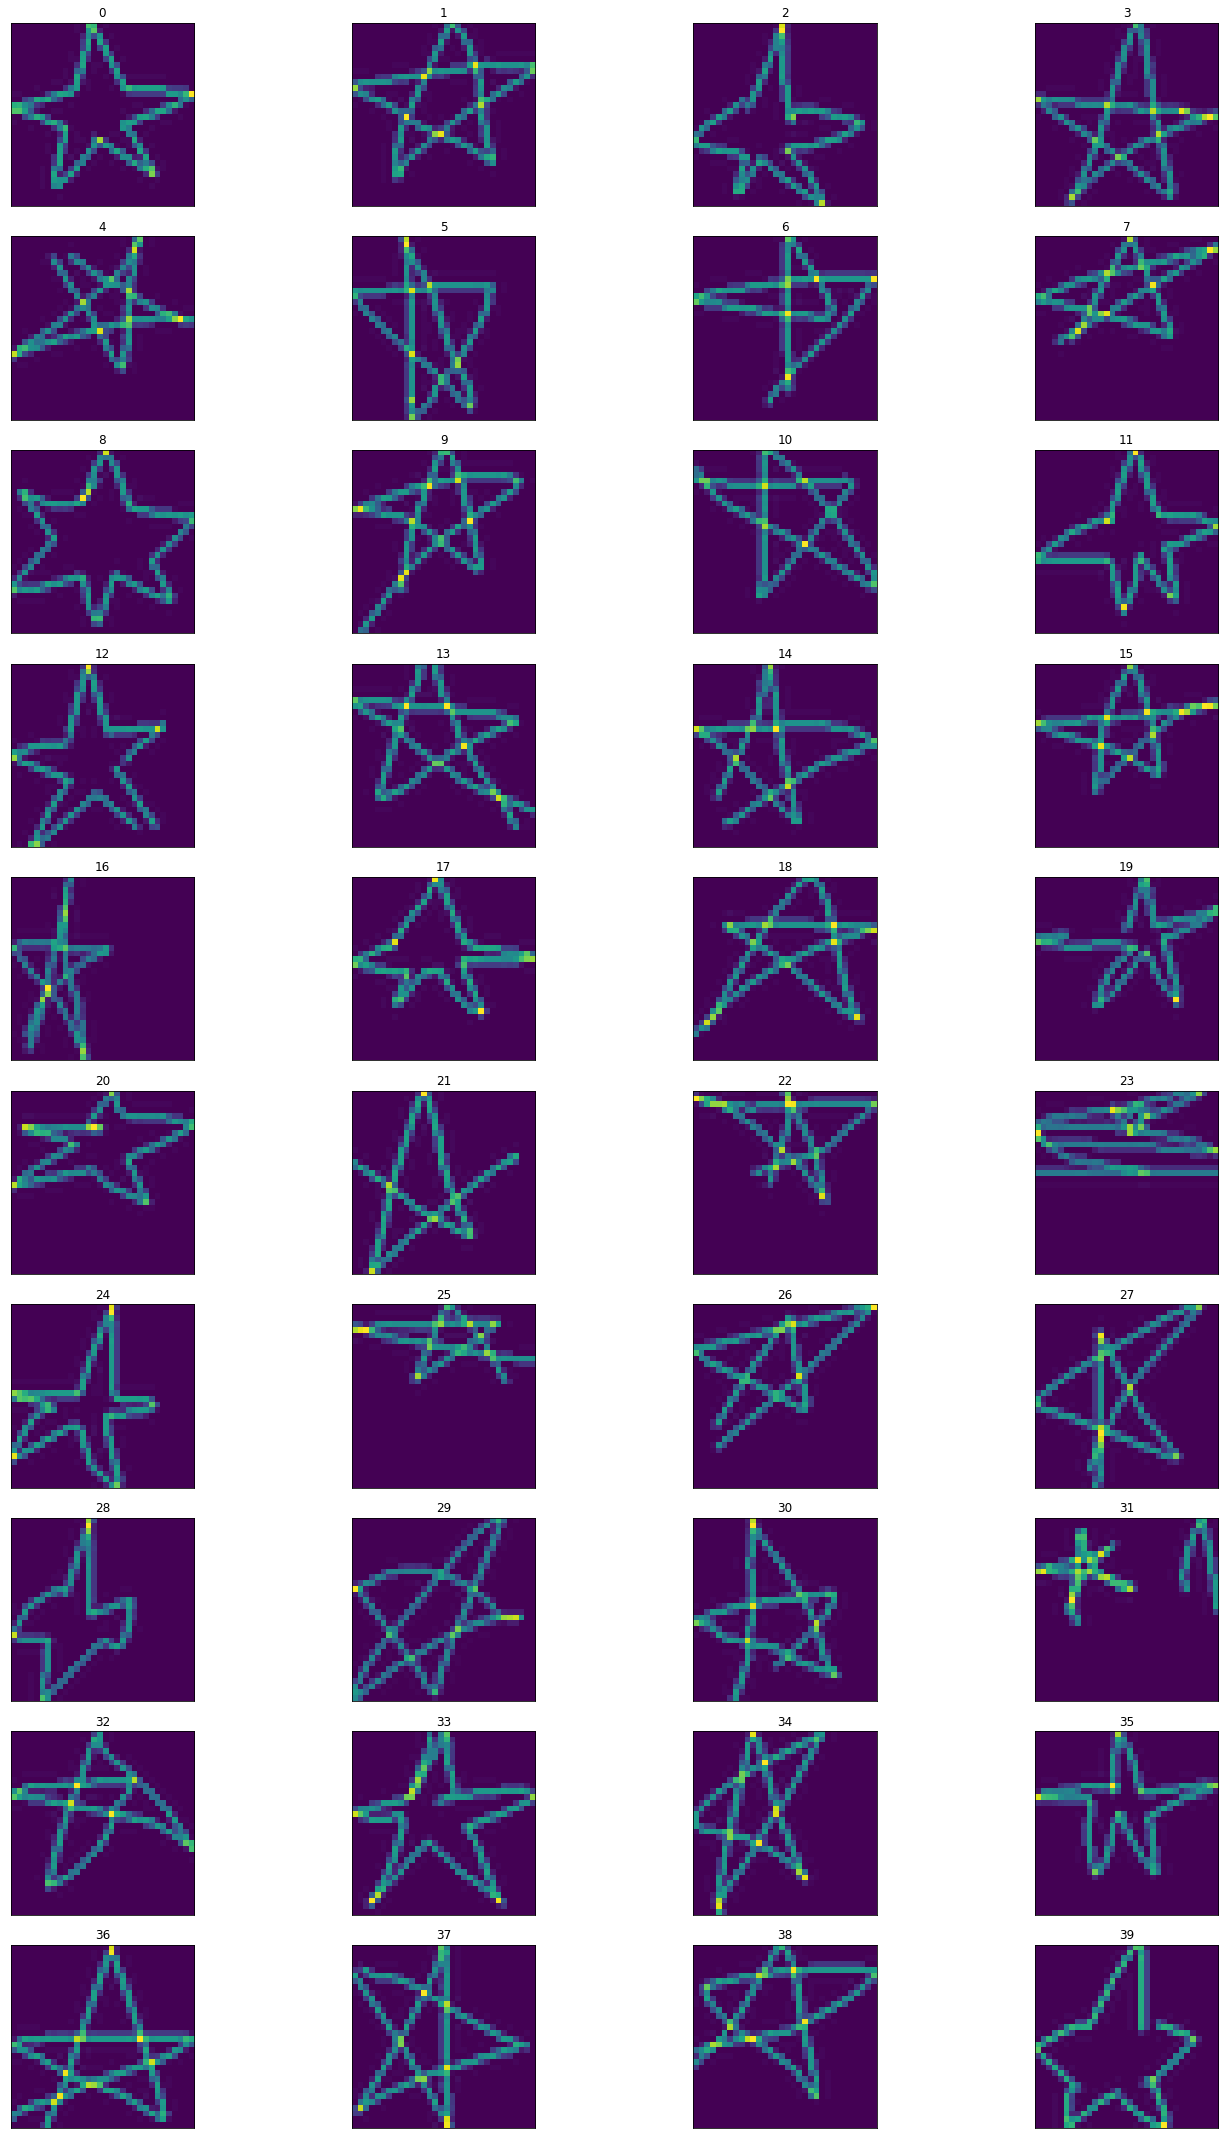

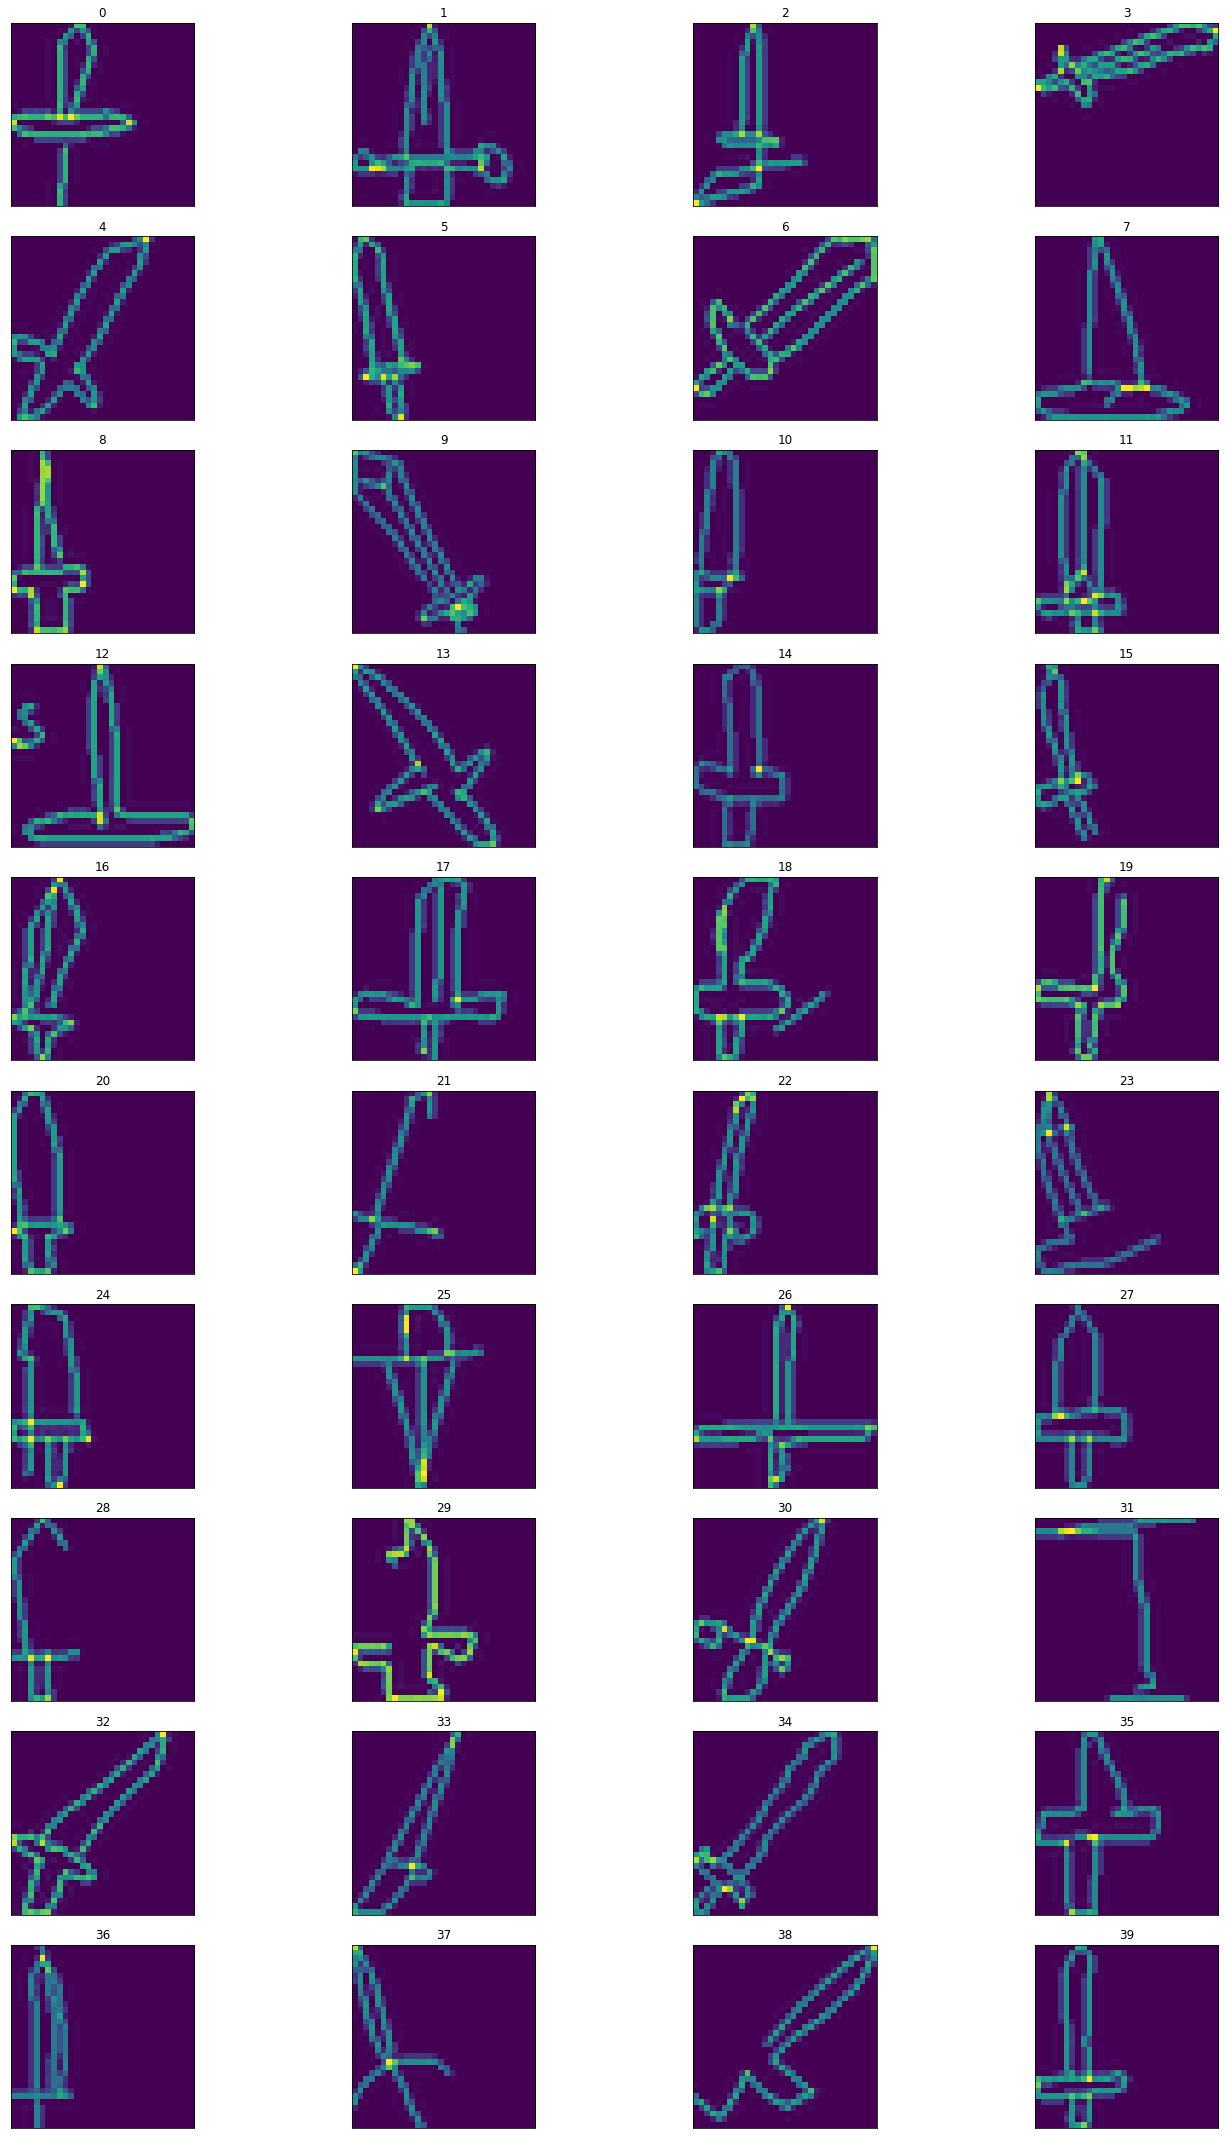

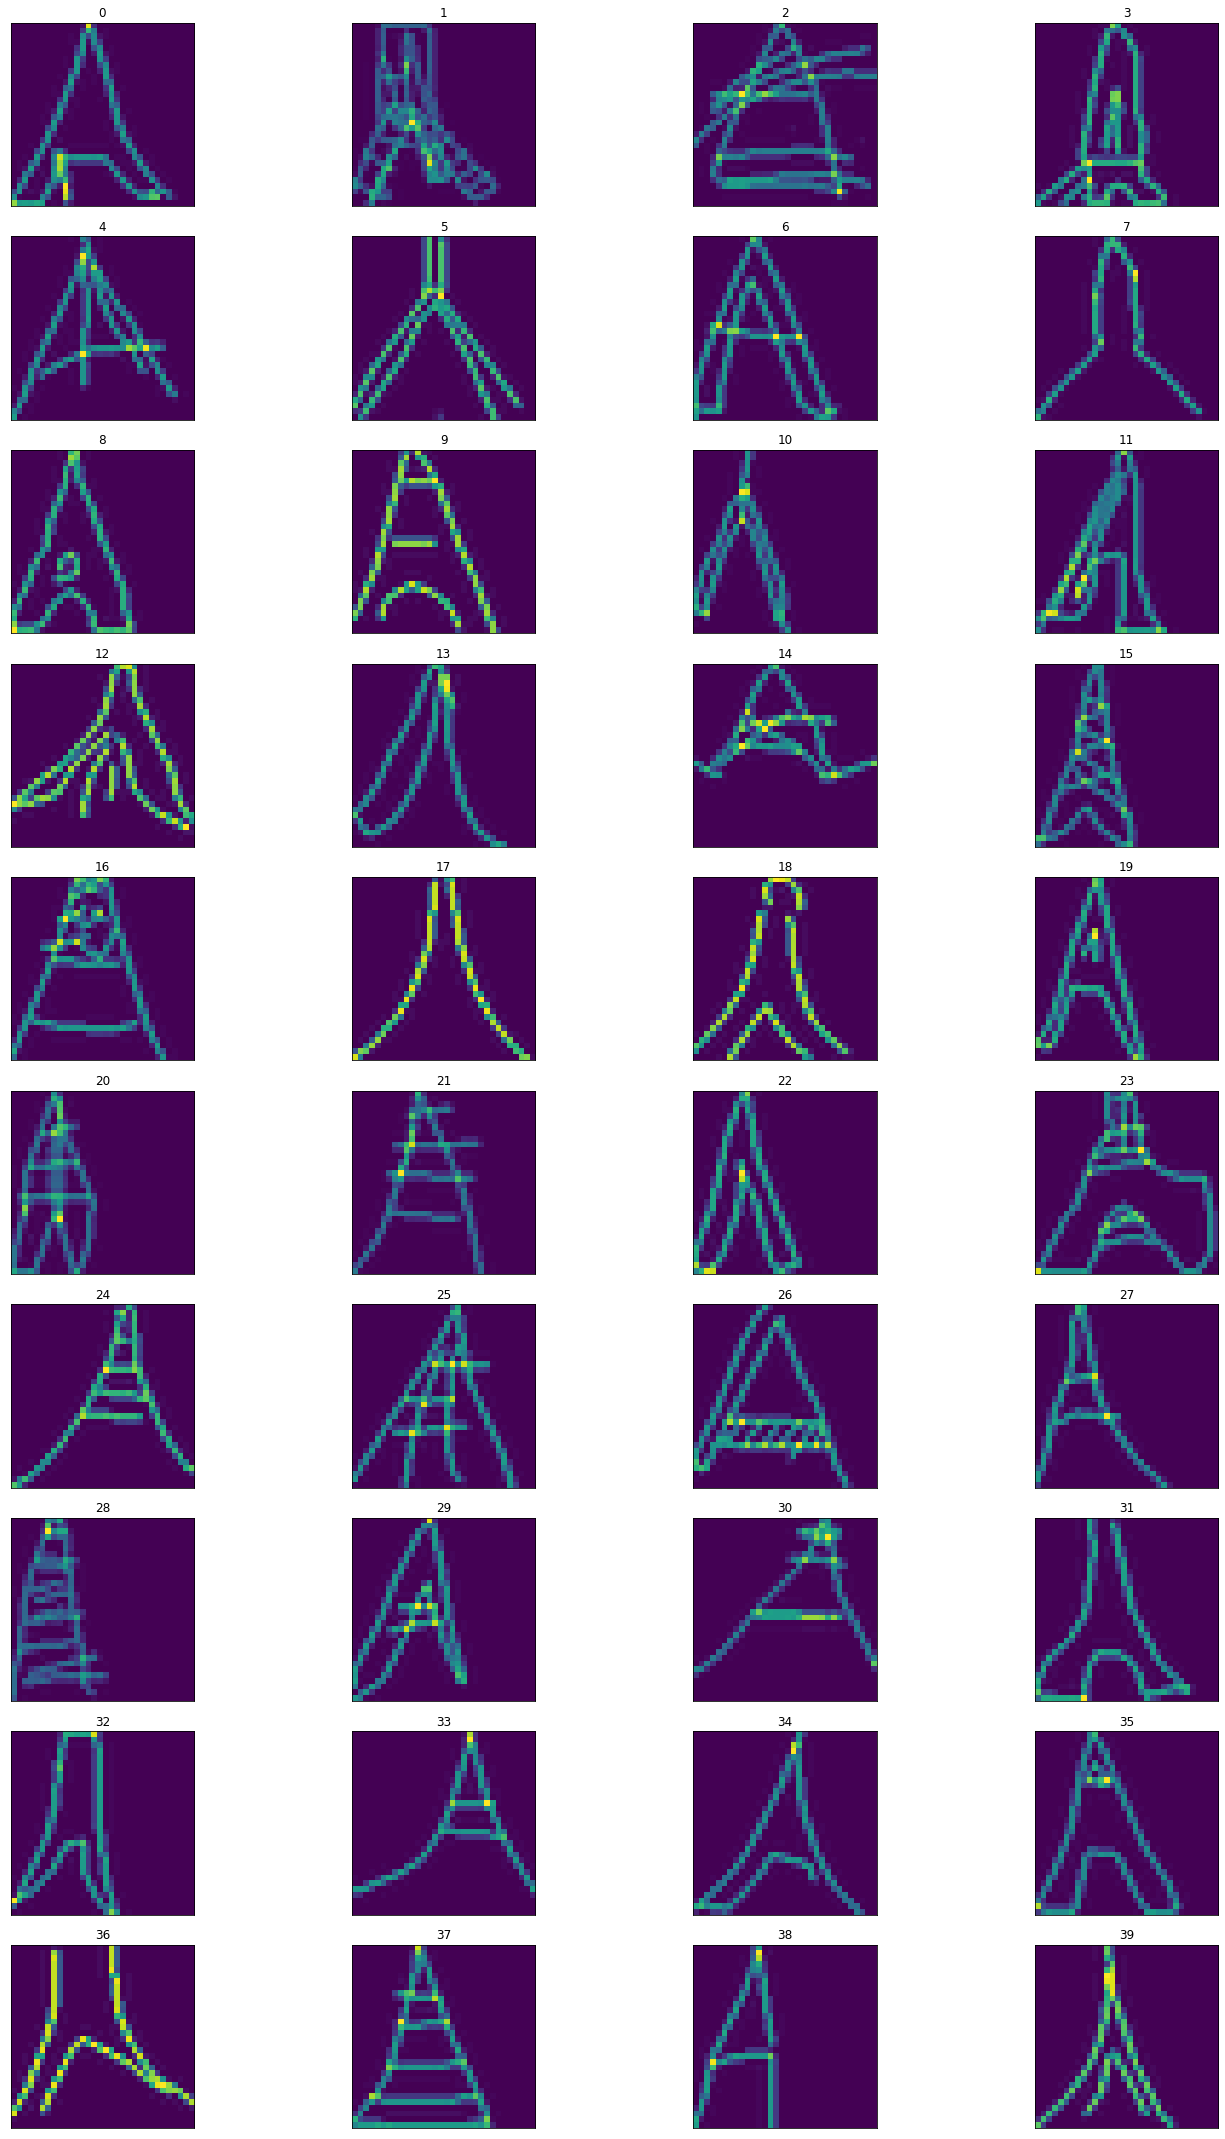

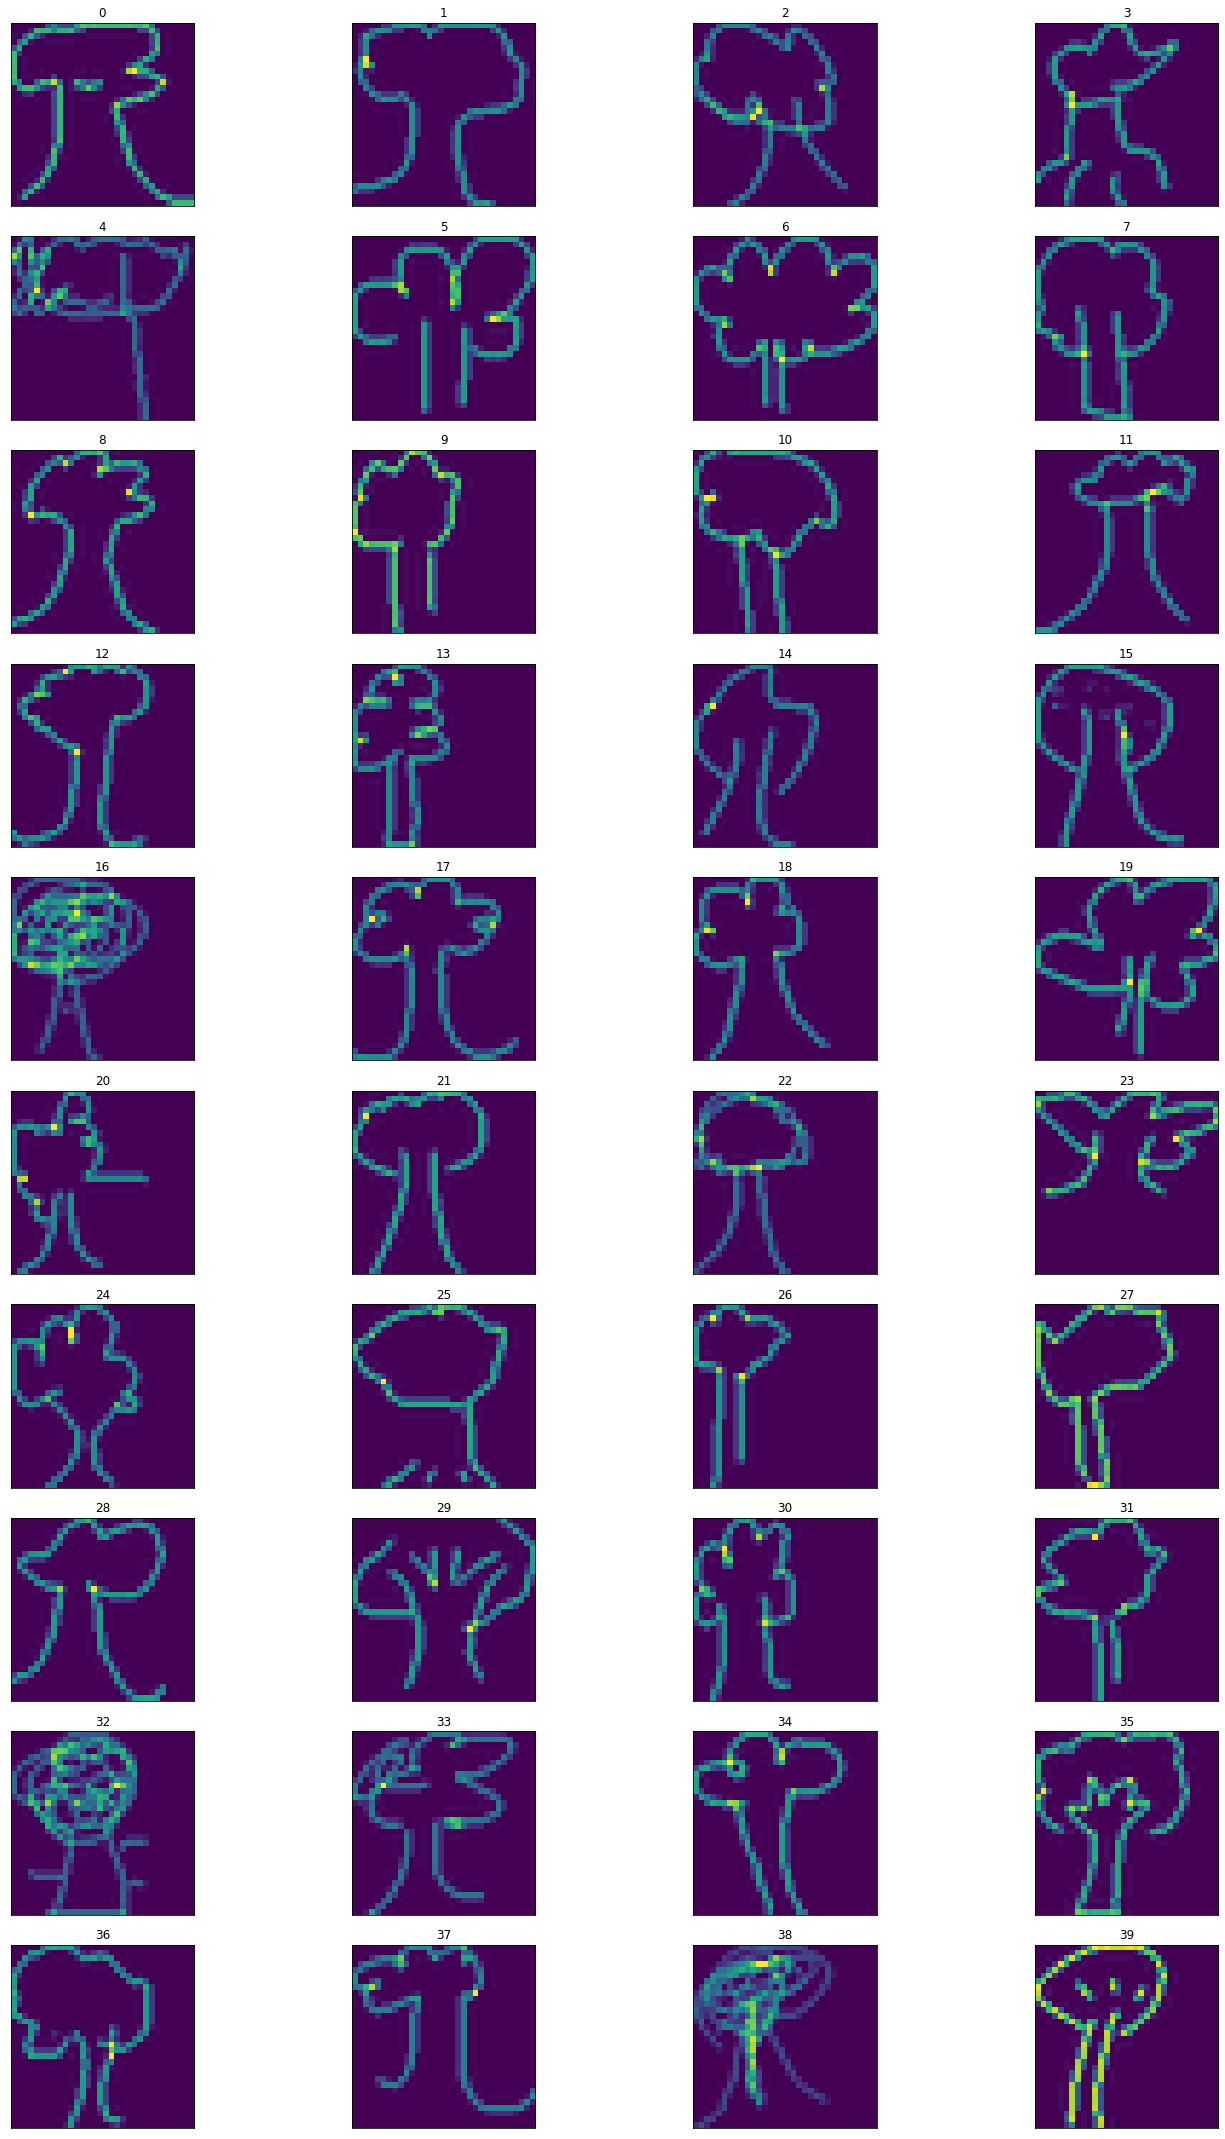

In [6]:
for j in range(len(categories)):
    correct_figure = plt.figure()
    correct_figure.set_size_inches(20, 30)
    offset=40*0
    for i in range(40):
        plt.subplot(10,4,i+1)
        plt.tight_layout()
        npimg = values_dict[categories[j]][i+offset].numpy()
        npimg = (npimg - np.min(npimg))/np.ptp(npimg)
        plt.imshow(npimg)
      # plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(i+offset)
        plt.xticks([])
        plt.yticks([])
    plt.savefig('first forty trunc/' + categories[j])

In [7]:
feature_tensor = torch.empty(0)
target_tensor = torch.empty(0)
for category in categories:
    feature_tensor = torch.cat((feature_tensor, values_dict[category]),0)
    target_tensor = torch.cat((target_tensor, ground_truth[category]),0)

data_set = torch.utils.data.TensorDataset(feature_tensor, target_tensor.long())


In [8]:
BATCH_SIZE = 64

# train_set, test_val = torch.utils.data.random_split(data_set, [270000, 30000])
# test_set, validation_set = torch.utils.data.random_split(test_val, [15000, 15000])
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
# val_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)


test_loader = torch.utils.data.DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True)

In [64]:
class DRAW_Stupid(nn.Module):
    def __init__(self):
        super(DRAW_Stupid, self).__init__()

        # linear activation
        self.relu_layer = nn.ReLU(inplace=True)
        # max pool 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2d(n_samples, channels, height, width)
        # first conv layer
        self.cnn_layer1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        
        # batch normalization
        self.batch1 = nn.BatchNorm2d(64)

        # second conv layer
        self.cnn_layer2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(32)

        self.linear_layer1 = nn.Linear(32 * 8 * 8, 128)
        self.linear_layer2 = nn.Linear(128,30)
        

    def forward(self, x):
        # first conv layer
        x = self.cnn_layer1(x)
        x = self.batch1(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # second conv layer
        x = self.cnn_layer2(x)
        x = self.batch2(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # linear 
        x = x.view(x.size(0), -1)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        return x

In [36]:
class DRAW_Net(nn.Module):
    def __init__(self):
        super(DRAW_Net, self).__init__()

        # linear activation
        self.relu_layer = nn.ReLU(inplace=True)
        # max pool 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2d(n_samples, channels, height, width)
        # first conv layer
        self.cnn_layer1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        
        # batch normalization
        self.batch1 = nn.BatchNorm2d(64)

        # second conv layer
        self.cnn_layer2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(32)

        # third conv layer
        self.cnn_layer3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(16)

        self.linear_layer1 = nn.Linear(16 * 4 * 4, 128)
        self.linear_layer2 = nn.Linear(128,64)
        self.linear_layer3 = nn.Linear(64,30)
        

    def forward(self, x):
        # first conv layer
        x = self.cnn_layer1(x)
        x = self.batch1(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # second conv layer
        x = self.cnn_layer2(x)
        x = self.batch2(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # third conv layer
        x = self.cnn_layer3(x)
        x = self.batch3(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # linear 
        x = x.view(x.size(0), -1)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.linear_layer3(x)
        return x

In [253]:
class DRAW_Net_128(nn.Module):
    def __init__(self):
        super(DRAW_Net_128, self).__init__()

        # linear activation
        self.relu_layer = nn.ReLU(inplace=True)
        # max pool 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2d(n_samples, channels, height, width)
        # first conv layer
        self.cnn_layer1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        
        # batch normalization
        self.batch1 = nn.BatchNorm2d(64)

        # second conv layer
        self.cnn_layer2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(128)

        # third conv layer
        self.cnn_layer3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(128)

        self.linear_layer1 = nn.Linear(128 * 4 * 4, 1024)
        self.linear_layer2 = nn.Linear(1024, 512)
        self.linear_layer3 = nn.Linear(512, 128)
        self.linear_layer4 = nn.Linear(128,64)
        self.linear_layer5 = nn.Linear(64,30)
        

    def forward(self, x):
        # first conv layer
        x = self.cnn_layer1(x)
        x = self.batch1(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # second conv layer
        x = self.cnn_layer2(x)
        x = self.batch2(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # third conv layer
        x = self.cnn_layer3(x)
        x = self.batch3(x)
        x = self.relu_layer(x)
        x = self.pool(x)

        # linear 
        x = x.view(x.size(0), -1)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.linear_layer3(x)
        x = self.linear_layer4(x)
        x = self.linear_layer5(x)
        return x

In [9]:
# change 2nd param for torchvision models
image_transform = transforms.Lambda(lambda x: x.repeat(1, 1, 1, 1) )

In [85]:


x_train_acc = torch.empty(0)
y_train_acc = torch.empty(0)
for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
  x_train_acc = torch.cat((x_train_acc, X_batch),0)
  y_train_acc = torch.cat((y_train_acc, y_batch),0)
  if batch_idx == 1:
    break


x_test_acc = torch.empty(0)
y_test_acc = torch.empty(0)
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
  x_test_acc = torch.cat((x_test_acc, X_batch),0)
  y_test_acc = torch.cat((y_test_acc, y_batch),0)
  if batch_idx == 1:
    break

x_val_acc = torch.empty(0)
y_val_acc = torch.empty(0)
for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
  x_val_acc = torch.cat((x_val_acc, X_batch),0)
  y_val_acc = torch.cat((y_val_acc, y_batch),0)
  if batch_idx == 1:
    break

x_train_acc = Variable(x_train_acc).float()
x_test_acc = Variable(x_test_acc).float()
x_val_acc = Variable(x_val_acc).float()


x_train_acc = image_transform(x_train_acc.unsqueeze(1)).to(device=device)
x_test_acc = image_transform(x_test_acc.unsqueeze(1)).to(device=device)
x_val_acc = image_transform(x_val_acc.unsqueeze(1)).to(device=device)
y_train_acc = y_train_acc.to(device=device)
y_test_acc = y_test_acc.to(device=device)
y_val_acc = y_val_acc.to(device=device)

In [12]:
training_acc = []
test_acc = []
val_acc = []
learning_curve = []
printout = ""
# draw_net = DRAW_Stupid().to(device=device)

## Load the model based on DenseNet-121
# draw_net = torchvision.models.densenet121(pretrained=True)
draw_net = torchvision.models.densenet161(pretrained=True)

## freeze the layers
# for param in draw_net.parameters():
#    param.requires_grad = False

# Modify first layer to 1 channel for 121
# draw_net.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# Modify first layer for 161
draw_net.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

draw_net.features.pool0 = nn.Identity()
# Modify the last layer
num_ftrs = draw_net.classifier.in_features
draw_net.classifier = nn.Linear(num_ftrs, len(categories))
draw_net = draw_net.to(device=device)

PATH = 'dense161_draw25k.pt'
draw_net.load_state_dict(torch.load(PATH))
# draw_net.eval()
optimizer = optim.Adam(draw_net.parameters(),lr=0.001)
# optimizer = optim.SGD(draw_net.parameters(),lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
EPOCHS = 1
# draw_net.train()


In [69]:
for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float().unsqueeze(1)
        var_X_batch = image_transform(var_X_batch).to(device=device)
        var_y_batch = Variable(y_batch).to(device=device)
        optimizer.zero_grad()
        
        # gray scale have to unsqueeze to add dimension
        output = draw_net(var_X_batch)
        predicted = torch.max(output.data, 1)[1] 
        loss = criterion(output,var_y_batch)
        loss.backward()
        optimizer.step()

        # training accuracy only first 64 to reduce training time
        output = draw_net( x_train_acc )
        predicted = torch.max(output.data, 1)[1] 
        correct = (predicted == y_train_acc).sum()
        total = len(predicted)

        accuracy = (predicted == y_train_acc).sum()/len(predicted)*100
    
        # learning curve
        cel = loss.item()
        learning_curve.append(cel)
            
        training_acc.append(accuracy.item())
        correct = 0 
        total = 0
        if batch_idx % 10 == 0: 
          accuracy = accuracy.item()
          currently_run = batch_idx*len(X_batch)
          data_total = len(train_loader.dataset)
          percent_of_data_run = 100.*batch_idx / len(train_loader)
          print('Epoch: {}[{}/{} ({:.0f}%)]\t Accuracy:{:.3f}%\t Error:{:.2f}'.format(
              epoch, currently_run, data_total, percent_of_data_run, accuracy, cel))
        
        # use only first 64 for test and validation because using whole test during training takes too long, can compute for total later
        output = draw_net( x_test_acc )
        predicted = torch.max(output.data, 1)[1] 
        correct = (predicted == y_test_acc).sum()
        total = len(predicted)

        test_acc.append((correct/total*100).item())

        output = draw_net( x_val_acc )
        predicted = torch.max(output.data, 1)[1] 
        correct = (predicted == y_val_acc).sum()
        total = len(predicted)

        val_acc.append((correct/total*100).item())
        

Epoch: 0[0/60000 (0%)]	 Accuracy:13.281%	 Error:3.41
Epoch: 0[640/60000 (1%)]	 Accuracy:42.969%	 Error:2.36
Epoch: 0[1280/60000 (2%)]	 Accuracy:59.375%	 Error:1.68
Epoch: 0[1920/60000 (3%)]	 Accuracy:71.875%	 Error:1.15
Epoch: 0[2560/60000 (4%)]	 Accuracy:74.219%	 Error:1.05
Epoch: 0[3200/60000 (5%)]	 Accuracy:78.125%	 Error:1.00
Epoch: 0[3840/60000 (6%)]	 Accuracy:77.344%	 Error:0.76
Epoch: 0[4480/60000 (7%)]	 Accuracy:84.375%	 Error:0.72
Epoch: 0[5120/60000 (9%)]	 Accuracy:81.250%	 Error:0.96
Epoch: 0[5760/60000 (10%)]	 Accuracy:85.156%	 Error:0.47
Epoch: 0[6400/60000 (11%)]	 Accuracy:82.812%	 Error:0.32
Epoch: 0[7040/60000 (12%)]	 Accuracy:82.812%	 Error:0.63
Epoch: 0[7680/60000 (13%)]	 Accuracy:83.594%	 Error:0.58
Epoch: 0[8320/60000 (14%)]	 Accuracy:84.375%	 Error:0.45
Epoch: 0[8960/60000 (15%)]	 Accuracy:86.719%	 Error:0.78
Epoch: 0[9600/60000 (16%)]	 Accuracy:87.500%	 Error:0.29
Epoch: 0[10240/60000 (17%)]	 Accuracy:87.500%	 Error:0.52
Epoch: 0[10880/60000 (18%)]	 Accuracy:86.71

In [13]:
#PATH = 'dense161_draw25k.pt'
torch.save(draw_net.state_dict(), PATH)

In [91]:
predictions = []
gts = []
train_X = []
correct = 0 
total = 0
for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    var_X_batch = image_transform(Variable(X_batch).float().unsqueeze(1)).to(device=device)
    var_y_batch = Variable(y_batch).to(device=device)

    output = draw_net(var_X_batch)
    predicted = torch.max(output.data, 1)[1] 
#     predict = predicted.cpu().detach().numpy()
#     for x in predict:
#         predictions.append(x)
#     gt = var_y_batch.cpu().detach().numpy()
#     for x in gt:
#         gts.append(x)
    correct += (predicted.cpu().detach() == var_y_batch.cpu().detach()).sum()
    total += len(predicted.cpu().detach())
train_accuracy = correct/total*100

# total_train_accuracy = (np.array(predictions) == np.array(gts)).sum() / len(predictions) * 100 
print( "Training Accuracy: ", train_accuracy.item())
printout += "Training Accuracy: " + str(train_accuracy.item()) 

Training Accuracy:  98.69851684570312


In [13]:
correct = 0
total = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = image_transform(Variable(X_batch).float().unsqueeze(1)).to(device=device)
    var_y_batch = Variable(y_batch).to(device=device)

    output = draw_net(var_X_batch)
    predicted = torch.max(output.data, 1)[1] 

    correct += (predicted.cpu().detach() == var_y_batch.cpu().detach()).sum()
    total += len(predicted.cpu().detach())

test_accuracy = correct/total*100
# correct = 0 
# total = 0
# for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
#     var_X_batch = image_transform(Variable(X_batch).float().unsqueeze(1)).to(device=device)
#     var_y_batch = Variable(y_batch).to(device=device)

#     output = draw_net(var_X_batch)
#     predicted = torch.max(output.data, 1)[1] 

#     correct += (predicted.cpu().detach() == var_y_batch.cpu().detach()).sum()
#     total += len(predicted.cpu().detach())

# val_accuracy = correct/total*100

print("Test Accuracy: ", test_accuracy.item())
# print("Validation Accuracy: ", val_accuracy.item())
# printout += "\nTest Accuracy: " + str(test_accuracy.item()) + "\nValidation Accuracy: " + str(val_accuracy.item())

Test Accuracy:  97.48332977294922


In [48]:
data_loader = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)

In [72]:
correct = 0
total = 0
predictions = []
gts = []
for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
    var_X_batch = image_transform(Variable(X_batch).float().unsqueeze(1)).to(device=device)
    var_y_batch = Variable(y_batch).to(device=device)

    output = draw_net(var_X_batch)
    predicted = torch.max(output.data, 1)[1] 
    predict = predicted.cpu().detach().numpy()
    for x in predict:
        predictions.append(x)
    gt = var_y_batch.cpu().detach().numpy()
    for x in gt:
        gts.append(x)
    correct += (predicted == var_y_batch).sum()
    total += len(predicted)

test_accuracy = correct/total*100

In [73]:
print(len(predictions))

300000


In [74]:
print(test_accuracy)
total_train_accuracy = (np.array(predictions) == np.array(gts)).sum() / len(predictions) * 100 
print(total_train_accuracy)

tensor(65.4943, device='cuda:0')
65.49433333333333


In [75]:
predictdict = []
gtdict = []
for i in range(30):
    predictdict.append([])
    gtdict.append([])
for i in range(len(gts)):
    predictdict[gts[i]].append(predictions[i])
    gtdict[gts[i]].append(gts[i])

In [76]:
len(predictdict[29])

10000

In [77]:
import csv
for i in range(0,30):
    wtr = csv.writer(open ( 'truncatemore/' +str(categories[i])+'_truncate.csv', 'w'), delimiter=',', lineterminator='\n')
    for x in range(len(predictdict[i])) : wtr.writerow ([predictdict[i][x], gtdict[i][x]])
# for x in range(len(predictions)) : wtr.writerow ([predictions[x], gts[x]])

In [59]:
#print( draw_net.cnn_layer1.weight.detach().numpy()[0][0][0])
layer1_weight = []
layer1=draw_net.cnn_layer1.weight.cpu().detach().numpy()
for i in range(len(layer1)):
  for j in range(len(layer1[i][0][0])):
    layer1_weight.append(layer1[i][0][0][j])

layer2_weight = []
layer2 = draw_net.cnn_layer2.weight.cpu().detach().numpy()
for i in range(len(layer2)):
  for j in range(len(layer2[i][0][0])):
    layer2_weight.append(layer2[i][0][0][j])

layer3_weight = []
layer3 = draw_net.cnn_layer3.weight.cpu().detach().numpy()
for i in range(len(layer3)):
  for j in range(len(layer3[i][0][0])):
    layer3_weight.append(layer3[i][0][0][j])

linear1_weight = []
linear1 = draw_net.linear_layer1.weight.cpu().detach().numpy()
for i in range(len(linear1)):
  for j in range(len(linear1[i])):
    linear1_weight.append(linear1[i][j])

linear2_weight = []
linear2 = draw_net.linear_layer2.weight.cpu().detach().numpy()
for i in range(len(linear2)):
  for j in range(len(linear2[i])):
    linear2_weight.append(linear2[i][j])

output_weight = []
linear3 = draw_net.linear_layer3.weight.cpu().detach().numpy()
for i in range(len(linear3)):
  for j in range(len(linear3[i])):
    output_weight.append(linear3[i][j])

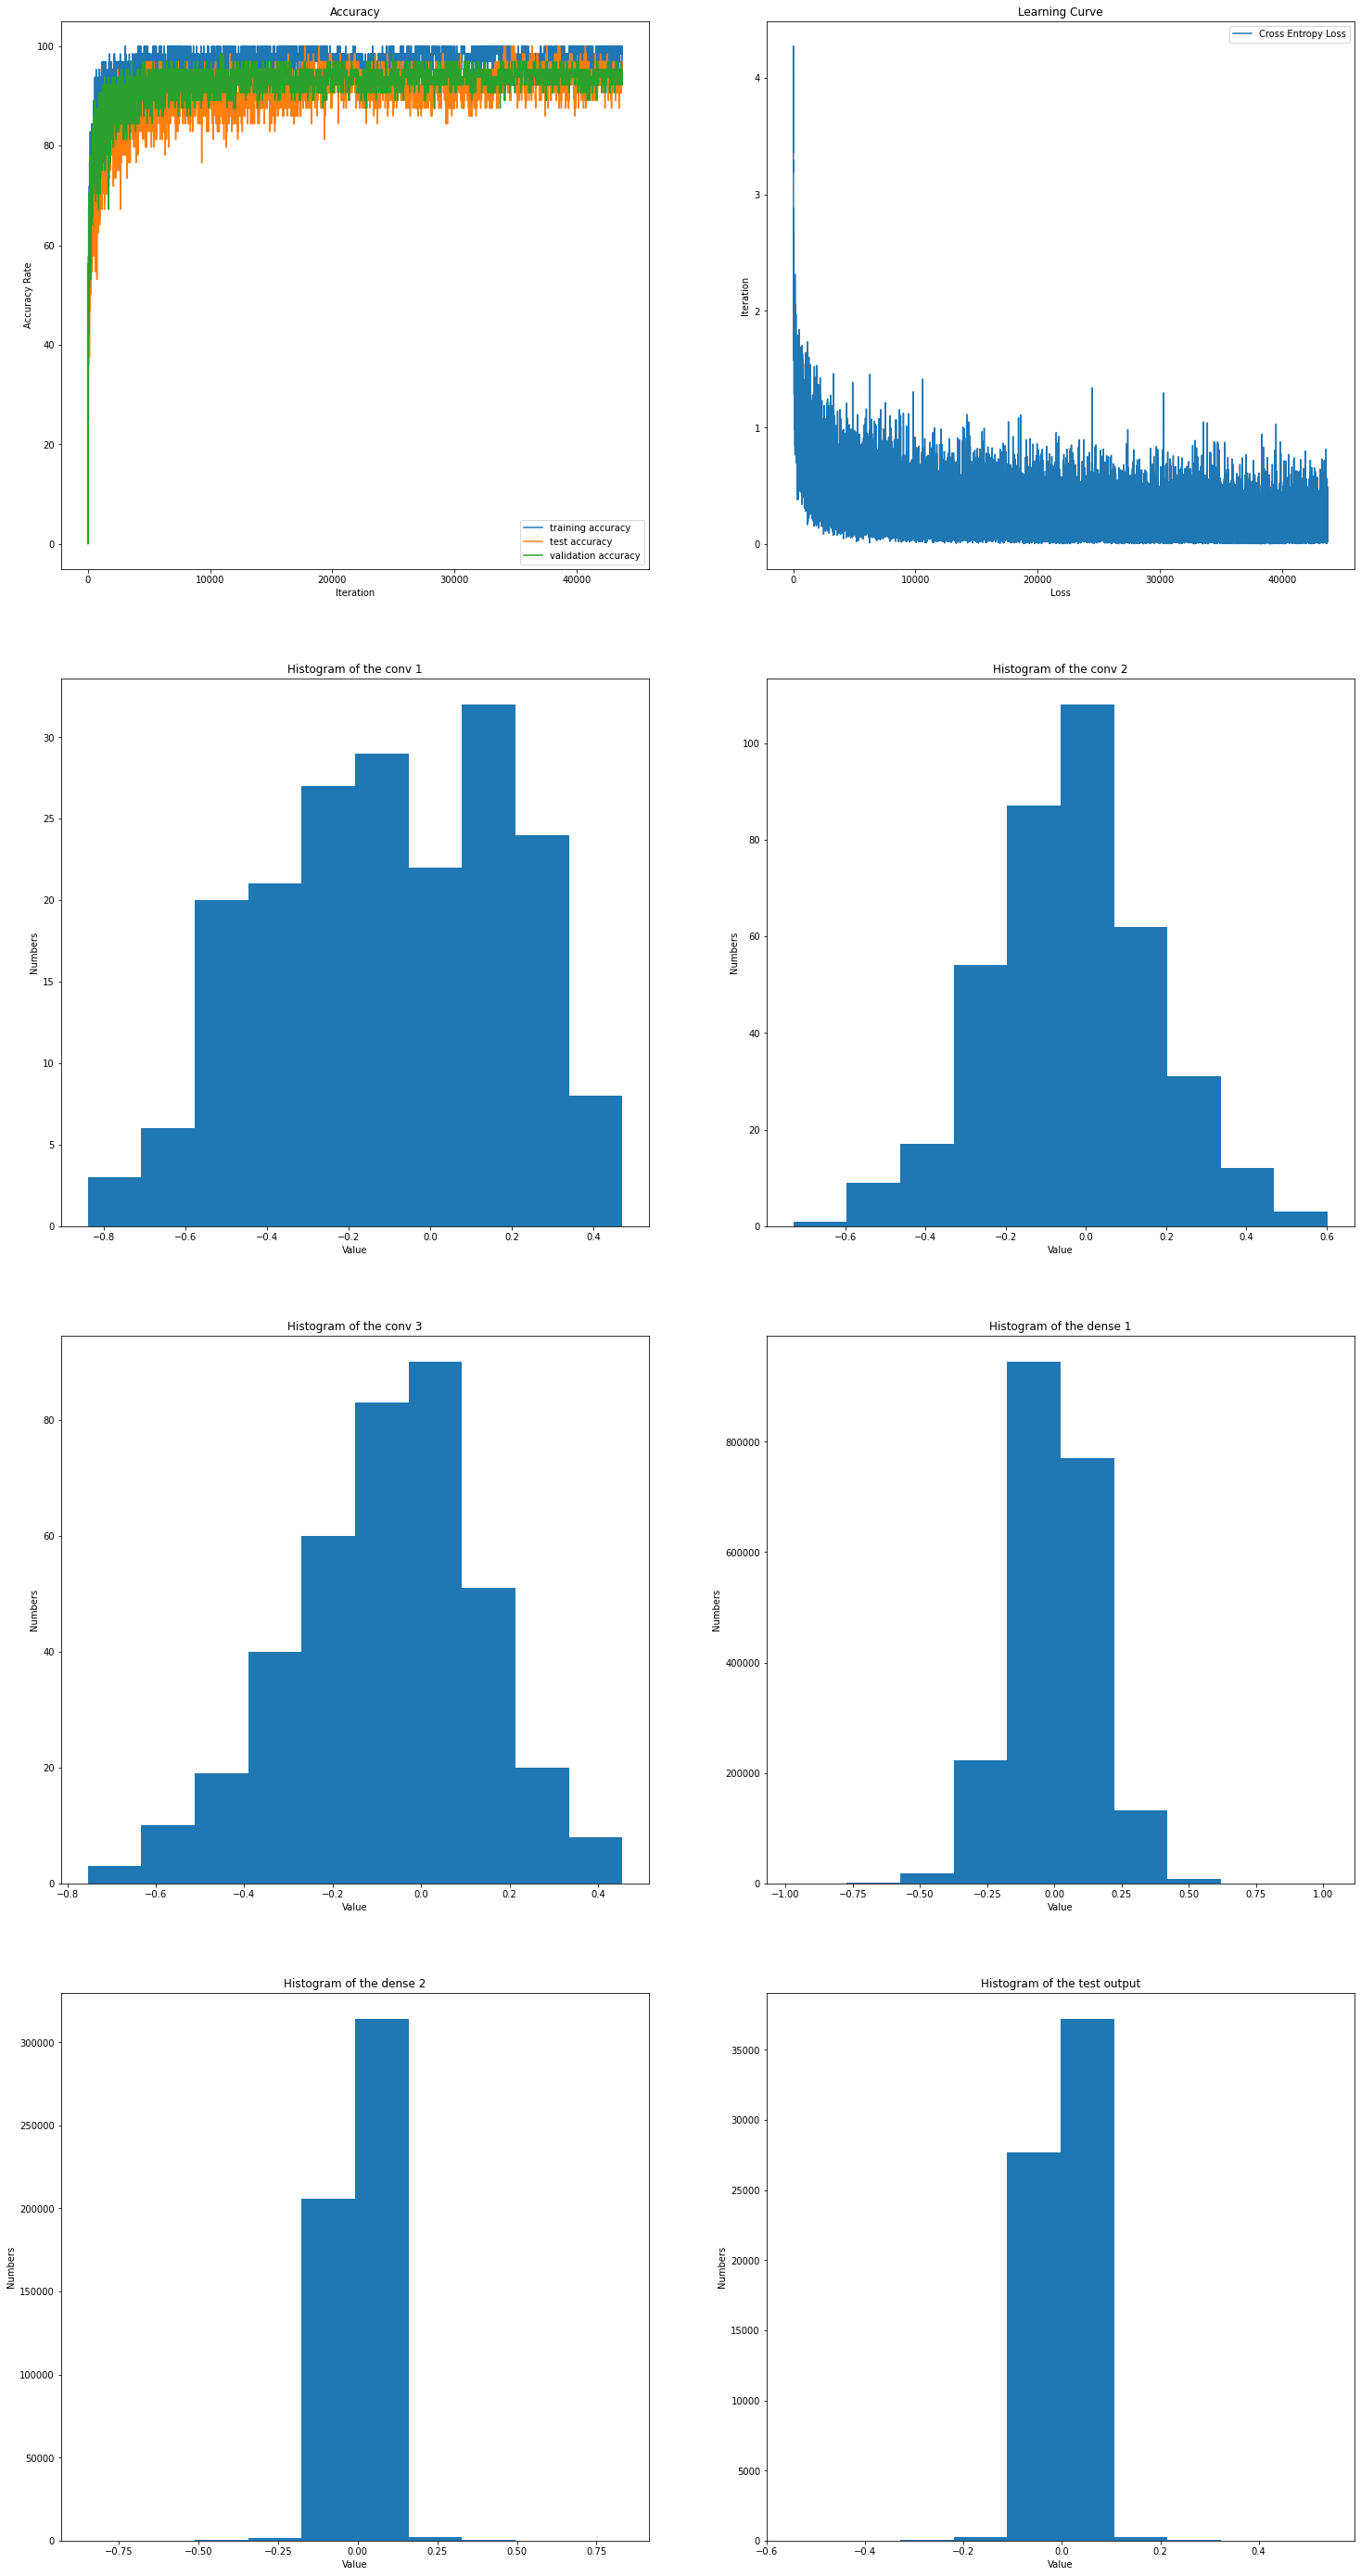

In [60]:
histogram = plt.figure()
histogram.set_size_inches(25, 50)
# training accuracy
plt.subplot(4,2,1)
plt.plot(training_acc, label='training accuracy')
plt.plot(test_acc, label='test accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy Rate")
plt.title("Accuracy")

# learning curve
plt.subplot(4,2,2)
plt.plot(learning_curve, label='Cross Entropy Loss')
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Iteration")
plt.title("Learning Curve")

# histo conv1
plt.subplot(4,2,3)
plt.hist( layer1_weight )  
plt.xlabel('Value')  
plt.ylabel('Numbers')  
plt.title('Histogram of the conv 1')  

# histo conv2
plt.subplot(4,2,4)
plt.hist( layer2_weight )  
plt.xlabel('Value')  
plt.ylabel('Numbers')  
plt.title('Histogram of the conv 2')  

# histo conv3
plt.subplot(4,2,5)
plt.hist( layer3_weight )  
plt.xlabel('Value')  
plt.ylabel('Numbers')  
plt.title('Histogram of the conv 3')  

# histo dense 1
plt.subplot(4,2,6)
plt.hist( linear1_weight )  
plt.xlabel('Value')  
plt.ylabel('Numbers')  
plt.title('Histogram of the dense 1')  

# histo dense 2
plt.subplot(4,2,7)
plt.hist( linear2_weight)  
plt.xlabel('Value')  
plt.ylabel('Numbers')  
plt.title('Histogram of the dense 2')  

# histo output
plt.subplot(4,2,8)
plt.hist( output_weight )  
plt.xlabel('Value')  
plt.ylabel('Numbers')  
plt.title('Histogram of the test output')  
plt.savefig("draw CNN graphs")

In [14]:
x_test = torch.empty(0)
y_label = torch.empty(0)
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
  x_test = torch.cat((x_test, X_batch),0)
  y_label = torch.cat((y_label, y_batch),0)
  if batch_idx == 3:
    break
output = draw_net(image_transform(x_test.float().unsqueeze(1)).to(device=device))
predicted = torch.max(output.data, 1)[1] 

correct_label = []

for i in range(len(y_label)):
  if predicted[i] == y_label[i]:
    correct_label.append(i)

mislabeled = []

for i in range(len(y_label)):
  if predicted[i] != y_label[i]:
    mislabeled.append(i)

y_label = y_label.int()

correct_figure = plt.figure()
correct_figure.set_size_inches(20, 10)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  npimg = y_test[correct_label[i]].numpy()
  npimg = (npimg - np.min(npimg))/np.ptp(npimg)
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.imshow(npimg)
  plt.title("Predicted: {}, GT: {}".format(categories[predicted[correct_label[i]]], categories[y_label[correct_label[i]]]))
  plt.xticks([])
  plt.yticks([])
plt.savefig("correct predictions")
mislabeled_figure = plt.figure()
mislabeled_figure.set_size_inches(20, 10)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  npimg = y_test[mislabeled[i]].numpy()
  npimg = (npimg - np.min(npimg))/np.ptp(npimg)
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.imshow(npimg)
  plt.title("Predicted: {}, GT: {}".format(categories[predicted[mislabeled[i]]], categories[y_label[mislabeled[i]]]))
  plt.xticks([])
  plt.yticks([])
plt.savefig("wrong predictions")

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 7.01 GiB already allocated; 17.00 MiB free; 7.24 GiB reserved in total by PyTorch)

In [73]:
mistakes = Variable(y_test[mislabeled[:]]).float().unsqueeze(1)
output1 = draw_net.cnn_layer1(mistakes.to(device=device))
batch1 = draw_net.batch1(output1)
relu1 = draw_net.relu_layer(batch1)
pool1 = draw_net.pool(relu1)
output2 = draw_net.cnn_layer2(pool1)
batch2 = draw_net.batch2(output2)
relu2 = draw_net.relu_layer(batch2)
pool2 = draw_net.pool(relu2)
output3 = draw_net.cnn_layer3(pool2)
batch3 = draw_net.batch3(output3)
relu3 = draw_net.relu_layer(batch3)
pool3 = draw_net.pool(relu3)

feature_map = []
feature_map.append(output1)
feature_map.append(batch1)
feature_map.append(relu1)
feature_map.append(pool1)
feature_map.append(output2)
feature_map.append(batch2)
feature_map.append(relu2)
feature_map.append(pool2)
feature_map.append(output3)
feature_map.append(batch3)
feature_map.append(relu3)
feature_map.append(pool3)

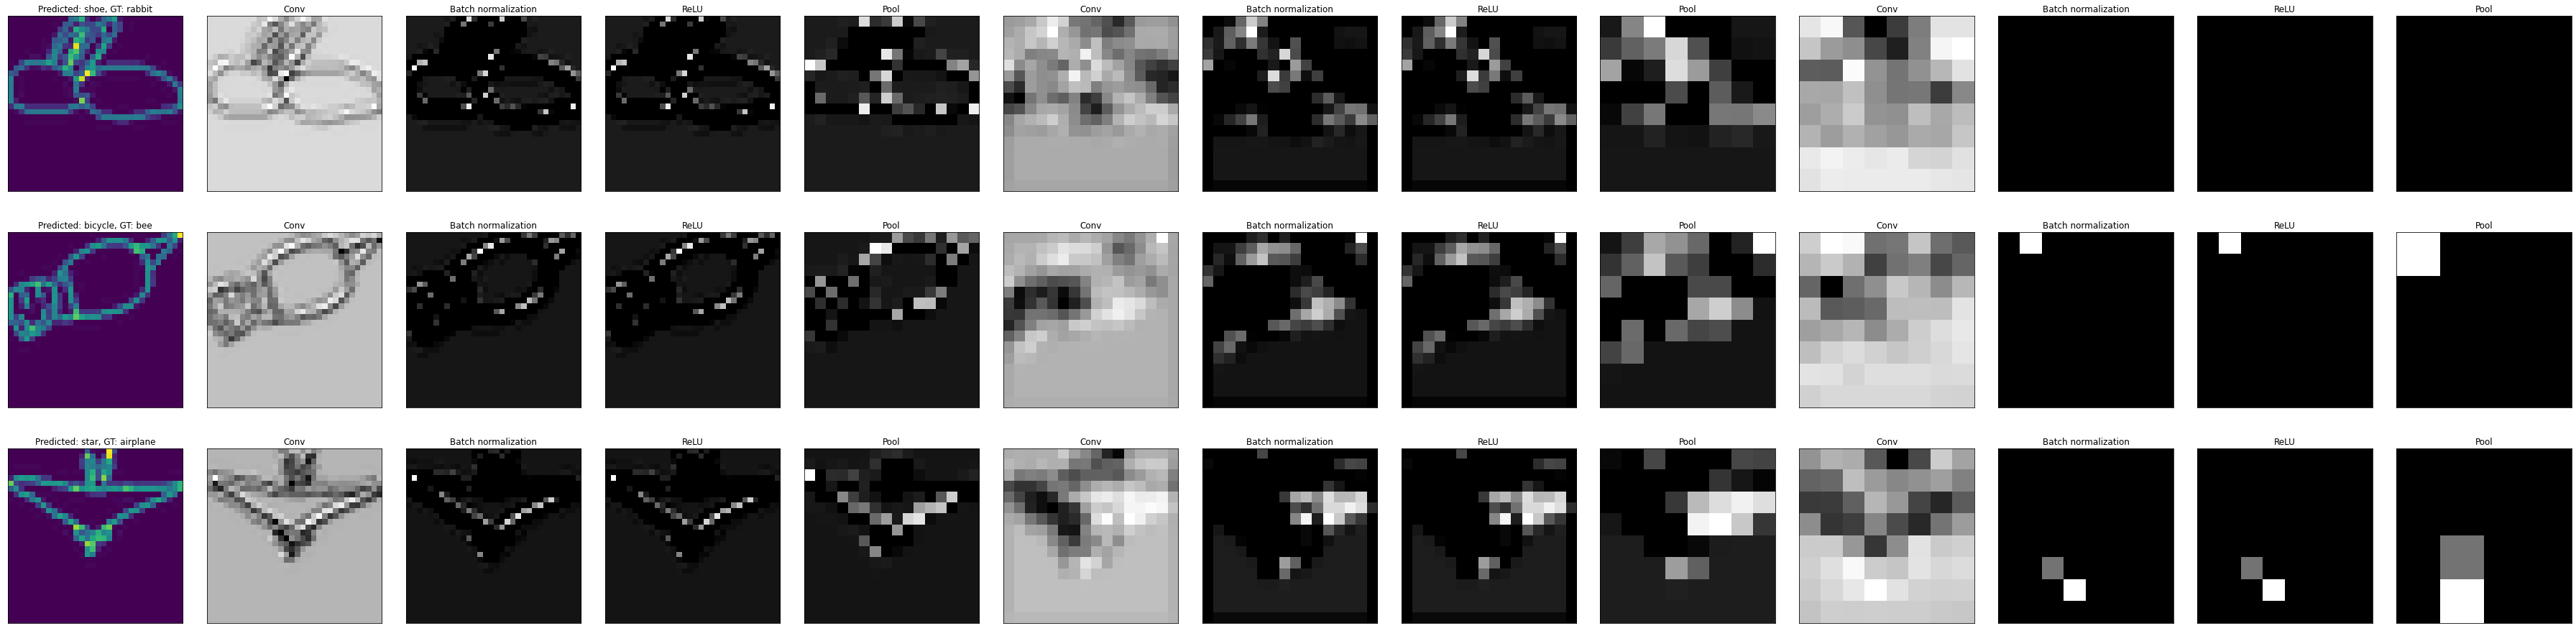

In [74]:
mistake_map = plt.figure()
mistake_map.set_size_inches(50, 25)
for i in range(3):
  plt.subplot(6,len(feature_map)+1,i*13+1)
  plt.tight_layout()
  npimg = mistakes[i].numpy()
  npimg = (npimg - np.min(npimg))/np.ptp(npimg)
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.imshow(npimg[0])
  plt.title("Predicted: {}, GT: {}".format(categories[predicted[mislabeled[i]]], categories[y_label[mislabeled[i]]]))
  # plt.imshow(mistakes[i][0].detach().numpy(), cmap='gray', interpolation='none')
  # plt.title("Predicted: {}, GT: {}".format(predicted[mislabeled[i]], torch_y_test[mislabeled[i]]))
  plt.xticks([])
  plt.yticks([])
  for j in range(len(feature_map)):
    plt.subplot(6,len(feature_map)+1,i*13+1+j+1)
    plt.tight_layout()
    plt.imshow(feature_map[j][i][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
    if j == 0 or j == 4 or j == 8: 
      plt.title("Conv")
    elif j == 1 or j == 5 or j == 9:
      plt.title("Batch normalization")
    elif j == 2 or j == 6 or j == 10:
      plt.title("ReLU")
    else:
      plt.title("Pool")
    plt.xticks([])
    plt.yticks([])

plt.savefig("feature maps")